In [1]:
%load_ext pycodestyle_magic
%flake8_on
%load_ext autoreload

In [2]:
%autoreload 2

In [19]:
"""Python code to classify X-ray sources by color.

Functionalities needed.

1. Line, step, scatter and histogram and kde plots
2. Plot net counts, bg/net and S/N ratio
3. Process detectors seperately and combine colors only optional
4. Cross-match 4XMM and CSC sources.
5. Compare with Haley et al. sources.
"""


import copy
import os
import glob2
import warnings
import xspec
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from scipy.ndimage import median_filter


# Plot functions
def set_plotparams(plottype):
    """Set plot parameters."""
    if plottype == 'notebook':
        plt.rcParams["figure.figsize"] = (20, 15)
        plt.rcParams["axes.titlesize"] = 24
        plt.rcParams["axes.labelsize"] = 24
        plt.rcParams["lines.linewidth"] = 3
        plt.rcParams["lines.markersize"] = 10
        plt.rcParams["xtick.labelsize"] = 20
        plt.rcParams["ytick.labelsize"] = 20
        plt.rcParams["legend.fontsize"] = 20
        plt.rcParams['xtick.major.size'] = 16
        plt.rcParams['xtick.minor.size'] = 8
        plt.rcParams['ytick.major.size'] = 16
        plt.rcParams['ytick.minor.size'] = 8
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'inout'
        plt.rcParams['ytick.direction'] = 'inout'
    elif plottype == 'presentation':
        plt.rcParams["figure.figsize"] = (4, 3)
        plt.rcParams["axes.titlesize"] = 16
        plt.rcParams["axes.labelsize"] = 14
        plt.rcParams["lines.linewidth"] = 3
        plt.rcParams["lines.markersize"] = 5
        plt.rcParams["xtick.labelsize"] = 12
        plt.rcParams["ytick.labelsize"] = 12
        plt.rcParams["legend.fontsize"] = 12
        plt.rcParams['xtick.major.size'] = 8
        plt.rcParams['xtick.minor.size'] = 4
        plt.rcParams['ytick.major.size'] = 8
        plt.rcParams['ytick.minor.size'] = 4
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'inout'
        plt.rcParams['ytick.direction'] = 'inout'
    elif plottype == 'paper1':
        plt.rcParams["figure.figsize"] = (4, 3)
        plt.rcParams["axes.titlesize"] = 14
        plt.rcParams["axes.labelsize"] = 12
        plt.rcParams["lines.linewidth"] = 2
        plt.rcParams["lines.markersize"] = 2
        plt.rcParams["xtick.labelsize"] = 10
        plt.rcParams["ytick.labelsize"] = 10
        plt.rcParams["legend.fontsize"] = 10
        plt.rcParams['xtick.major.size'] = 6
        plt.rcParams['xtick.minor.size'] = 3
        plt.rcParams['ytick.major.size'] = 6
        plt.rcParams['ytick.minor.size'] = 3
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'
    elif plottype == 'paper2':
        plt.rcParams["figure.figsize"] = (8, 6)
        plt.rcParams["axes.titlesize"] = 20
        plt.rcParams["axes.labelsize"] = 12
        plt.rcParams["lines.linewidth"] = 2
        plt.rcParams["lines.markersize"] = 2
        plt.rcParams["xtick.labelsize"] = 10
        plt.rcParams["ytick.labelsize"] = 10
        plt.rcParams["legend.fontsize"] = 10
        plt.rcParams['xtick.major.size'] = 6
        plt.rcParams['xtick.minor.size'] = 3
        plt.rcParams['ytick.major.size'] = 6
        plt.rcParams['ytick.minor.size'] = 3
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'


def plotline_scatter(xdatas, ydatas, pl_types=None, axs=None, xlabel=None,
                     ylabel=None, pl_labels=None, styles=None, colors=None,
                     yscale='linear', title=None, ylim=None, figsize=None):
    """Plot line, step and scatter plots."""
    if pl_types is None:
        pl_types = ['line']*len(ydatas)
    if axs is None:
        fig, axs = plt.subplots(figsize=figsize)
    if pl_labels is None:
        pl_labels = [None]*len(ydatas)
    if styles is None:
        styles = ['-']*len(ydatas)
    if colors is None:
        if len(ydatas) <= 4:
            colors = ['#004488', '#ddaa33', '#bb5566', '#000000']
        elif len(ydatas) <= 9:
            colors = ['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      'b57de9', 'ff9468', '9cee81', '00d2ff']
        else:
            warnings.warn('Too many plot elements. Colors will be repeated.')
            colors = (['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      '#b57de9', '#ff9468', '#9cee81', '#00d2ff'] *
                      (int(len(ydatas/9)+1)))

    axs.set_title(title)
    if ylim is not None:
        axs.set_ylim(ylim[0], ylim[1])
    axs.set_xlabel(xlabel)
    axs.set_xscale('log')
    axs.set_yscale(yscale)
    axs.set_ylabel(ylabel)
    for i, pl_type in enumerate(pl_types):
        if pl_type == 'line':
            axs.plot(xdatas[i], ydatas[i], linestyle=styles[i],
                     label=pl_labels[i], color=colors[i])
        elif pl_type == 'scatter':
            if styles[i] == '-':
                styles[i] = 'o'
            axs.scatter(xdatas[i], ydatas[i], marker=styles[i],
                        label=pl_labels[i], color=colors[i])
        elif pl_type == 'step':
            ydatas[i] = np.append(ydatas[i], ydatas[i].copy()[-1])
            axs.step(xdatas[i], ydatas[i], where='post', linestyle=styles[i],
                     label=pl_labels[i], color=colors[i])
        else:
            raise ValueError("pl_type can only be 'line' or 'scatter'. Got " +
                             pl_type)
    axs.legend()
    return axs


def plothist(data_arr, data2=None, axs=None, bins=None, xlabel=None,
             ylabel=None, pl_labels=None, pl_type=None, cbar_label=None,
             colors=None):
    """Plot 1D and 2D histograms."""
    if axs is None:
        fig, axs = plt.subplots()
    if pl_type is None:
        pl_type = 'withoutkde'
    if pl_labels is None and isinstance(data_arr[0], (list, np.ndarray)):
        pl_labels = [None]*len(data_arr)
    if colors is None:
        if len(data_arr) <= 4:
            colors = ['#004488', '#ddaa33', '#bb5566', '#000000']
        elif len(data_arr) <= 9:
            colors = ['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      'b57de9', 'ff9468', '9cee81', '00d2ff']
        else:
            warnings.warn('Too many plot elements. Colors will be repeated.')
            colors = (['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      '#b57de9', '#ff9468', '#9cee81', '#00d2ff'] *
                      (int(len(data_arr/9)+1)))
    if colors is None and data2 is not None:
        colors = 'plasma_r'
    axs.set_xlabel(xlabel)
    if data2 is None:
        if pl_type == 'withkde':
            if ylabel is None:
                ylabel = 'Density per bin'
            axs.set_ylabel(ylabel)
            axs.hist(data_arr, bins=bins, density=True, label=pl_labels,
                     color=colors[:len(data_arr)])[:-1]
            if not isinstance(data_arr[0], (list, np.ndarray)):
                data_arr = [data_arr]
            for i, data in enumerate(data_arr):
                if pl_labels[i] is not None:
                    sns.kdeplot(x=data, label=pl_labels[i]+'_kde', ax=axs,
                                color=colors[i])
                else:
                    sns.kdeplot(x=data, ax=axs)
            axs.legend()
        else:
            if ylabel is None:
                ylabel = '# per bin'
            axs.set_ylabel(ylabel)
            axs.hist(data_arr, bins=bins, label=pl_labels,
                     color=colors[:len(data_arr)])[:-1]
            axs.legend()
    else:
        # 2D hist
        axs.set_ylabel(ylabel)
        if bins is None:
            bins = 10
        if pl_type == 'withkde':
            histplot = axs.hist2d(data_arr, data2, bins=bins, density=True,
                                  cmap=colors)[-1]
            sns.kdeplot(x=data_arr, y=data2, ax=axs)
            cbar = plt.colorbar(mappable=histplot, ax=axs, color='k')
            if cbar_label is None:
                cbar_label = 'Density per bin'
            cbar.set_label(cbar_label)
        else:
            histplot = axs.hist2d(data_arr, data2)[-1]
            cbar = plt.colorbar(mappable=histplot, ax=axs)
            if cbar_label is None:
                cbar_label = '# per bin'
            cbar.set_label(cbar_label)
    return axs


def plot_subplots(numrows, numcols, xdatas_arr, ydatas_arr, title=None,
                  subp_types_arr=None, pl_types_arr=None, xlabel_arr=None,
                  ylabel_arr=None, pl_labels_arr=None, styles_arr=None,
                  bins_arr=None, cbar_labels=None, yscale_arr=None,
                  ylim_arr=None, colors_arr=None):
    """Plot subplots"""
    if subp_types_arr is None:
        subp_types_arr = [['linescatter']*numcols]*numrows
    if pl_types_arr is None:
        pl_types_arr = [[None]*numcols]*numrows
    if pl_labels_arr is None:
        pl_labels_arr = [[None]*numcols]*numrows
    if xlabel_arr is None:
        xlabel_arr = [[None]*numcols]*numrows
    if ylabel_arr is None:
        ylabel_arr = [[None]*numcols]*numrows
    if styles_arr is None:
        styles_arr = [[None]*numcols]*numrows
    if bins_arr is None:
        bins_arr = [[None]*numcols]*numrows
    if cbar_labels is None:
        cbar_labels = [[None]*numcols]*numrows
    if yscale_arr is None:
        yscale_arr = [['linear']*numcols]*numrows
    if ylim_arr is None:
        ylim_arr = [[None]*numcols]*numrows
    if colors_arr is None:
        colors_arr = [[None]*numcols]*numrows

    # Checking if all the arrays are 2D
    if not isinstance(subp_types_arr[0], list):
        subp_types_arr = list(map(list, zip(*[subp_types_arr])))
    if not isinstance(pl_labels_arr[0], list):
        pl_labels_arr = list(map(list, zip(*[pl_labels_arr])))
    if not isinstance(xlabel_arr[0], list):
        xlabel_arr = list(map(list, zip(*[xlabel_arr])))
    if not isinstance(ylabel_arr[0], list):
        ylabel_arr = list(map(list, zip(*[ylabel_arr])))

    # Calling the figure and axes
    fig, axes = plt.subplots(numrows, numcols)
    fig.suptitle(title)
    axes = axes.reshape(numrows, numcols)
    plt.rcParams["legend.fontsize"] = (
        float(plt.rcParams["legend.fontsize"]) - 4*(numcols-1))
    print(plt.rcParams["legend.fontsize"])
    if numrows == 1 and numcols == 1:
        initial_figsize = plt.rcParams["figure.figsize"]
        plt.rcParams["figure.figsize"] = (12, 9)

    for i in range(numrows):
        for j in range(numcols):
            if subp_types_arr[i][j] == 'linescatter':
                plotline_scatter(
                    xdatas_arr[i][j], ydatas_arr[i][j], pl_types_arr[i][j],
                    axs=axes[i][j], xlabel=xlabel_arr[i][j],
                    ylabel=ylabel_arr[i][j], pl_labels=pl_labels_arr[i][j],
                    styles=styles_arr[i][j], yscale=yscale_arr[i][j],
                    ylim=ylim_arr[i][j], colors=colors_arr[i][j])
            elif subp_types_arr[i][j] == 'hist':
                plothist(xdatas_arr[i][j], ydatas_arr[i][j], axs=axes[i][j],
                         bins=bins_arr[i][j], xlabel=xlabel_arr[i][j],
                         ylabel=ylabel_arr[i][j],
                         pl_labels=pl_labels_arr[i][j],
                         pl_type=pl_types_arr[i][j],
                         cbar_label=cbar_labels[i][j], colors=colors_arr[i][j])
            else:
                print('subplot type can be linescatter or hist')
    plt.tight_layout()
    plt.rcParams["legend.fontsize"] = (
        float(plt.rcParams["legend.fontsize"]) + 4*(numcols-1))
    if numrows == 1 and numcols == 1:
        plt.rcParams["figure.figsize"] = initial_figsize
    return fig, axes


def filter_specs(net_counts, bg_counts, min_netcounts=None, maxbg_ratio=None,
                 det_mask=None):
    """Filter specs."""
    bgratio = bg_counts/net_counts
    filter_mask = det_mask.copy()
    if det_mask is None:
        det_mask = np.ones(len(net_counts), dtype=bool)
    if min_netcounts is not None:
        filter_mask[net_counts < min_netcounts] = False
    if maxbg_ratio is not None:
        filter_mask[bgratio > maxbg_ratio] = False
    return filter_mask


def load_sim_xmmspec(folder, background=False, numsim=20000, basename=None):
    """Load simulated XMM MOS and PN spectra."""
    if basename is None:
        basename = ''
    pn_specs = np.zeros((numsim, 4096), dtype=np.float64)
    pn_bgspecs = np.zeros((numsim, 4096), dtype=np.float64)
    mos_specs = np.zeros((numsim, 2400), dtype=np.float64)
    mos_bgspecs = np.zeros((numsim, 2400), dtype=np.float64)
    pn_mask = np.zeros(numsim, dtype=bool)
    mos_mask = np.zeros(numsim, dtype=bool)
    for i in range(numsim):
        pnfile = folder + basename + str(i) + '_PN.fak'
        mosfile = folder + basename + str(i) + '_MOS.fak'
        if os.path.isfile(pnfile):
            pn_mask[i] = True
            spec_data = fits.open(pnfile)
            pn_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = pnfile[:-4] + '_bkg.fak'
                bgspec_data = fits.open(bgfile)
                pn_bgspecs[i] = bgspec_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bgspec_data[1].header['backscal'])
        if os.path.isfile(mosfile):
            mos_mask[i] = True
            spec_data = fits.open(mosfile)
            mos_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = mosfile[:-4] + '_bkg.fak'
                bgspec_data = fits.open(bgfile)
                mos_bgspecs[i] = bgspec_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bgspec_data[1].header['backscal'])
    return ([pn_mask, mos_mask], [pn_specs, mos_specs],
            [pn_bgspecs, mos_bgspecs])


def load_xmmspec_observed(folder, background=False):
    """Load Observed XMM spec."""
    pn_specfiles = glob2.glob(folder + '*PN_combined_src_grp.ds')
    mos_specfiles = glob2.glob(folder + '*MOS_combined_src_grp.ds')
    num_combined = len(glob2.glob(folder + '*PN_MOS_combined_src.png'))
    num_sources = len(pn_specfiles) + len(mos_specfiles) - num_combined
    pn_specs = np.zeros((num_sources, 4096), dtype=float)
    pn_mask = np.zeros(num_sources, dtype=bool)
    mos_specs = np.zeros((num_sources, 2400), dtype=float)
    mos_mask = np.zeros(num_sources, dtype=bool)
    pn_bgspecs = np.zeros((num_sources, 4096), dtype=float)
    mos_bgspecs = np.zeros((num_sources, 2400), dtype=float)
    source_nums = np.zeros(num_sources, dtype=object)
    for i in range(num_sources):
        if i < len(pn_specfiles):
            pn_mask[i] = True
            source_nums[i] = pn_specfiles[i].split('/')[-1].split('_')[0]
            spec_data = fits.open(pn_specfiles[i])
            pn_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = pn_specfiles[i][:-10] + 'bkg_grp.ds'
                bg_data = fits.open(bgfile)
                pn_bgspecs[i] = bg_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bg_data[1].header['backscal'])
            if os.path.isfile(folder + source_nums[i] +
                              '_MOS_combined_src_grp.ds'):
                mosfile = folder + source_nums[i] + '_MOS_combined_src_grp.ds'
                spec_data = fits.open(mosfile)
                mos_mask[i] = True
                mos_specfiles.remove(mosfile)
                mos_specs[i] = spec_data[1].data['counts']
                if background:
                    bgfile = mosfile[:-10] + 'bkg_grp.ds'
                    bg_data = fits.open(bgfile)
                    mos_bgspecs[i] = bg_data[1].data['counts']*(
                        spec_data[1].header['backscal'] /
                        bg_data[1].header['backscal'])
        else:
            mos_mask[i] = True
            source_nums[i] = (
                mos_specfiles[i-len(pn_bgspecs)].split('/')[-1].split('_')[0])
            spec_data = fits.open(mos_specfiles[i-len(pn_bgspecs)])
            mos_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = mosfile[:-10] + 'bkg_grp.ds'
                bg_data = fits.open(bgfile)
                mos_bgspecs[i] = bg_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bg_data[1].header['backscal'])
    return (source_nums, [pn_mask, pn_specs, pn_bgspecs],
            [mos_mask, mos_specs, mos_bgspecs])


def load_chandraspec_sim(folder, background=False, num_sim=10000,
                         basename=None):
    """Load Chandra simulate spectra."""
    if basename is None:
        basename = ''
    specs = np.zeros((num_sim, 1024), dtype=float)
    bg_specs = np.zeros((num_sim, 1024), dtype=float)
    for i in range(num_sim):
        spec_file = folder + basename + str(i) + '.fak'
        spec_data = fits.open(spec_file)
        specs[i] = spec_data[1].data['counts']
        if background:
            bgspec_file = folder + basename + str(i) + '_bkg.fak'
            bg_data = fits.open(bgspec_file)
            bg_specs[i] = bg_data[1].data['counts'] * (
                spec_data[1].header['backscal']/bg_data[1].header['backscal'])
    return specs, bg_specs


def load_chandraspec_obs(folder, background=True):
    spec_files = glob2.glob(folder + '/*/*_combined_src.pi')
    spec_names = np.zeros(len(spec_files), dtype=object)
    specs = np.zeros((len(spec_files), 1024), dtype=float)
    bgspecs = np.zeros((len(spec_files), 1024), dtype=float)
    for i, spec_file in enumerate(spec_files):
        spec_file_base = os.path.basename(spec_file)
        spec_names[i] = spec_file_base.split('_')[0]
        spec_data = fits.open(spec_file)
        specs[i] = spec_data[1].data['counts']
        if background:
            bg_file = spec_file[:-6] + 'bkg.pi'
            bg_data = fits.open(bg_file)
            bgspecs[i] = bg_data[1].data['counts'] * (
                spec_data[1].header['backscal']/bg_data[1].header['backscal'])
    return spec_names, specs, bgspecs


def get_counts_enrange(spec, en_range, ebin_channels, floor_counts=None):
    """Get counts in the given energy range."""
    elow_index = np.where(ebin_channels >= en_range[0])[0][0]
    ehigh_index = np.where(ebin_channels <= en_range[1])[0][-1]
    if len(spec.shape) == 1:
        counts_enrange = np.sum(spec[elow_index:ehigh_index])
    else:
        counts_enrange = np.sum(spec[:, elow_index:ehigh_index], axis=1)
    if floor_counts is not None:
        if len(spec.shape) == 1:
            if counts_enrange < floor_counts:
                counts_enrange = floor_counts
        else:
            counts_enrange[counts_enrange < floor_counts] = floor_counts
    return counts_enrange, elow_index, ehigh_index


def get_counts_enrange2(spec, en_range, ebin_channels, floor_counts=None):
    """Another method to get counts"""
    en_mask = np.logical_and(ebin_channels >= en_range[0],
                             ebin_channels <= en_range[1])
    elow_index = np.where(en_mask)[0][0]
    ehigh_index = np.where(en_mask)[0][-1]
    if len(spec.shape) == 1:
        counts_enrange = np.sum(spec[en_mask])
    else:
        counts_enrange = np.sum(spec[:, en_mask], axis=1)
    if floor_counts is not None:
        if len(spec.shape) == 1:
            if counts_enrange < floor_counts:
                floor_counts = 0
        else:
            counts_enrange[counts_enrange < floor_counts] = 0
    return counts_enrange, elow_index, ehigh_index


def get_summary_det(src_spec, bg_spec, ebins, en_range=None,
                    det_mask=None, src_sig=None):
    """Get summary of the spectra for given detector."""
    if en_range is None:
        en_range = [0.2, 10.0]
    net_spec = src_spec - bg_spec
    net_counts, en_lowindex, en_highindex = get_counts_enrange(
        net_spec, en_range, ebins)
    if det_mask is None:
        det_mask = np.ones(len(src_spec), dtype=bool)
    det_mask[net_counts < 1] = False
    net_spec = net_spec[:, en_lowindex:en_highindex]
    bg_counts = get_counts_enrange(bg_spec, en_range, ebins)[0]
    norm_spec = (net_spec.transpose()/net_counts).transpose()
    bg_counts[bg_counts/net_counts < 1.0E-6] = 1.0E-6
    if src_sig is not None:
        det_mask[net_counts < src_sig*bg_counts**0.5] = False
    return (norm_spec, net_counts, bg_counts, det_mask, en_lowindex,
            en_highindex)


def join_lists_3d(list1_2d, list2_2d, list3_2d=None):
    """Join 2 lists along another dimention."""
    joined_list = []
    for i, row in enumerate(list1_2d):
        if list3_2d is None:
            joined_list.append([row, list2_2d[i]])
        else:
            joined_list.append([row, list2_2d[i], list3_2d[i]])
    return joined_list


def join_string_lists(list1_1d, list2_1d):
    """Outer product like addition of 2 strings"""
    joined_list = []
    join_list_row = None
    for string2 in list2_1d:
        for string1 in list1_1d:
            if join_list_row is None:
                join_list_row = [string1 + ' [' + string2 + ']']
            else:
                join_list_row.append(string1 + ' [' + string2 + ']')
        joined_list.append(copy.copy(join_list_row))
        join_list_row = None
    return joined_list


def plot_spec_summary(sim_src_spec_arr, sim_bg_spec_arr, obs_src_spec_arr,
                      obs_bg_spec_arr, ebins_arr, det_names=None, e_range=None,
                      plot=True, det_mask_sim_arr=None, det_mask_obs_arr=None):
    """Plot spec summary.

    1. Mean normalized spectra (also add error fn.)
    2. Net count, Net count/Bg counts, signal-to-noise ratio plots for
       each det.
    """
    norm_specs = []
    netcounts = []
    bgcounts = []
    ebins_lowhigh_indices = []
    if plot:
        ebins_refined = []
        norm_specs_forplot = []
        netcounts_forplot = []
        bg_net_ratio_forplot = []
        s_to_n_ratio_forplot = []
    if det_mask_sim_arr is None:
        det_mask_sim_arr = [None]*len(sim_src_spec_arr)
    if det_mask_obs_arr is None:
        det_mask_obs_arr = [None]*len(obs_src_spec_arr)
    if det_names is None:
        det_names = ['']*len(sim_src_spec_arr)

    for i, sim_src_specs in enumerate(sim_src_spec_arr):
        (sim_norm_spec, sim_netcounts, sim_bgcounts, sim_detmask,
         en_lowindex, en_highindex) = get_summary_det(
            sim_src_specs, sim_bg_spec_arr[i], ebins_arr[i], e_range,
            copy.copy(det_mask_sim_arr[i]), 3.0)
        (obs_norm_spec, obs_netcounts, obs_bgcounts,
         obs_detmask) = get_summary_det(
            obs_src_spec_arr[i], obs_bg_spec_arr[i], ebins_arr[i], e_range,
            copy.copy(det_mask_obs_arr[i]))[:4]
        norm_specs.append([sim_norm_spec, obs_norm_spec])
        netcounts.append([sim_netcounts, obs_netcounts])
        bgcounts.append([sim_bgcounts, obs_bgcounts])
        ebins_lowhigh_indices.append([en_lowindex, en_highindex])
        det_mask_sim_arr[i] = sim_detmask
        det_mask_obs_arr[i] = obs_detmask
        if plot:
            ebins_refined.append(ebins_arr[i][en_lowindex:en_highindex])
            filter_size = int(0.2/(ebins_arr[i][en_lowindex+1] -
                                   ebins_arr[i][en_lowindex]))
            norm_specs_forplot.append([
                median_filter(np.mean(sim_norm_spec[sim_detmask], axis=0),
                              size=filter_size),
                median_filter(np.mean(obs_norm_spec[obs_detmask], axis=0),
                              size=filter_size)])
            netcounts_forplot.append([np.log10(sim_netcounts[sim_detmask]),
                                      np.log10(obs_netcounts[obs_detmask])])
            bg_net_ratio_forplot.append([
                np.log10((sim_bgcounts/sim_netcounts)[sim_detmask]),
                np.log10((obs_bgcounts/obs_netcounts)[obs_detmask])])
            s_to_n_ratio_forplot.append([
                np.log10((sim_netcounts /
                         (sim_netcounts+sim_bgcounts)**0.5)[sim_detmask]),
                np.log10((obs_netcounts /
                         (obs_netcounts+obs_bgcounts)**0.5)[obs_detmask])]
            )

    if plot is False:
        return (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices,
                det_mask_sim_arr, det_mask_obs_arr)

    for i, norm_spec_sim_obs in enumerate(norm_specs_forplot):
        plotline_scatter([ebins_refined[i], ebins_refined[i]],
                         norm_spec_sim_obs, xlabel='Energy (keV)',
                         ylabel='Smoothed mean normalized spectra',
                         pl_labels=['Sim. ' + det_names[i] + ' spectra',
                                    'Obs. ' + det_names[i] + ' spectra'],
                         title=('Simulated and Observed ' + det_names[i] +
                                ' spectra'),
                         figsize=(12, 9))

    hist1D_joined_list = join_lists_3d(netcounts_forplot,
                                       bg_net_ratio_forplot,
                                       s_to_n_ratio_forplot)
    plot_subplots(
        len(norm_specs_forplot), 3, hist1D_joined_list,
        [[None]*3]*len(norm_specs_forplot),
        title='1D histograms of net and background counts',
        xlabel_arr=join_string_lists(
            ['log (Net counts)', 'log (Bg counts/Net counts)',
             'Signal-to-Noise Ratio'], det_names),
        ylabel_arr=[['# density per bin']*3]*len(norm_specs_forplot),
        subp_types_arr=[['hist']*3]*3,
        pl_types_arr=[['withkde']*3]*3,
        pl_labels_arr=[
            [['Simulated MSPs', 'Observed sources']]*3]*len(norm_specs_forplot)
    )

    return (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices,
            det_mask_sim_arr, det_mask_obs_arr)


def get_enbins_centres(resp_file):
    """Get Energy bins and centres."""
    response = fits.open(resp_file)
    energy_bins = response[2].data
    emin = energy_bins['E_MIN']
    emax = energy_bins['E_MAX']
    e_centres = 0.5*(emin + emax)
    return np.append(emin, emax[-1]), e_centres


def get_line_cont_counts(src_spec, bg_spec, ebins, net_spec=None,
                         range_fe=None, cont1_range=None, cont2_range=None):
    """Get line and continuum counts"""
    if net_spec is None:
        net_spec = src_spec - bg_spec
    if range_fe is None:
        range_fe = [6.2, 7.2]
    if cont1_range is None:
        cont1_range = [5.8, 6.2]
    if cont2_range is None:
        cont2_range = [7.2, 7.6]
    sim_fe_net = get_counts_enrange(net_spec, range_fe, ebins,
                                    floor_counts=0)[0]
    sim_fe_src = get_counts_enrange(src_spec, range_fe, ebins,
                                    floor_counts=0)[0]
    sim_fe_bg = get_counts_enrange(bg_spec, range_fe, ebins,
                                   floor_counts=0)[0]

    sim_cont1_net = get_counts_enrange(net_spec, cont1_range, ebins,
                                       floor_counts=0)[0]
    sim_cont1_src = get_counts_enrange(src_spec, cont1_range, ebins,
                                       floor_counts=0)[0]
    sim_cont1_bg = get_counts_enrange(bg_spec, cont1_range, ebins,
                                      floor_counts=0)[0]

    sim_cont2_net = get_counts_enrange(net_spec, cont2_range, ebins,
                                       floor_counts=0)[0]
    sim_cont2_src = get_counts_enrange(src_spec, cont2_range, ebins,
                                       floor_counts=0)[0]
    sim_cont2_bg = get_counts_enrange(bg_spec, cont2_range, ebins,
                                      floor_counts=0)[0]
    return ([sim_fe_net, sim_fe_src, sim_fe_bg],
            [sim_cont1_net, sim_cont1_src, sim_cont1_bg],
            [sim_cont2_net, sim_cont2_src, sim_cont2_bg])


def get_colors_basic(counts_line_net, counts_cont1_net, counts_cont2_net,
                     mask=None):
    """Get colors."""
    if mask is None:
        mask = np.ones(len(counts_line_net), dtype=bool)
    colors = counts_line_net/(counts_cont1_net + counts_cont2_net)
    colors[~mask] = np.nan
    return colors


def get_colors_binned(colors, src_prop, srcprop_bins, mask=None):
    """Get expected color for given bins."""
    mean_colors = np.zeros(len(srcprop_bins)-1)
    median_colors = np.zeros(len(srcprop_bins)-1)
    colors_std = np.zeros(len(srcprop_bins)-1)
    for i, bin_edge in enumerate(srcprop_bins[:-1]):
        mean_colors[i], median_colors[i], colors_std[i] = get_colors_perbin(
            colors, src_prop, [bin_edge, srcprop_bins[i+1]])
    return mean_colors, colors_std, median_colors


def get_colors_perbin(colors, src_prop, bin_edges):
    """Get expected color for each bin"""
    mask = np.where(np.logical_and(np.logical_and(src_prop >= bin_edges[0],
                                                  src_prop < bin_edges[1]),
                                   np.isfinite(colors)))
    bin_colors = colors[mask]
    # return np.mean(bin_colors), np.median(bin_colors), np.std(bin_colors)
    return sigma_clipped_stats(bin_colors, sigma=3)


def bin_colors_withprop(colors, prop_list, prop_listnames, obs_colors,
                        obs_props, prop_binslist=None, plot=True, plot_det=''):
    """Bin colors with properties."""
    mean_colors_withprop = []
    median_colors_withprop = []
    std_colors_withprop = []
    if prop_binslist is None:
        prop_binslist = []
        no_given_bins = True
    else:
        no_given_bins = False
    for i in range(len(prop_list)):
        print('Calaculating mean and standard deviation in colors vs. ' +
              prop_listnames[i])
        if no_given_bins:
            prop_bins = 10**np.linspace(
                np.log10(max(0.00001, np.min(prop_list[i]))),
                np.log10(min(1.0E+5, np.max(prop_list[i]))), 21)
            prop_binslist.append(prop_bins)
        mean_colors, colors_std, median_colors = get_colors_binned(
            colors, prop_list[i], prop_binslist[i])
        mean_colors_withprop.append(mean_colors)
        std_colors_withprop.append(colors_std)
        median_colors_withprop.append(median_colors)
        if plot:
            plot_subplots(
                1, 2, [[[prop_list[i], get_bincenters(prop_binslist[i]),
                        get_bincenters(prop_binslist[i])],
                       [obs_props[i], get_bincenters(prop_binslist[i]),
                        get_bincenters(prop_binslist[i])]]],
                [[[colors, mean_colors + 2*colors_std,
                  mean_colors - 2*colors_std],
                 [obs_colors, mean_colors + 2*colors_std,
                  mean_colors - 2*colors_std]]],
                subp_types_arr=[['linescatter', 'linescatter']],
                pl_types_arr=[[['scatter', 'step', 'step'],
                              ['scatter', 'step', 'step']]],
                xlabel_arr=[[prop_listnames[i], prop_listnames[i]]],
                ylabel_arr=[['Simulated source colors',
                            'Observed source colors']],
                pl_labels_arr=[[['Colors', 'Mean + 2.0std', 'Mean - 2.0std'],
                                ['Colors', 'Mean + 2.0std', 'Mean - 2.0std']]],
                title='Color vs ' + prop_listnames[i] + ' for ' + plot_det,
                ylim_arr=[[(0, 5), (0, 5)], [(0, 5), (0, 5)]])
    return (prop_binslist, mean_colors_withprop, std_colors_withprop,
            median_colors_withprop)


def load_alldata(response_paths, sim_spec_paths, obs_spec_paths, range_fe=None,
                 range_cont1=None, range_cont2=None, en_range=None):
    """Main function to process the entire dataset."""
    det_enbins_arr = []
    det_ecenters_arr = []
    sim_srcspec_arr = []
    sim_bgspec_arr = []
    sim_mask_arr = []
    obs_srcspec_arr = []
    obs_bgspec_arr = []
    obs_mask_arr = []
    obs_src_nums = []
    det_names = ['PN', 'MOS', 'ACIS']
    if range_fe is None:
        range_fe = [6.2, 7.2]
    if range_cont1 is None:
        range_fe = [5.8, 6.2]
    if range_cont2 is None:
        range_fe = [7.2, 7.6]
    if en_range is None:
        en_range = [2, 10]
    for i, response in enumerate(response_paths):
        # Load energy bins
        det_ebins, det_ecenters = get_enbins_centres(response)
        det_enbins_arr.append(det_ebins)
        det_ecenters_arr.append(det_ecenters)
        # Load spectra
        if i == 0:
            ([sim1_mask, sim2_mask], [sim1_specs, sim2_specs],
             [sim1_bgs, sim2_bgs]) = load_sim_xmmspec(
                sim_spec_paths[i], background=True, basename='msp_highNH_')
            (source_nums, [obs1_mask, obs1_specs, obs1_bgs],
             [obs2_mask, obs2_specs, obs2_bgs]) = load_xmmspec_observed(
                obs_spec_paths[i], background=True)
            sim_srcspec_arr.append(sim1_specs)
            sim_srcspec_arr.append(sim2_specs)
            sim_bgspec_arr.append(sim1_bgs)
            sim_bgspec_arr.append(sim2_bgs)
            sim_mask_arr.append(sim1_mask)
            sim_mask_arr.append(sim2_mask)
            obs_srcspec_arr.append(obs1_specs)
            obs_srcspec_arr.append(obs2_specs)
            obs_bgspec_arr.append(obs1_bgs)
            obs_bgspec_arr.append(obs2_bgs)
            obs_mask_arr.append(obs1_mask)
            obs_mask_arr.append(obs2_mask)
            obs_src_nums.append(source_nums)
        elif i == 2:
            sim_specs, sim_bgs = load_chandraspec_sim(
                sim_spec_paths[i], background=True, num_sim=10000,
                basename='msp_highNH_')
            src_names, obs_specs, obs_bgs = load_chandraspec_obs(
                obs_spec_paths[i])
            sim_mask = np.ones(len(sim_specs), dtype=bool)
            obs_mask = np.ones(len(obs_specs), dtype=bool)
            sim_srcspec_arr.append(sim_specs)
            sim_bgspec_arr.append(sim_bgs)
            sim_mask_arr.append(sim_mask)
            obs_srcspec_arr.append(obs_specs)
            obs_bgspec_arr.append(obs_bgs)
            obs_mask_arr.append(obs_mask)
            obs_src_nums.append(src_names)
        else:
            pass
    # Plot spec summary
    (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices, det_mask_sim,
     det_mask_obs) = plot_spec_summary(
        sim_srcspec_arr, sim_bgspec_arr, obs_srcspec_arr, obs_bgspec_arr,
        det_enbins_arr, det_names, en_range, True, sim_mask_arr, obs_mask_arr)
    spec_summary = {'ebins': [det_enbins_arr, det_ecenters_arr],
                    'elowhigh': ebins_lowhigh_indices,
                    'specs': [sim_srcspec_arr, sim_bgspec_arr, obs_srcspec_arr,
                              obs_bgspec_arr],
                    'spec_masks': [det_mask_sim, det_mask_obs],
                    'src_nums': obs_src_nums,
                    'norm_specs': norm_specs,
                    'counts': [netcounts, bgcounts]}
    return spec_summary


def getcolor_prop_singledet(det_ebins, det_srcspecs, det_bgspecs,
                            det_netcounts, det_bgcounts, det_obs_srcspecs,
                            det_obs_bgspecs, det_obsnetcounts, det_obsbgcounts,
                            range_fe=None, netcounts_lowhigh=None,
                            bgratio_lowhigh=None, snr_lowhigh=None,
                            det_name=None, plot=False):
    """Process single detector.

    Values may include nan. Will have to be masked later for plotting. Else
    submit already masked values
    """
    print(len(det_srcspecs), len(det_bgspecs), len(det_bgcounts), len(det_netcounts))
    print(len(det_obs_srcspecs), len(det_obs_bgspecs), len(det_obsbgcounts), len(det_obsnetcounts))
    bg_net_ratio = det_bgcounts/det_netcounts
    obs_bgnet_ratio = det_obsbgcounts/det_obsnetcounts
    sim_snr = det_netcounts/(det_netcounts + det_bgcounts)**0.5
    obs_snr = det_obsnetcounts/(det_obsnetcounts + det_obsbgcounts)**0.5
    ([fe_net, fe_src, fe_bg], [cont1_net, cont1_src, cont1_bg],
     [cont2_net, cont2_src, cont2_bg]) = get_line_cont_counts(
        det_srcspecs, det_bgspecs, det_ebins, range_fe=range_fe)
    ([obs_fe_net, obs_fe_src, obs_fe_bg],
     [obs_cont1_net, obs_cont1_src, obs_cont1_bg],
     [obs_cont2_net, obs_cont2_src, obs_cont2_bg]) = get_line_cont_counts(
        det_obs_srcspecs, det_obs_bgspecs, det_ebins, range_fe=range_fe)
    det_colors = get_colors_basic(fe_net, cont1_net, cont2_net)
    obs_det_colors = get_colors_basic(obs_fe_net, obs_cont1_net, obs_cont2_net)
    if netcounts_lowhigh is None:
        netcount_bins = 10**(np.linspace(1, 5, 21))
    else:
        netcount_bins = 10**(np.linspace(np.log10(netcounts_lowhigh[0]),
                                         np.log10(netcounts_lowhigh[1]), 21))
    if bgratio_lowhigh is None:
        bg_net_ratio_bins = 10**(np.linspace(-2, 1, 21))
    else:
        bg_net_ratio_bins = 10**(np.linspace(np.log10(bgratio_lowhigh[0]),
                                             np.log10(bgratio_lowhigh[1]), 21))
    if snr_lowhigh is None:
        snr_bins = 10**(np.linspace(0, 3, 21))
    else:
        snr_bins = 10**(np.linspace(np.log10(snr_lowhigh[0]),
                                    np.log10(snr_lowhigh[1]), 21))
    (mean_colors_withprop, std_colors_withprop,
     median_colors_withprop) = bin_colors_withprop(
        det_colors, [det_netcounts, bg_net_ratio, sim_snr],
        ['Net counts', 'Bg/net ratio', 'Signal-to-Noise Ratio'],
        obs_det_colors, [det_obsnetcounts, obs_bgnet_ratio, obs_snr],
        [netcount_bins, bg_net_ratio_bins, snr_bins], plot=plot,
        plot_det=det_name)[1:]
    sim_colors_dict = {'prop_list': [det_netcounts, bg_net_ratio, sim_snr],
                       'prop_bins': [netcount_bins, bg_net_ratio_bins,
                                     snr_bins],
                       'fe_cont_counts': [fe_net, cont1_net, cont2_net],
                       'fe_cont_bgcounts': [fe_bg, cont1_bg, cont2_bg],
                       'colors': det_colors,
                       'color_stat': [mean_colors_withprop,
                                      median_colors_withprop,
                                      std_colors_withprop]}
    obs_colors_dict = {'prop_list': [det_obsnetcounts, obs_bgnet_ratio,
                                     obs_snr],
                       'fe_cont_counts': [obs_fe_net, obs_cont1_net,
                                          obs_cont2_net],
                       'fe_cont_bgcounts': [obs_fe_bg, obs_cont1_bg,
                                            obs_cont2_bg],
                       'colors': obs_det_colors}
    return sim_colors_dict, obs_colors_dict


def get_bincenters(bins):
    """Get center of bins."""
    return bins


def getcolor_prop_alldet(spec_summary, compare_det=False):
    """Get colors in all detectors and plot relevant figure."""
    ebins_arr = spec_summary['ebins'][0]
    specs = spec_summary['specs']
    spec_masks = spec_summary['spec_masks']
    counts = spec_summary['counts']
    det_names = ['PN', 'MOS', 'ACIS']
    sim_colors_dict_arr = []
    obs_colors_dict_arr = []
    prop_names = ['Net counts', 'Bg/net ratio', 'Signal-to-Noise Ratio']
    plot_det = not compare_det
    for i, ebins in enumerate(ebins_arr):
        sim_colors_dict, obs_colors_dict = getcolor_prop_singledet(
            ebins, specs[0][i][spec_masks[0][i]],
            specs[1][i][spec_masks[0][i]], counts[0][i][0][spec_masks[0][i]],
            counts[1][i][0][spec_masks[0][i]], specs[2][i][spec_masks[1][i]],
            specs[3][i][spec_masks[1][i]], counts[0][i][1][spec_masks[1][i]],
            counts[1][i][1][spec_masks[1][i]], det_name=det_names[i],
            plot=plot_det)
        sim_colors_dict_arr.append(sim_colors_dict)
        obs_colors_dict_arr.append(obs_colors_dict)
    if compare_det:
        for i in range(3):
            plot_subplots(
                3, 2,
                [[[
                    sim_colors_dict_arr[0]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i])], [
                    obs_colors_dict_arr[0]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i])]],
                 [[
                    sim_colors_dict_arr[1]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i])], [
                    obs_colors_dict_arr[1]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i])]],
                 [[
                    sim_colors_dict_arr[2]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i])], [
                    obs_colors_dict_arr[2]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i])]]],
                [[[
                    sim_colors_dict_arr[0]['colors'],
                    (sim_colors_dict_arr[0]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[0]['color_stat'][2][i]),
                    (sim_colors_dict_arr[0]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[0]['color_stat'][2][i])], [
                    obs_colors_dict_arr[0]['colors'],
                    (sim_colors_dict_arr[0]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[0]['color_stat'][2][i]),
                    (sim_colors_dict_arr[0]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[0]['color_stat'][2][i])]],
                 [[
                    sim_colors_dict_arr[1]['colors'],
                    (sim_colors_dict_arr[1]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[1]['color_stat'][2][i]),
                    (sim_colors_dict_arr[1]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[1]['color_stat'][2][i])], [
                    obs_colors_dict_arr[1]['colors'],
                    (sim_colors_dict_arr[1]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[1]['color_stat'][2][i]),
                    (sim_colors_dict_arr[1]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[1]['color_stat'][2][i])]],
                 [[
                    sim_colors_dict_arr[2]['colors'],
                    (sim_colors_dict_arr[2]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[2]['color_stat'][2][i]),
                    (sim_colors_dict_arr[2]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[2]['color_stat'][2][i])], [
                    obs_colors_dict_arr[2]['colors'],
                    (sim_colors_dict_arr[2]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[2]['color_stat'][2][i]),
                    (sim_colors_dict_arr[2]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[2]['color_stat'][2][i])]]],
                subp_types_arr=[['linescatter']*2]*3,
                pl_types_arr=[[['scatter', 'step', 'step']]*2]*3,
                xlabel_arr=join_string_lists(
                    ['Simulated ' + prop_names[i],
                     'Observed ' + prop_names[i]], det_names),
                ylabel_arr=[['Simulated source colors',
                             'Observed source colors']]*3,
                pl_labels_arr=[[['Colors', r'Mean + 2.0$\sigma$',
                               r'Mean - 2.0$\sigma$']]*2]*3,
                ylim_arr=[[(0, 5)]*2]*3)
    return sim_colors_dict_arr, obs_colors_dict_arr


def process_singledet1(det_ebins, det_srcspecs, det_bgspecs, det_mask,
                       det_name, det_obs_ebins=None, det_obs_srcspecs=None,
                       det_obs_bgspecs=None, det_obsmask=None, range_fe=None):
    """Process single detector data."""
    ([netcounts, obs_netcounts],
     [bgcounts, obs_bgcounts], lowindex, highindex) = plot_spec_summary(
        det_srcspecs, det_bgspecs, det_obs_srcspecs, det_obs_bgspecs,
        det_ebins, en_range=[2.0, 10.0], det_mask_sim=det_mask,
        det_mask_obs=det_obsmask)
    ([netcounts_aroundfe, obs_netcounts_aroundfe],
     [bgcounts_aroundfe, obs_bgcounts_aroundfe], aroundfe_lowindex,
     aroundfe_highindex) = plot_spec_summary(
        det_srcspecs, det_bgspecs, det_obs_srcspecs, det_obs_bgspecs,
        det_ebins, en_range=[5.8, 7.6], det_mask_sim=det_mask,
        det_mask_obs=det_obsmask, det=det_name)
    bg_net_ratio = bgcounts/netcounts
    obs_bg_netratio = obs_bgcounts/obs_netcounts
    bg_net_ratio_aroundfe = bgcounts_aroundfe/netcounts_aroundfe
    obs_bg_netratio_aroundfe = obs_bgcounts_aroundfe/obs_netcounts_aroundfe
    ([fe_net, fe_src, fe_bg], [cont1_net, cont1_src, cont1_bg],
     [cont2_net, cont2_src, cont2_bg]) = get_line_cont_counts(
        det_srcspecs, det_bgspecs, det_ebins, range_fe=range_fe)
    ([obs_fe_net, obs_fe_src, obs_fe_bg],
     [obs_cont1_net, obs_cont1_src, obs_cont1_bg],
     [obs_cont2_net, obs_cont2_src, obs_cont2_bg]) = get_line_cont_counts(
        det_obs_srcspecs, det_obs_bgspecs, det_obs_ebins, range_fe=range_fe)
    det_colors = get_colors_basic(fe_net, cont1_net, cont2_net, mask=det_mask)
    obs_det_colors = get_colors_basic(obs_fe_net, obs_cont1_net, obs_cont2_net)
    netcount_bins = 10**(np.linspace(1, 5, 21))
    netcount_aroundfe_bins = 10**(np.linspace(0, 4, 21))
    bg_net_ratio_bins = 10**(np.linspace(-2, 1, 21))
    bg_net_ratio_aroundfe_bins = 10**(np.linspace(-2, 1, 21))
    (mean_colors_withprop, std_colors_withprop,
     median_colors_withprop) = bin_colors_withprop(
        det_colors, [netcounts, netcounts_aroundfe, bg_net_ratio,
                     bg_net_ratio_aroundfe],
        ['Net counts (2-10 keV)', 'Net counts (5.8-7.6 keV)',
         'Bg/net ratio (2-10 keV)', 'Bg/net ratio (5.8-7.6 keV)'],
        obs_det_colors, [obs_netcounts, obs_netcounts_aroundfe,
                         obs_bg_netratio, obs_bg_netratio_aroundfe],
        [netcount_bins, netcount_aroundfe_bins, bg_net_ratio_bins,
         bg_net_ratio_aroundfe_bins], plot=True, plot_det=det_name)[1:]
    sim_det_dict = {'counts_2_10': [netcounts, bgcounts],
                    'counts_aroundfe': [netcounts_aroundfe, bgcounts],
                    'lowhigh_indices': [lowindex, highindex,
                                        aroundfe_lowindex, aroundfe_highindex],
                    'fe_cont_netcounts': [fe_net, cont1_net, cont2_net],
                    'fe_cont_bgcounts': [fe_bg, cont1_bg, cont2_bg],
                    'fe_cont_srccounts': [fe_src, cont1_src, cont2_src],
                    'prop_bins': [netcount_bins, netcount_aroundfe_bins,
                                  bg_net_ratio_bins,
                                  bg_net_ratio_aroundfe_bins],
                    'mean_std_colors_withprop': [
                        mean_colors_withprop, std_colors_withprop,
                        median_colors_withprop]}
    obs_det_dict = {'counts_2_10': [obs_netcounts, obs_bgcounts],
                    'counts_aroundfe': [obs_netcounts_aroundfe,
                                        obs_bgcounts_aroundfe],
                    'lowhigh_indices': [lowindex, highindex,
                                        aroundfe_lowindex, aroundfe_highindex],
                    'fe_cont_netcounts': [obs_fe_net, obs_cont1_net,
                                          obs_cont2_net],
                    'fe_cont_bgcounts': [obs_fe_bg, obs_cont1_bg,
                                         obs_cont2_bg],
                    'fe_cont_srccounts': [obs_fe_src, obs_cont1_src,
                                          obs_cont2_src]}
    return sim_det_dict, obs_det_dict


def combine_pn_mos_prop(pn_prop, mos_prop, pn_mask, mos_mask):
    """Combine PN and MOS properties."""
    combined_prop = np.zeros_like(pn_prop)
    combined_prop[np.logical_and(
        pn_mask, ~mos_mask)] = pn_prop[np.logical_and(pn_mask, ~mos_mask)]
    combined_prop[np.logical_and(
        ~pn_mask, mos_mask)] = mos_prop[np.logical_and(~pn_mask, mos_mask)]
    combined_prop[np.logical_and(
        pn_mask, mos_mask)] = (pn_prop + mos_prop)[
            np.logical_and(pn_mask, mos_mask)]
    return combined_prop


def combine_wantedprops(pn_dict, mos_dict, pn_mask, mos_mask):
    """Combine the counts from PN and MOS detectors."""
    net_counts = combine_pn_mos_prop(
        pn_dict['counts_2_10'][0], mos_dict['counts_2_10'][0], pn_mask,
        mos_mask)
    bg_counts = combine_pn_mos_prop(
        pn_dict['counts_2_10'][1], mos_dict['counts_2_10'][1], pn_mask,
        mos_mask)
    net_counts_aroundfe = combine_pn_mos_prop(
        pn_dict['counts_aroundfe'][0], mos_dict['counts_aroundfe'][0], pn_mask,
        mos_mask)
    bg_counts_aroundfe = combine_pn_mos_prop(
        pn_dict['counts_aroundfe'][1], mos_dict['counts_aroundfe'][1], pn_mask,
        mos_mask)
    combined_fe_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][0], mos_dict['fe_cont_netcounts'][0],
        pn_mask, mos_mask)
    combined_cont1_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][1], mos_dict['fe_cont_netcounts'][1],
        pn_mask, mos_mask)
    combined_cont2_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][2], mos_dict['fe_cont_netcounts'][2],
        pn_mask, mos_mask)
    combined_colors = get_colors_basic(combined_fe_net, combined_cont1_net,
                                       combined_cont2_net)
    return (net_counts, bg_counts/net_counts, net_counts_aroundfe,
            bg_counts_aroundfe/net_counts_aroundfe, combined_colors)


833:80: E501 line too long (85 > 79 characters)
834:80: E501 line too long (99 > 79 characters)


In [4]:
chandra_response_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/chandra_deep_GB_sources/chandra_deep_combined_spec/2CXOJ174525.2-290632_combined_src.rmf'
pn_response_path = '/Volumes/Pavan_Work_SSD/Backup/GalacticBulge_Xrayclassify/XMM_responses/PN/epn_bu23_dY9.rmf.gz'
mos_response_path = '/Volumes/Pavan_Work_SSD/Backup/GalacticBulge_Xrayclassify/XMM_responses/MOS_5eV/m1_e10_im_p0_c.rmf'
chandra_sim_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/chandra_msp_sim_highNH/'
xmm_sim_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/sim_msps_highNH_PN_MOS/'
chandra_obs_path = '../data/chandra_obs/'
xmm_obs_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/Galactic_highNH_combinedXMM/'

1:80: E501 line too long (170 > 79 characters)
2:80: E501 line too long (115 > 79 characters)
3:80: E501 line too long (120 > 79 characters)
4:80: E501 line too long (100 > 79 characters)
5:80: E501 line too long (96 > 79 characters)


In [7]:
set_plotparams('notebook')

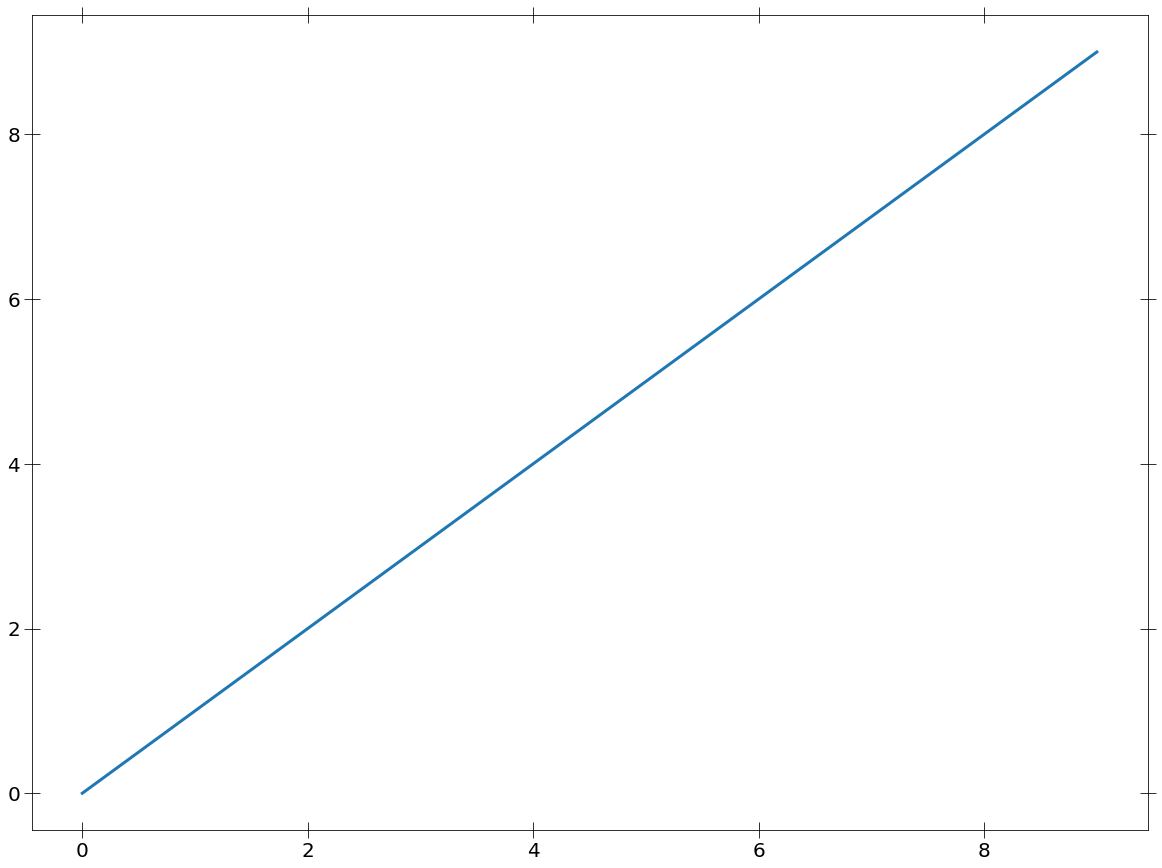

In [8]:
plt.plot(np.arange(10))

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:486: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:487: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:573: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:574: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

12.0


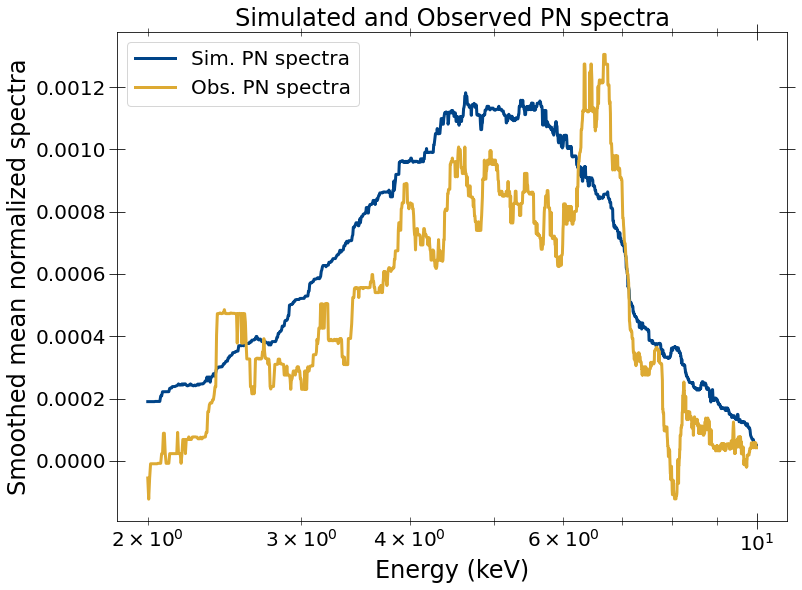

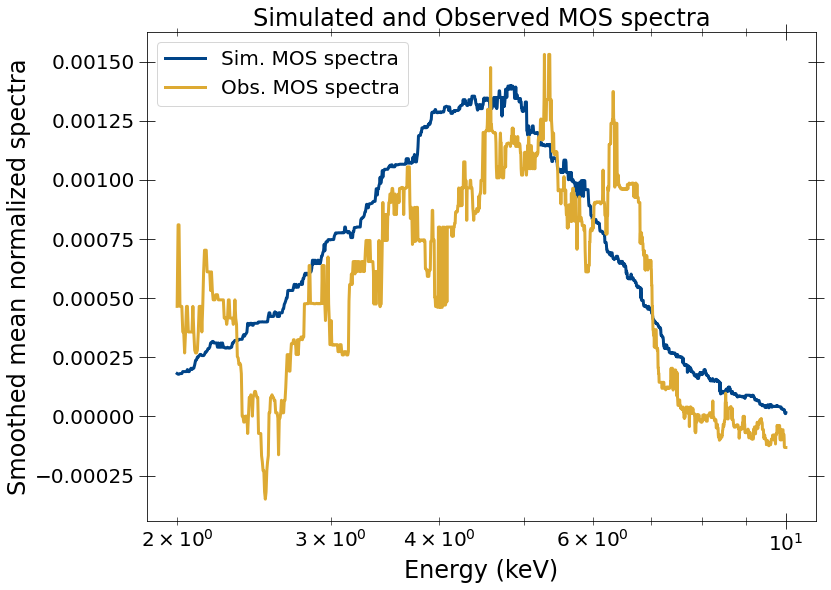

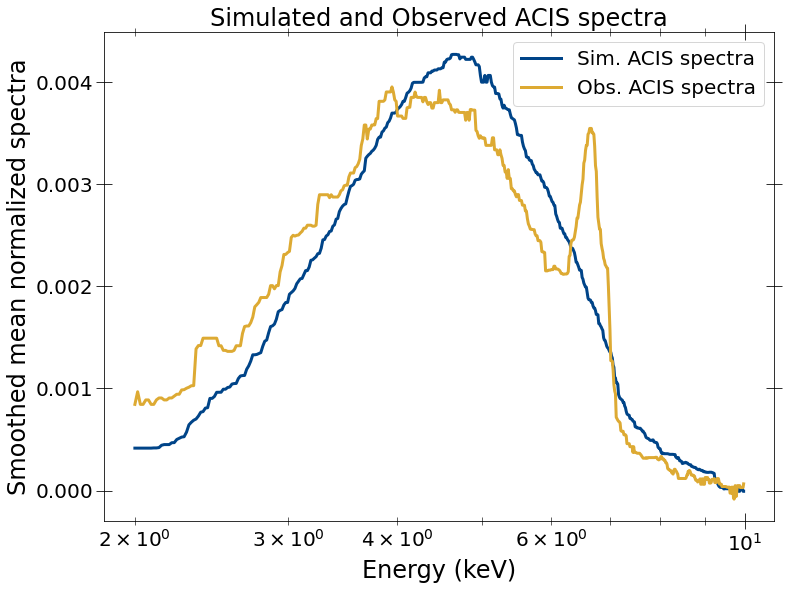

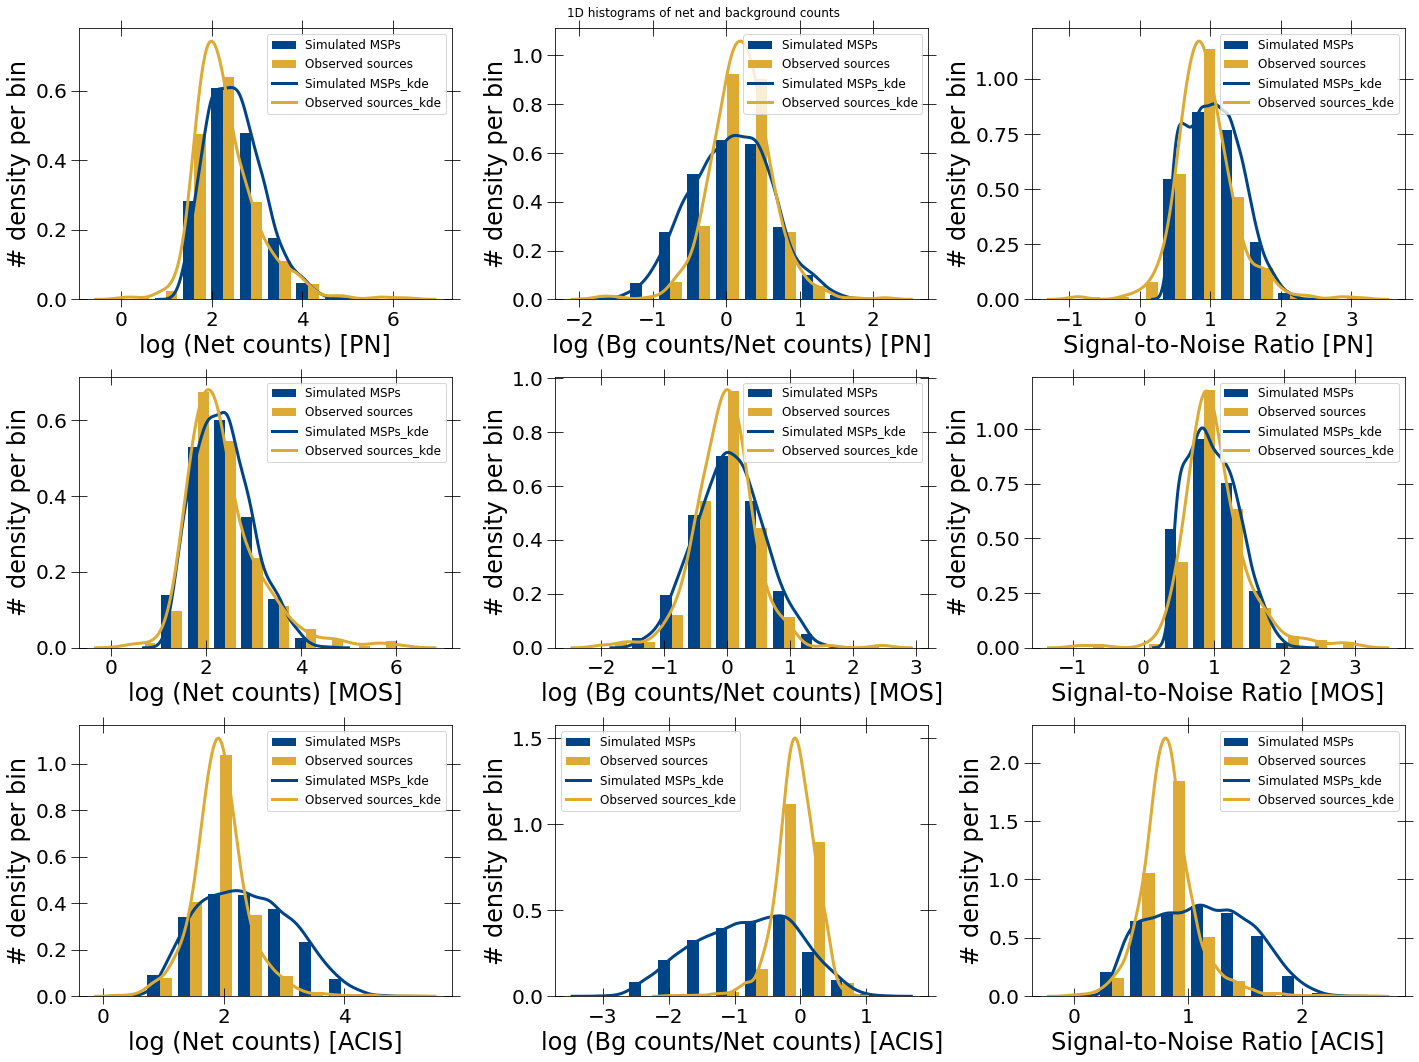

In [9]:
spec_summary = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path, xmm_sim_path, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[2, 10])

4488 4488 4488 4488
504 504 504 504


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: invalid value encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
2358 2358 2358 2358
292 292 292 292
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: invalid value encountered in true_divide


7337 7337 7337 7337
2064 2064 2064 2064


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: invalid value encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
16.0
16.0
16.0


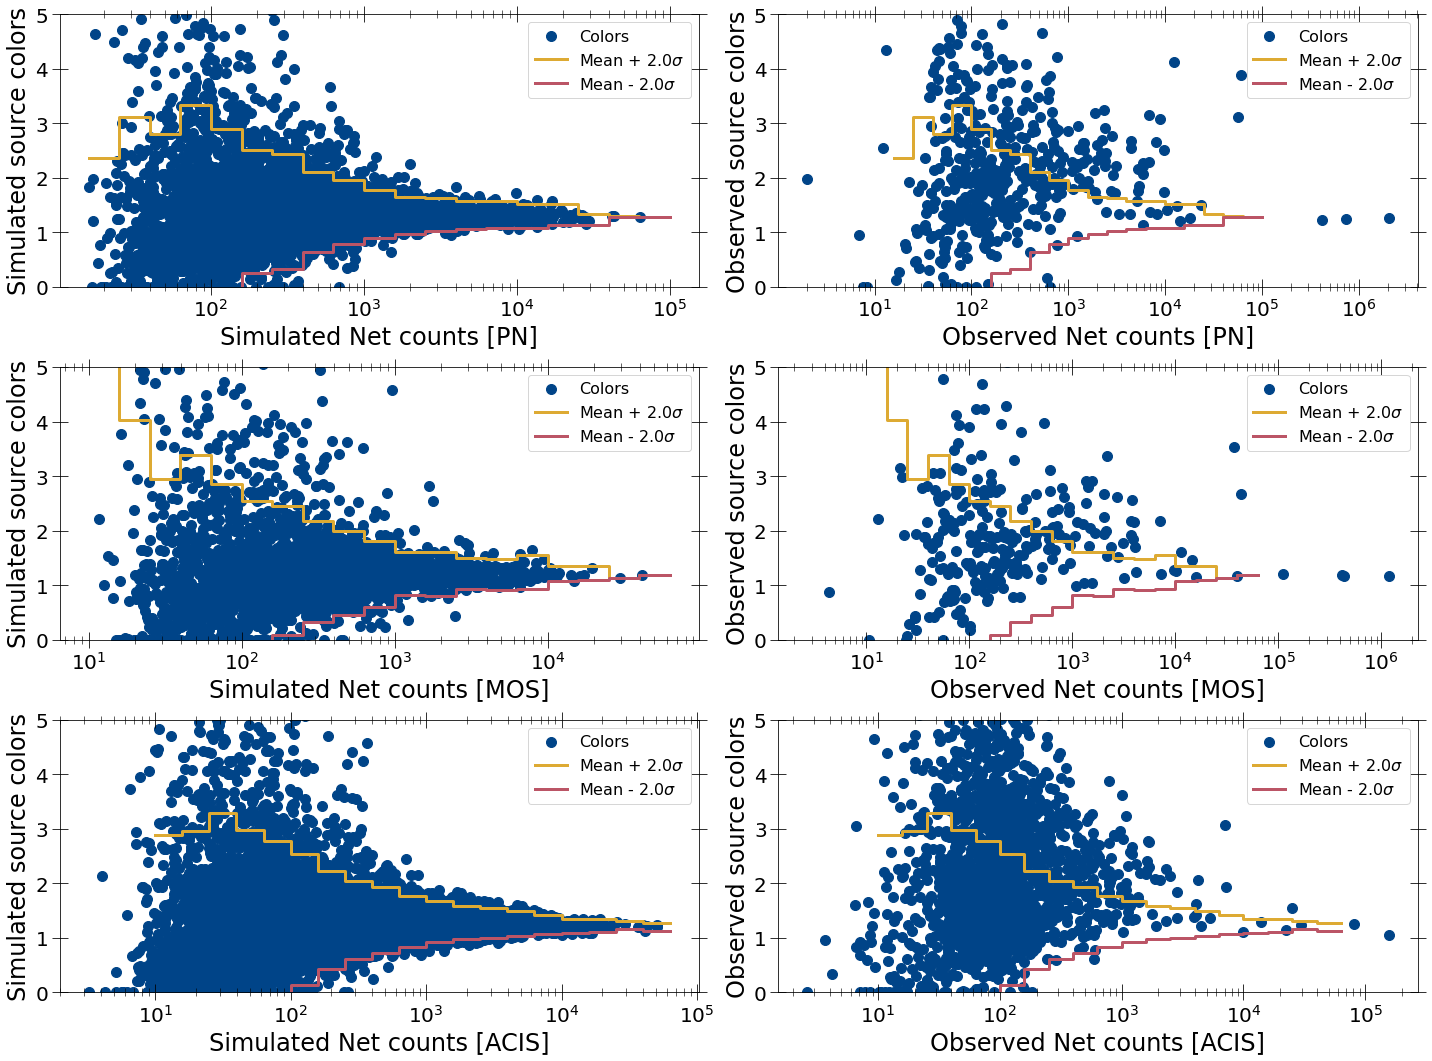

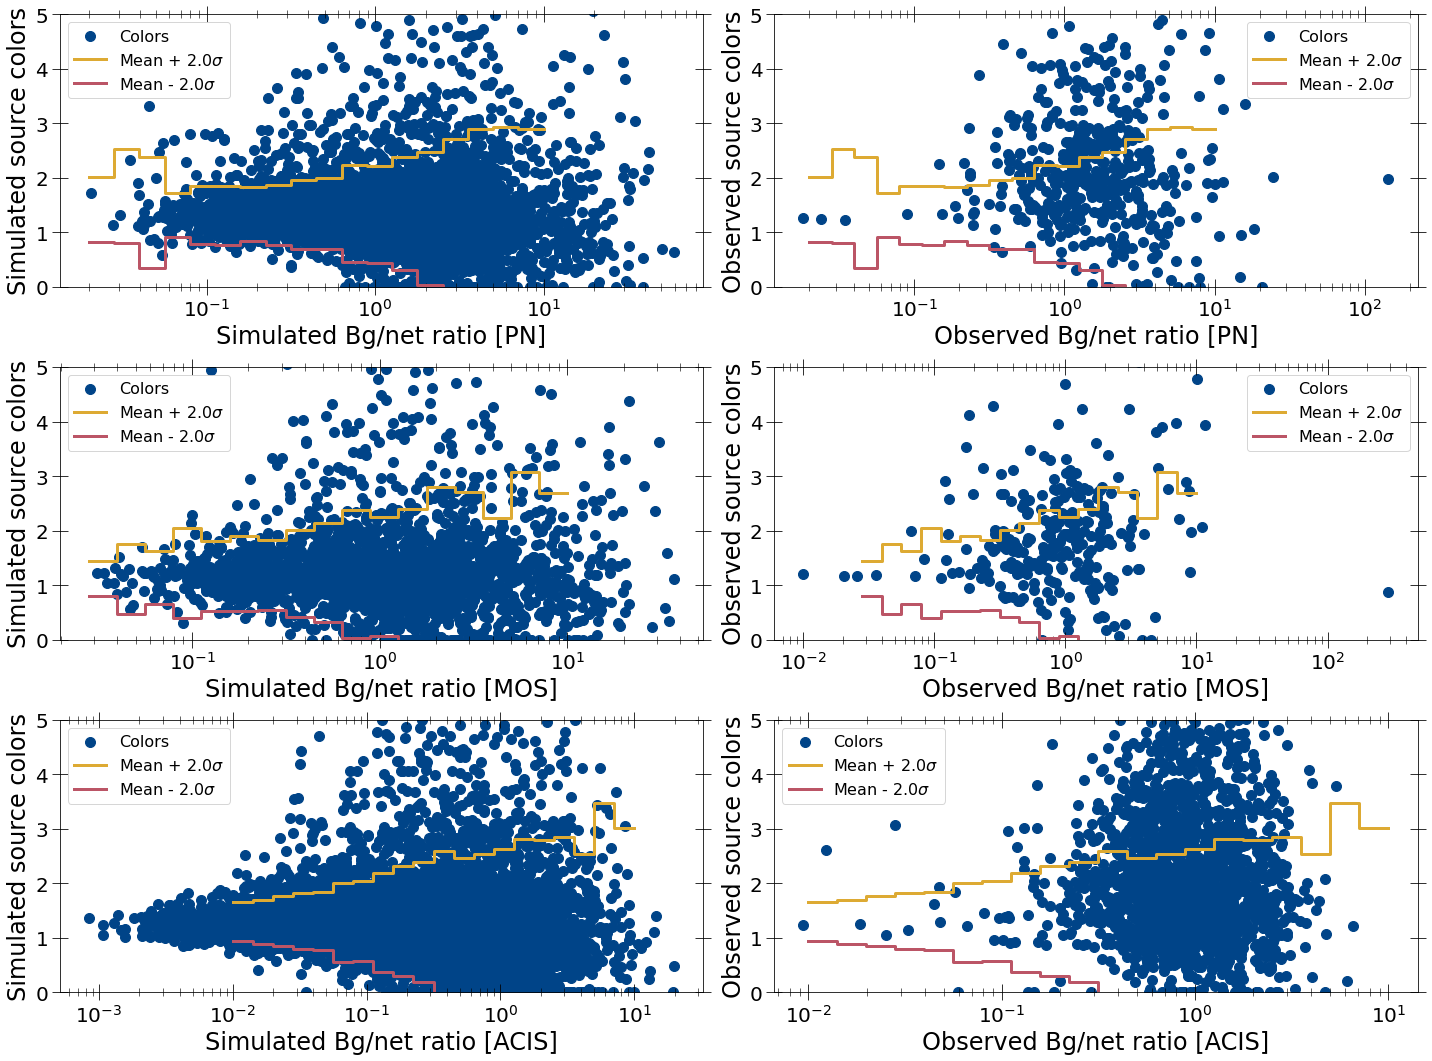

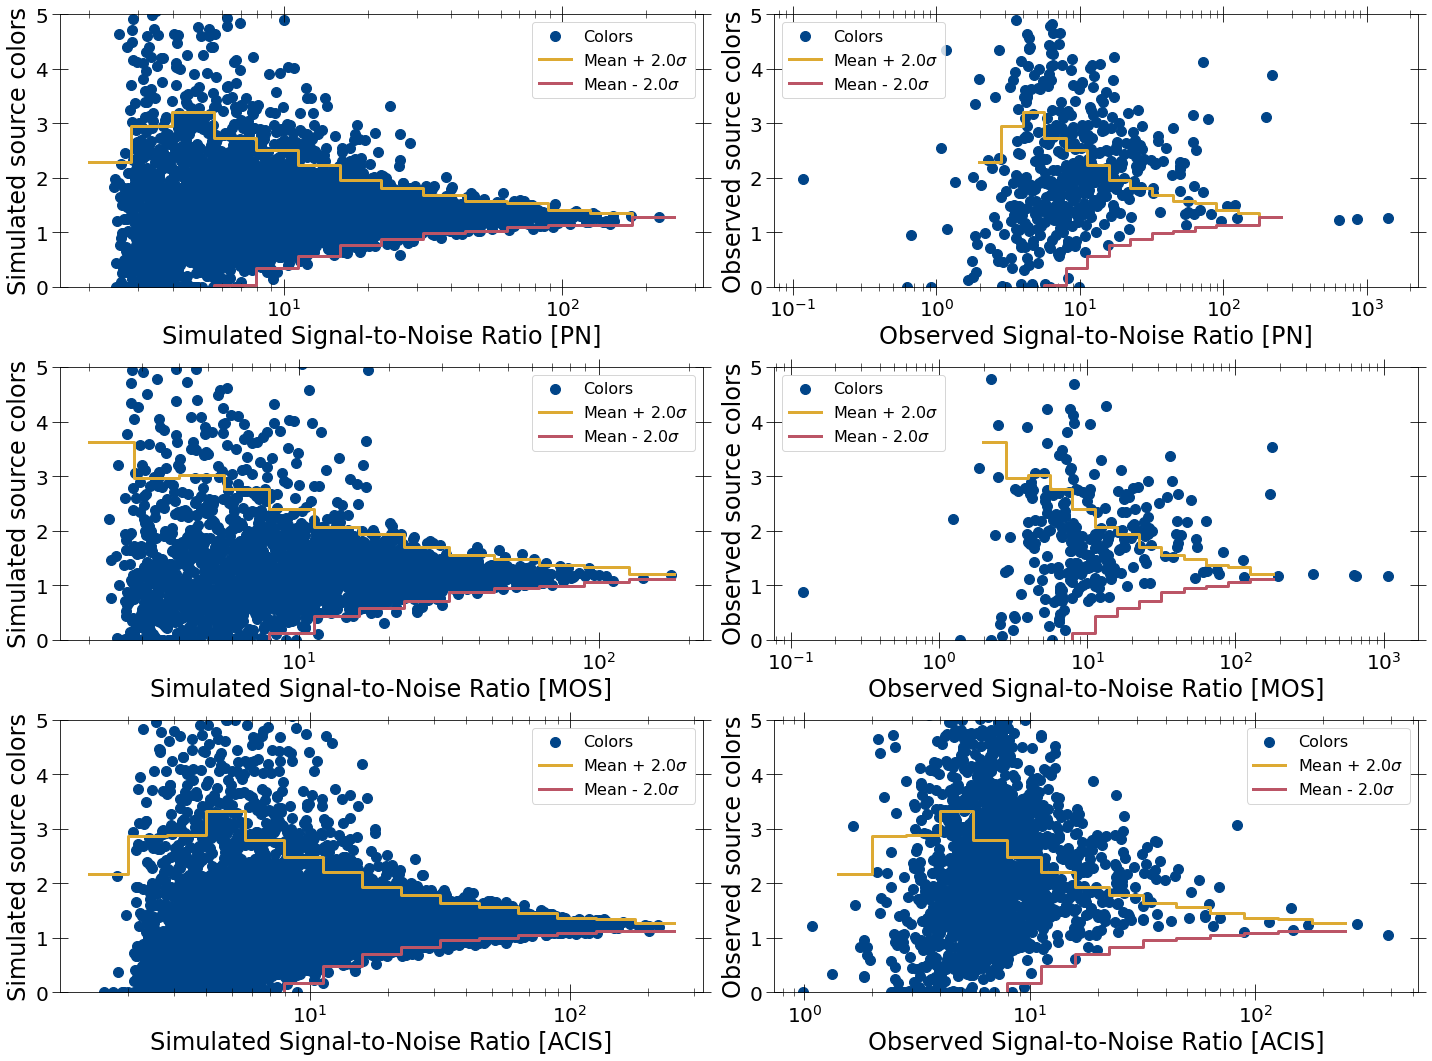

In [20]:
sim_color_dict_arr_clipped, obs_color_dict_arr_clipped = getcolor_prop_alldet(spec_summary, compare_det=True)

4488 4488 4488 4488
504 504 504 504


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: invalid value encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
2358 2358 2358 2358
292 292 292 292
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
7337 7337 7337 7337
2064 2064 2064 2064
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: invalid value encountered in true_divide


16.0
16.0
16.0


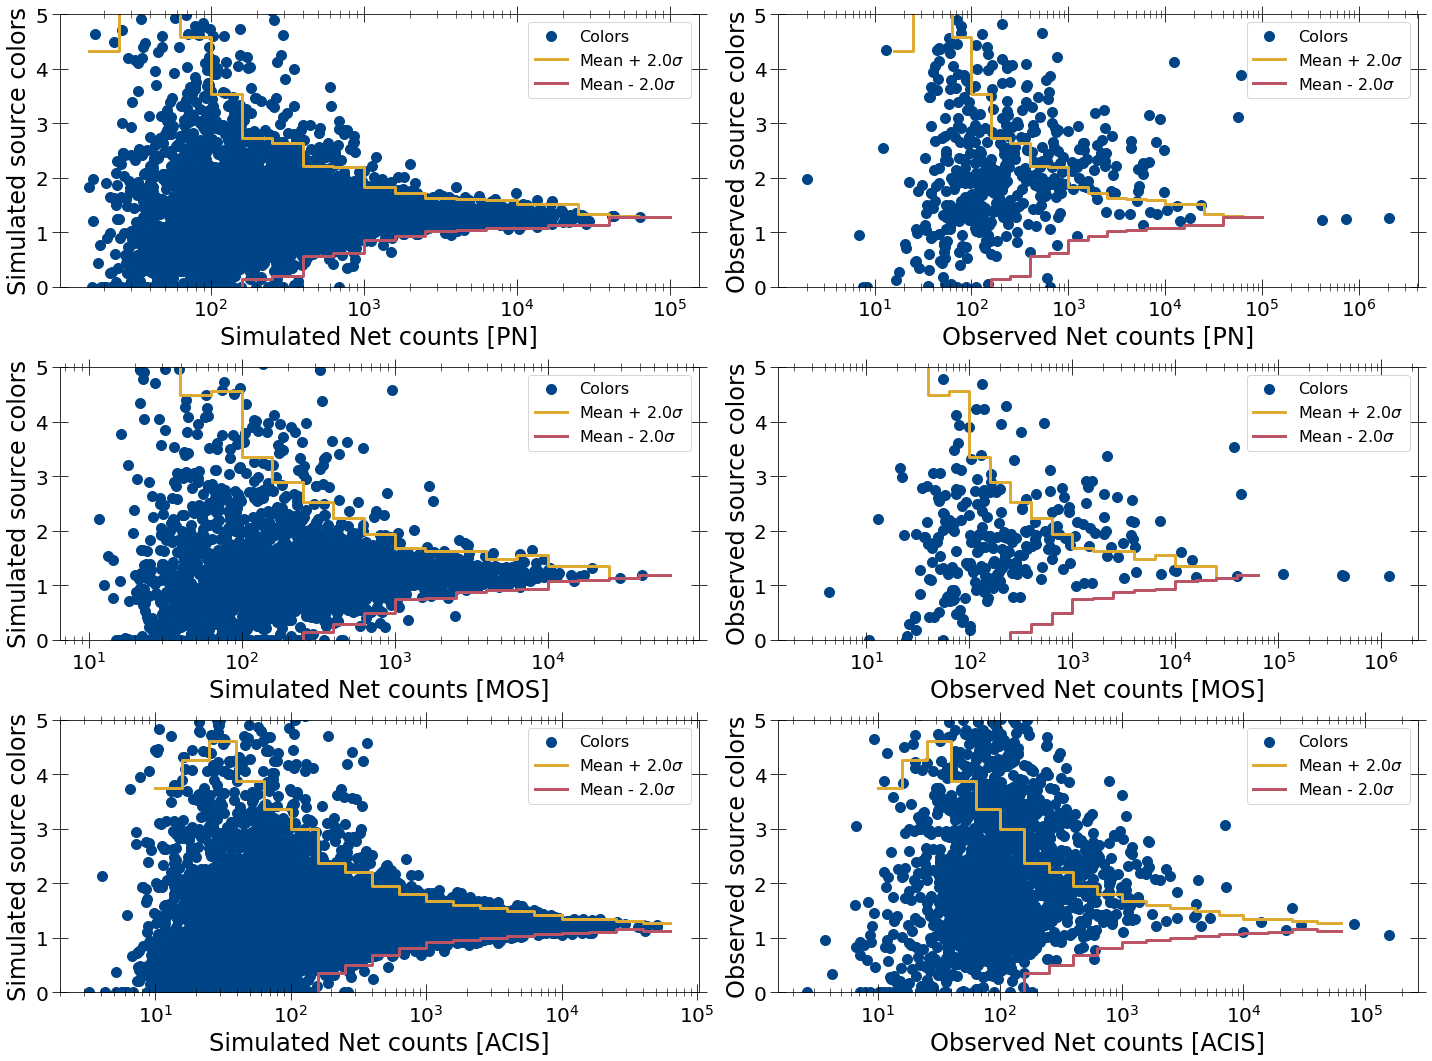

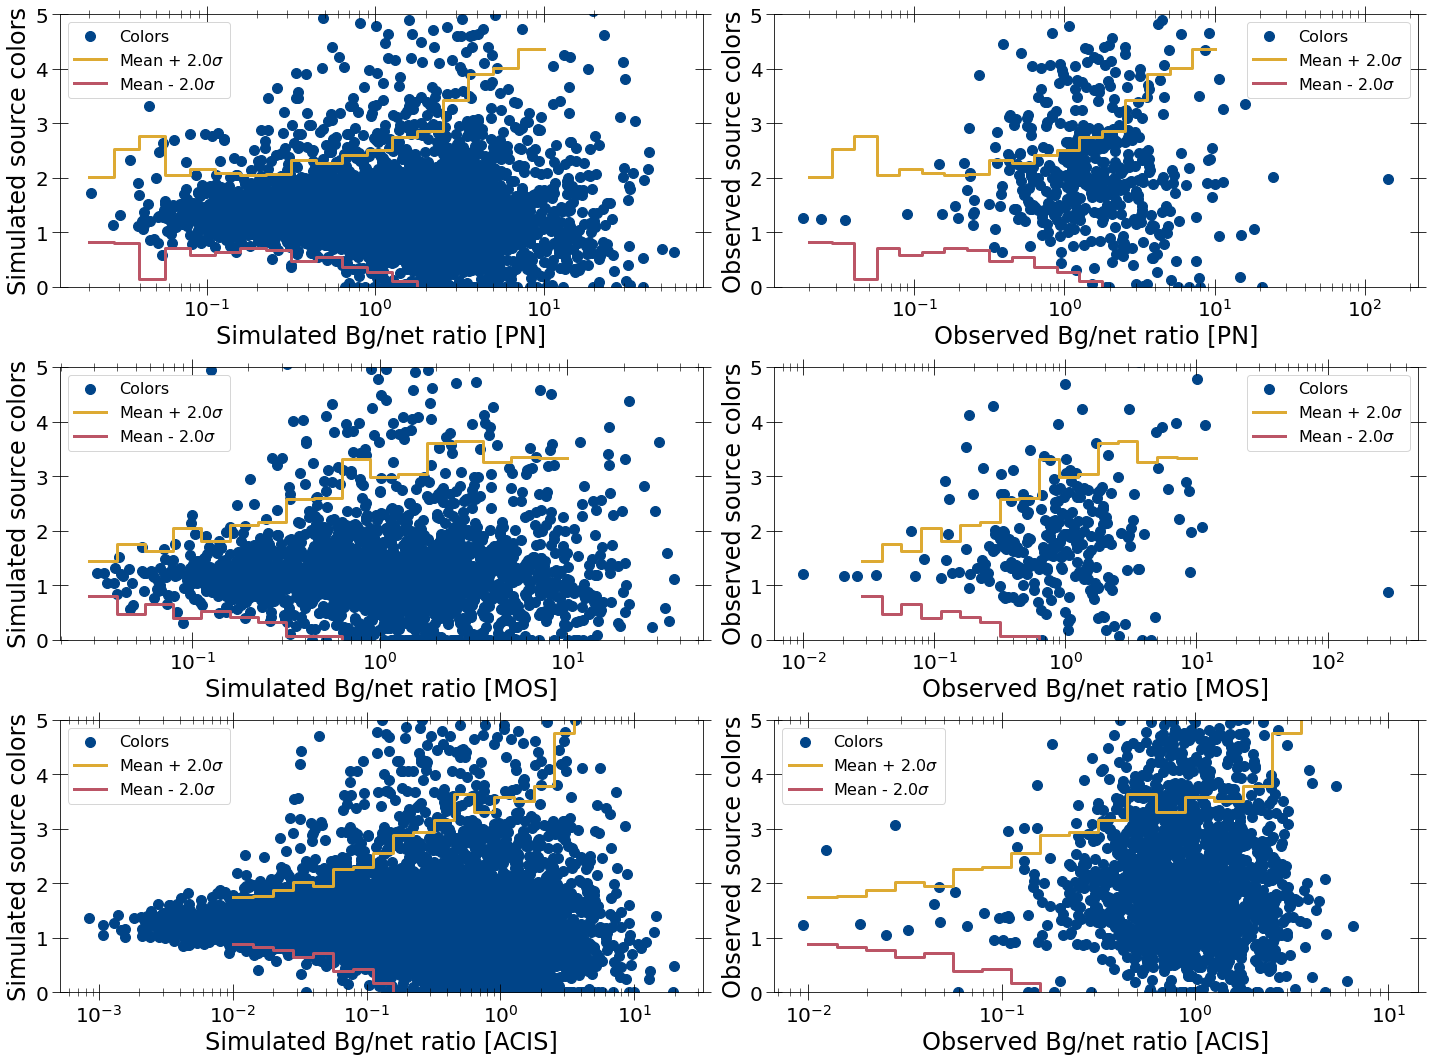

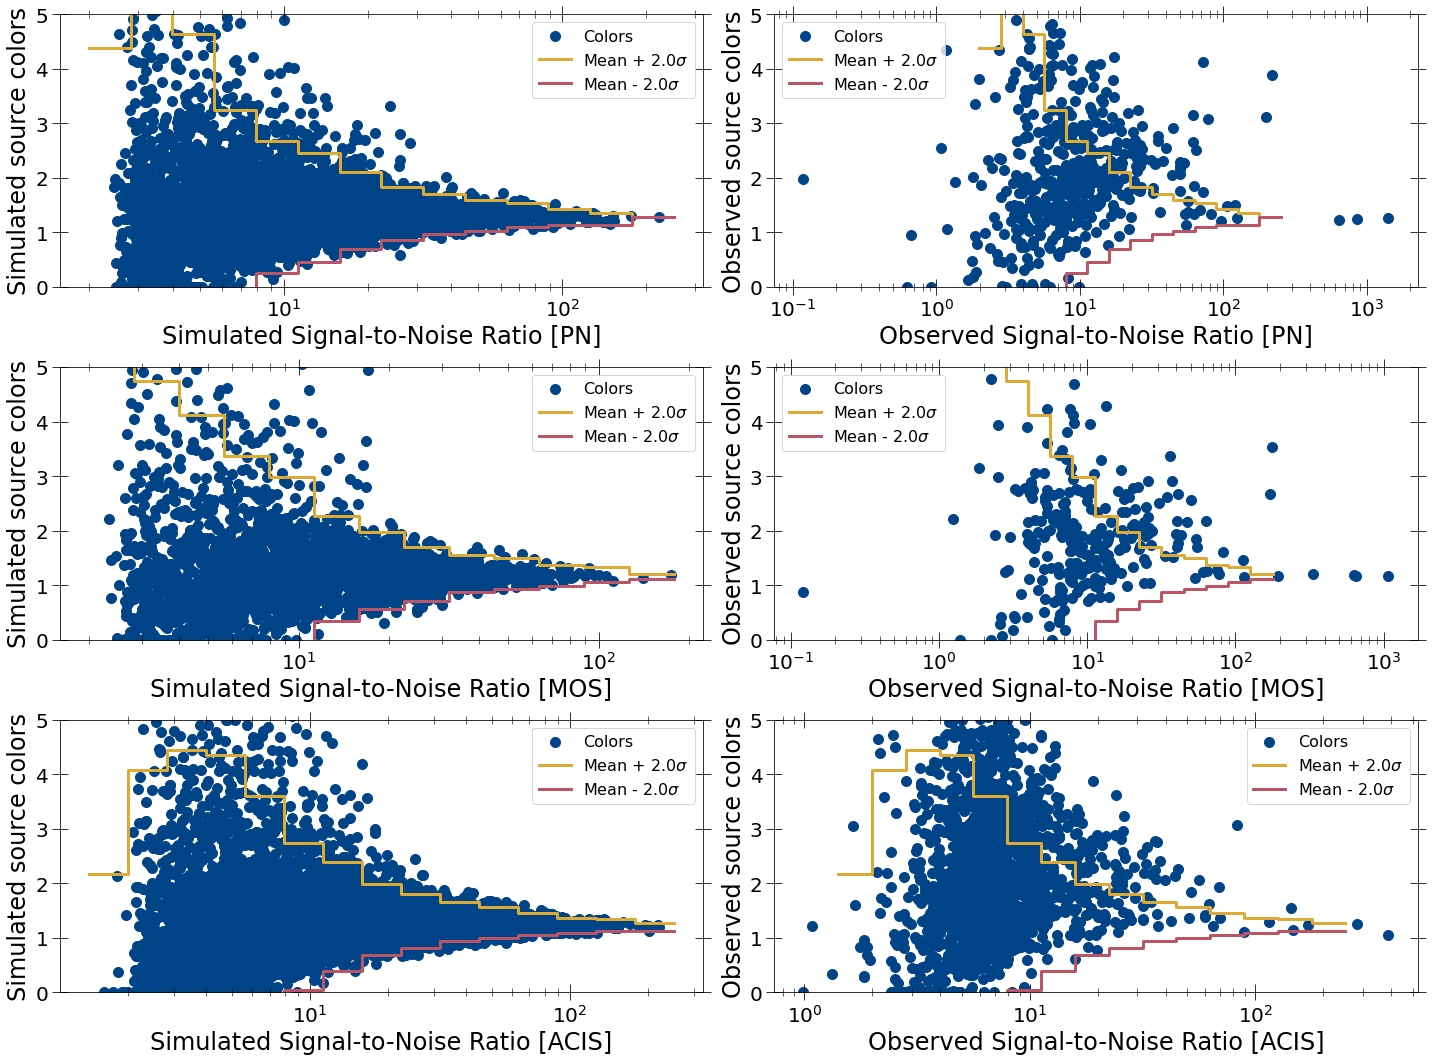

In [11]:
sim_color_dict_arr, obs_color_dict_arr = getcolor_prop_alldet(spec_summary, compare_det=True)

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:486: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:487: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:573: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:574: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

12.0


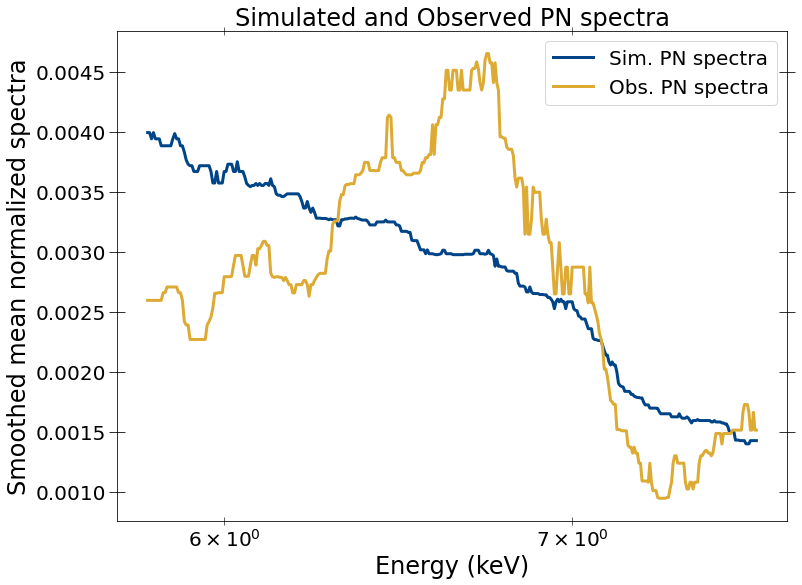

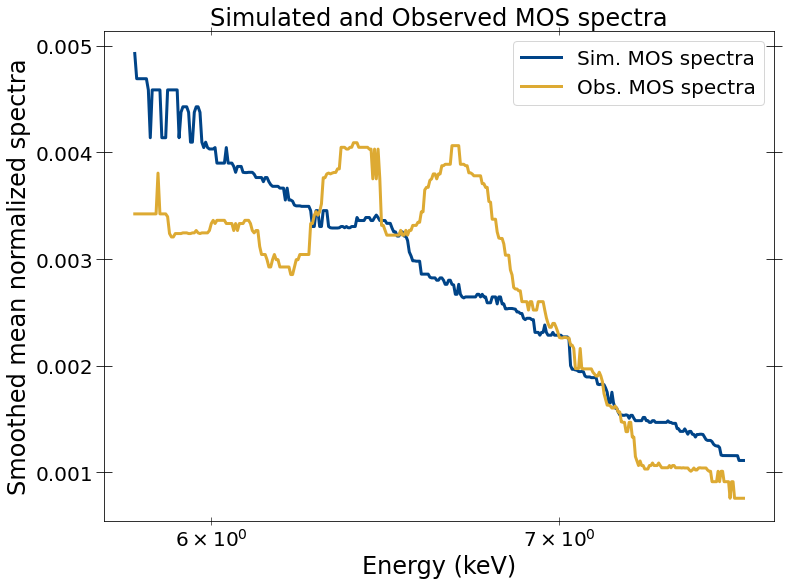

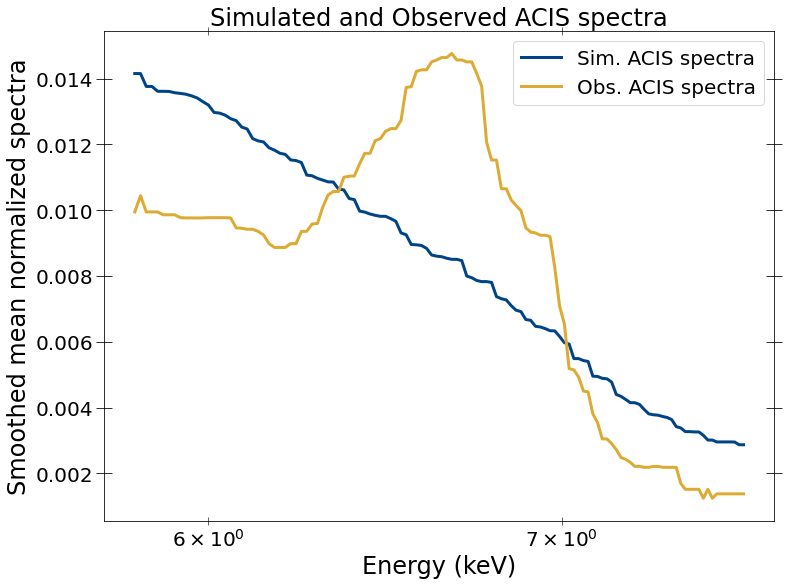

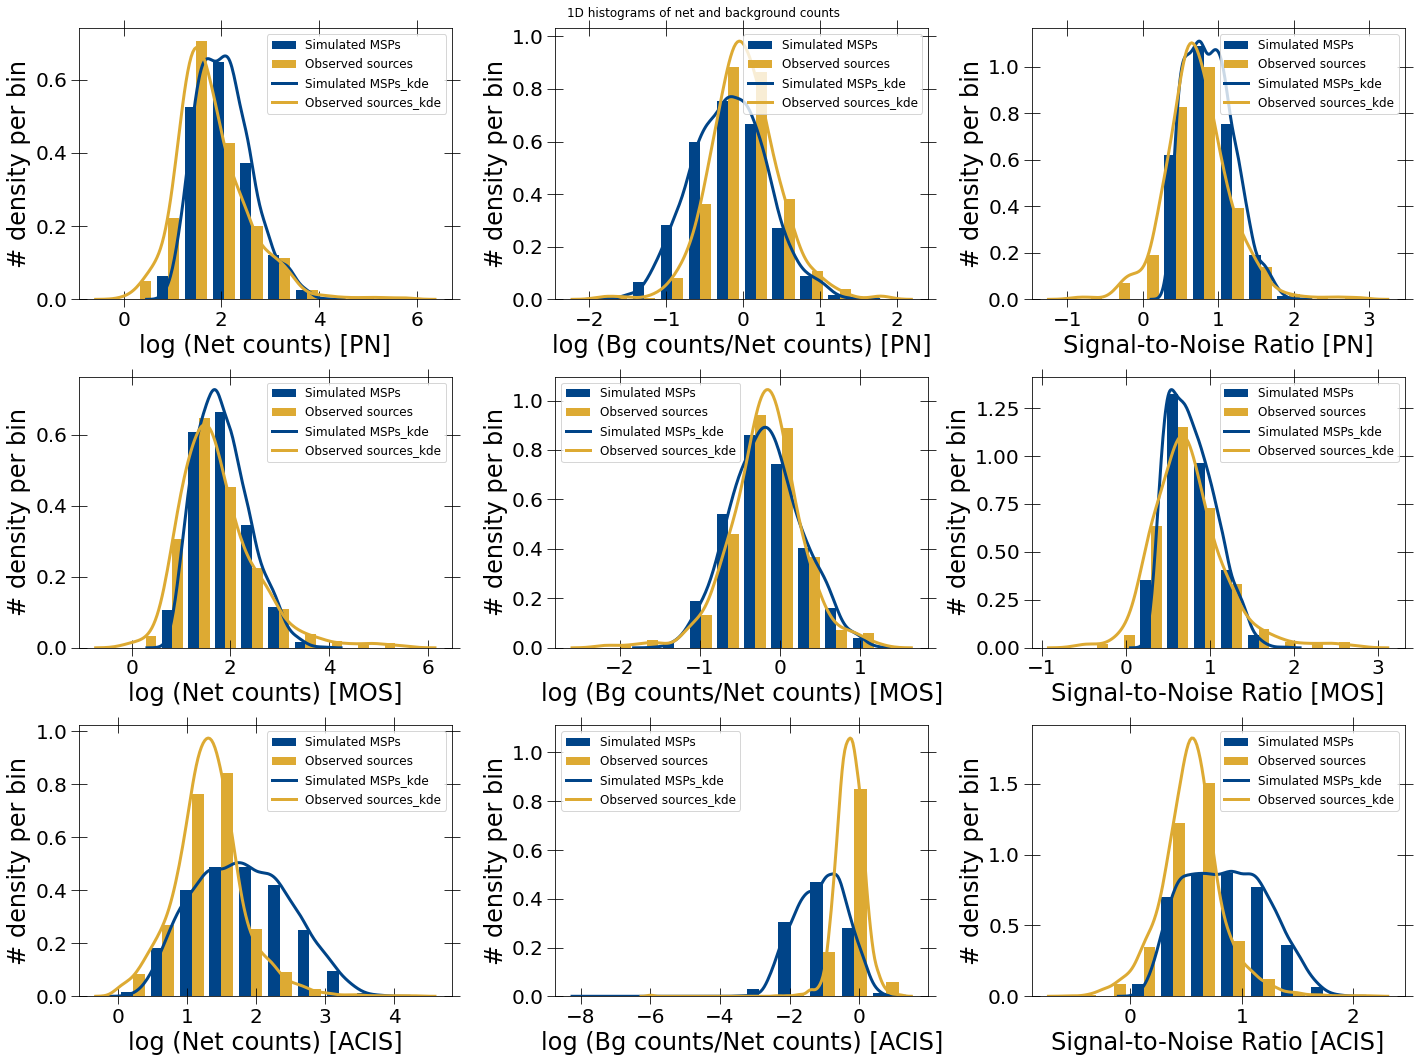

In [12]:
spec_summary2 = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path, xmm_sim_path, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[5.8, 7.6])

3870 3870 3870 3870
503 503 503 503


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
1825 1825 1825 1825
290 290 290 290
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
6563 6563 6563 6563
2009 2009 2009 2009
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide


16.0
16.0
16.0


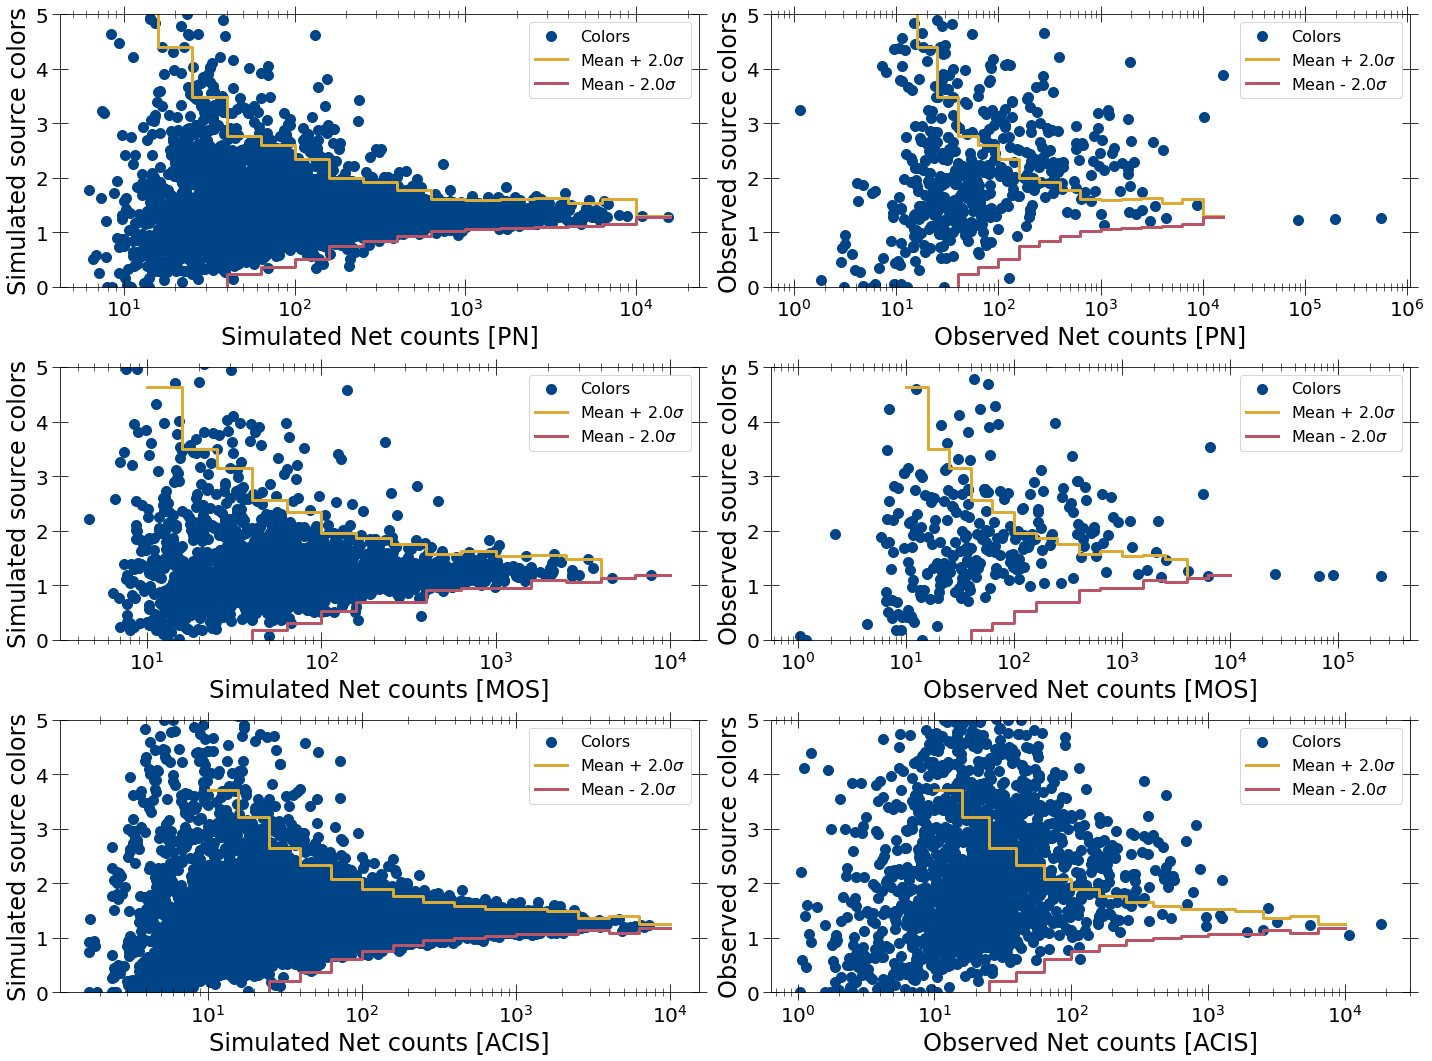

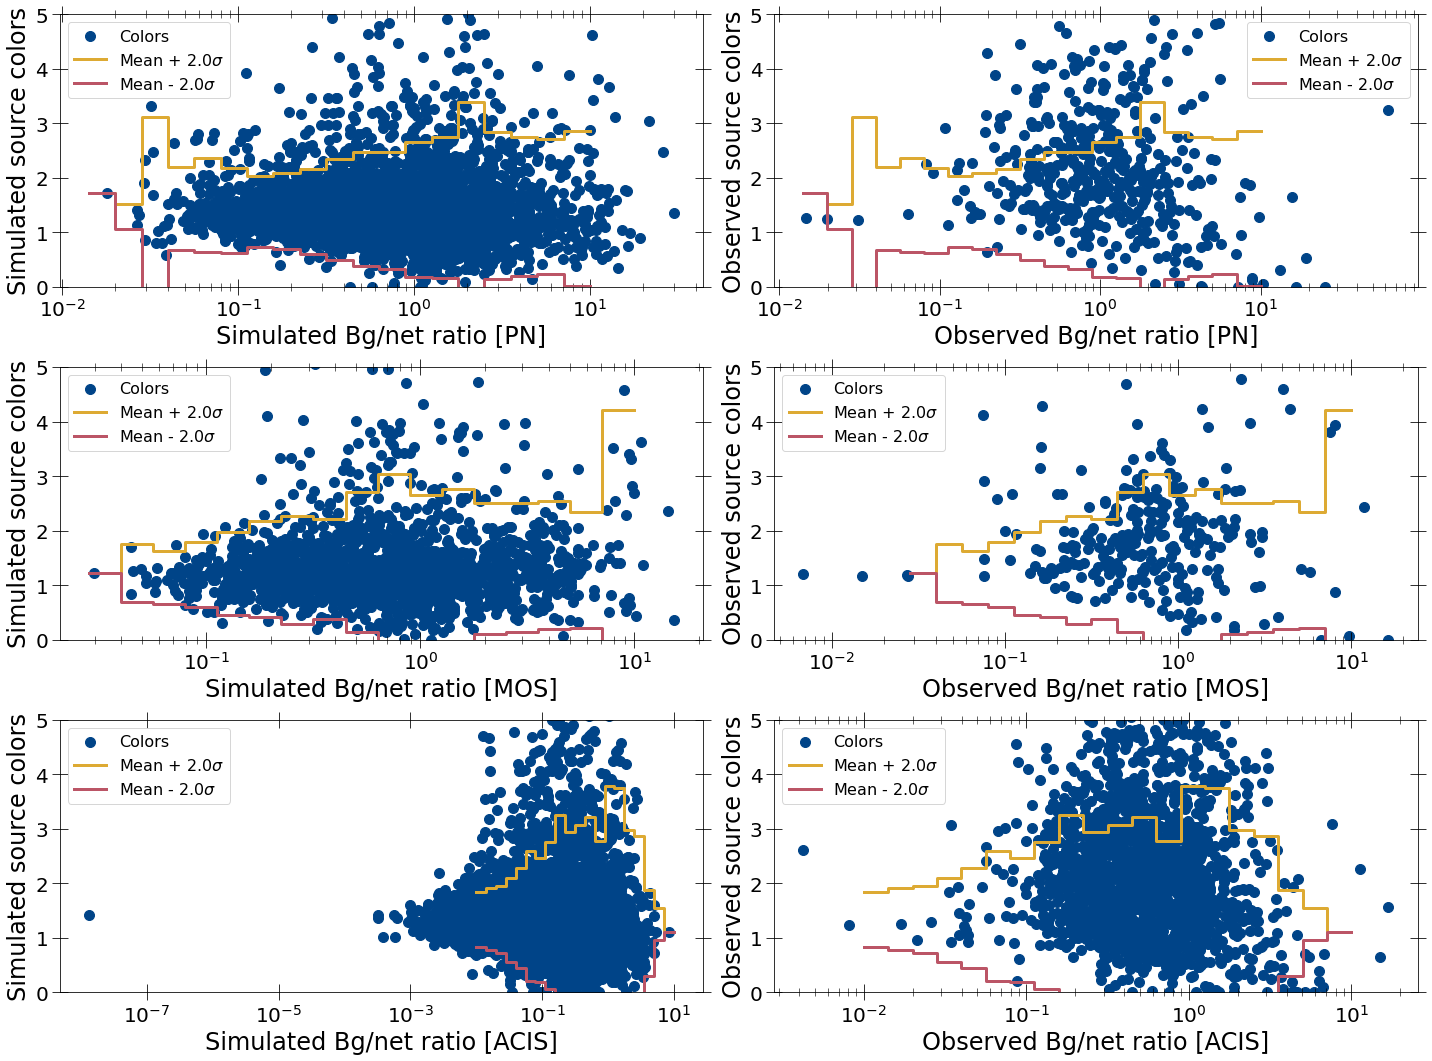

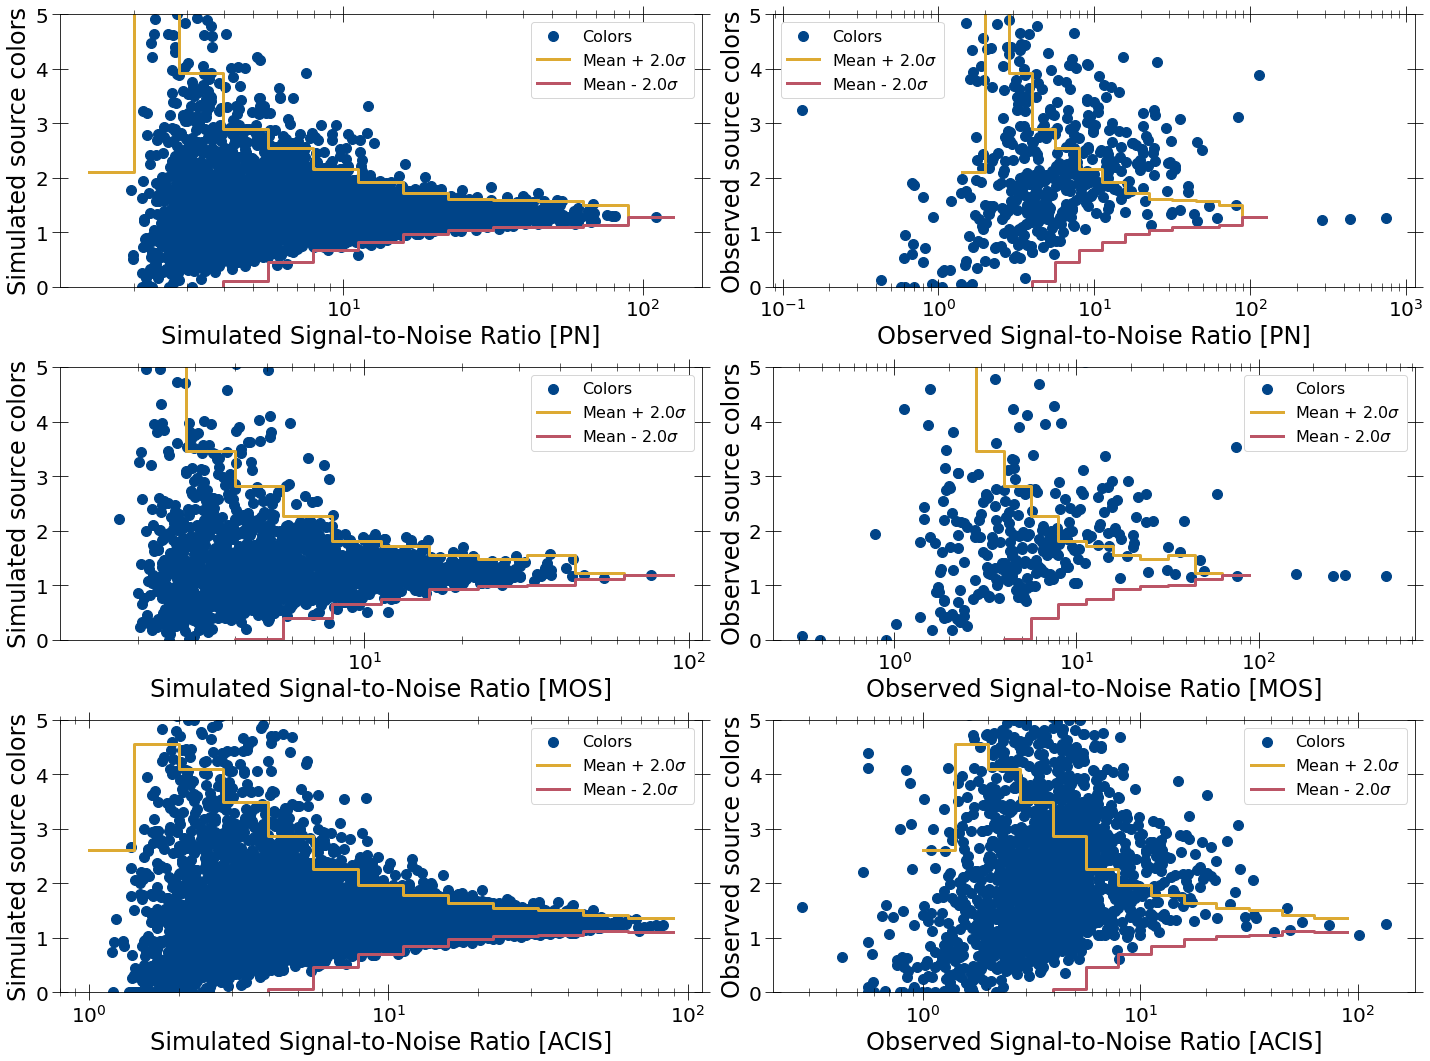

In [13]:
sim_color_dict_arr2, obs_color_dict_arr2 = getcolor_prop_alldet(spec_summary2, compare_det=True)

In [14]:
def get_candidate_src_nums_det(obs_src_nums, obs_det_mask, sim_color_dict,
                               obs_color_dict, min_counts):
    """Get src nums of quiescent sources for given detector"""
    obs_netcounts = obs_color_dict['prop_list'][0]
    netcount_bins = sim_color_dict['prop_bins'][0]
    obs_colors = obs_color_dict['colors']
    color_median = sim_color_dict['color_stat'][0][0]
    color_std = sim_color_dict['color_stat'][2][0]
    print(netcount_bins)
    print(color_median)
    print(color_std)
    interested_args = None
    for i, lower_bin in enumerate(netcount_bins):
        if lower_bin < min_counts:
            continue
        if i == len(netcount_bins) - 1:
            upper_bin = np.max(obs_netcounts) + 10
            median_color = color_median[-1]
            std_color = color_std[-1]
        else:
            upper_bin = netcount_bins[i+1]
            median_color = color_median[i]
            std_color = color_std[i]
        print(lower_bin, median_color + 2*std_color)
        if np.isnan(median_color) or np.isnan(std_color):
                    int_args = np.where(np.logical_and(
                        obs_netcounts >= lower_bin,
                        obs_netcounts < upper_bin))
        else:
        
            int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        print(len(int_args))
        if interested_args is None:
            interested_args = int_args.copy()
        else:
            interested_args = np.append(interested_args.copy(), int_args)
    return interested_args, obs_src_nums[obs_det_mask][interested_args]


def get_candidate_src_nums_alldet(spec_summary, sim_color_dict_arr,
                                  obs_color_dict_arr, min_count_arr=None):
    """Get source nums for all detectors."""
    interested_args_alldet = []
    interested_sources_alldet = []
    if min_count_arr is None:
        min_count_arr = [700, 700, 250]
    for i, obs_color_dict in enumerate(obs_color_dict_arr):
        if i > 0:
            interested_args, interested_srcs = get_candidate_src_nums_det(
                spec_summary['src_nums'][i-1], spec_summary['spec_masks'][1][i],
                sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        else:
            interested_args, interested_srcs = get_candidate_src_nums_det(
            spec_summary['src_nums'][i], spec_summary['spec_masks'][1][i],
            sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        interested_args_alldet.append(interested_args)
        interested_sources_alldet.append(interested_srcs)
    return interested_args_alldet, interested_sources_alldet


26:21: E117 over-indented
30:1: W293 blank line contains whitespace
59:80: E501 line too long (80 > 79 characters)
63:13: E122 continuation line missing indentation or outdented
64:13: E122 continuation line missing indentation or outdented


In [23]:
interested_args_alldet2, interested_srcs_alldet2 = get_candidate_src_nums_alldet(spec_summary2, sim_color_dict_arr2,
                              obs_color_dict_arr2, min_count_arr=[39, 39, 39])

1:80: E501 line too long (116 > 79 characters)
2:31: E128 continuation line under-indented for visual indent


[1.00000000e+01 1.58489319e+01 2.51188643e+01 3.98107171e+01
 6.30957344e+01 1.00000000e+02 1.58489319e+02 2.51188643e+02
 3.98107171e+02 6.30957344e+02 1.00000000e+03 1.58489319e+03
 2.51188643e+03 3.98107171e+03 6.30957344e+03 1.00000000e+04
 1.58489319e+04 2.51188643e+04 3.98107171e+04 6.30957344e+04
 1.00000000e+05]
[2.00871979 1.7233524  1.5884483  1.49984145 1.47657724 1.42700144
 1.37002768 1.37766632 1.3549527  1.31473815 1.3277049  1.34477512
 1.36440991 1.32344936 1.38813392 1.29134765        nan        nan
        nan        nan]
[2.15764413 1.33454851 0.94985389 0.63579873 0.55878543 0.46227994
 0.31535606 0.2693783  0.20954657 0.15002738 0.13145494 0.13485116
 0.13204202 0.10544924 0.1155218  0.00488405        nan        nan
        nan        nan]
39.810717055349734 2.771438918519578
45
63.09573444801933 2.5941481083118716
39
100.0 2.3515613172342045
17
158.48931924611142 2.000739807953098
14
251.18864315095823 1.9164229169949565
6
398.1071705534973 1.774045843293957
2
63

In [24]:
interested_args_alldet, interested_srcs_alldet = get_candidate_src_nums_alldet(spec_summary, sim_color_dict_arr,
                              obs_color_dict_arr, min_count_arr=[150, 150, 150])

1:80: E501 line too long (112 > 79 characters)
2:31: E128 continuation line under-indented for visual indent


[1.00000000e+01 1.58489319e+01 2.51188643e+01 3.98107171e+01
 6.30957344e+01 1.00000000e+02 1.58489319e+02 2.51188643e+02
 3.98107171e+02 6.30957344e+02 1.00000000e+03 1.58489319e+03
 2.51188643e+03 3.98107171e+03 6.30957344e+03 1.00000000e+04
 1.58489319e+04 2.51188643e+04 3.98107171e+04 6.30957344e+04
 1.00000000e+05]
[       nan 1.2687122  1.57780052 1.70915961 1.72618644 1.55048851
 1.4340423  1.42124175 1.394855   1.40755973 1.34409077 1.31995169
 1.32216643 1.32350378 1.33359872 1.30127259 1.3196426  1.23300753
 1.2935751  1.2864636 ]
[       nan 1.53260585 1.86990841 1.81391648 1.43103604 0.9968727
 0.64695942 0.6082106  0.41238333 0.39253497 0.23961263 0.19736298
 0.15092732 0.13924128 0.13023717 0.10790615 0.09740043 0.04973127
 0.0026566  0.        ]
158.48931924611142 2.7279611457493704
44
251.18864315095823 2.637662941671821
24
398.1071705534973 2.2196216611557893
18
630.957344480193 2.192629679023936
15
1000.0 1.8233160286795935
2
1584.893192461114 1.7146776386488467
2
251

In [26]:
len(np.sort(interested_srcs_alldet[0]))

119

In [76]:
np.sort(interested_srcs_alldet[2])

array(['2CXOJ174502.3-285449', '2CXOJ174503.8-290051',
       '2CXOJ174503.9-290139', '2CXOJ174507.0-290357',
       '2CXOJ174508.6-285652', '2CXOJ174508.6-285939',
       '2CXOJ174508.7-290325', '2CXOJ174509.1-290245',
       '2CXOJ174509.2-285702', '2CXOJ174511.6-285121',
       '2CXOJ174511.8-290032', '2CXOJ174512.3-285901',
       '2CXOJ174512.5-285923', '2CXOJ174512.8-290340',
       '2CXOJ174512.9-285844', '2CXOJ174513.0-290229',
       '2CXOJ174513.9-285916', '2CXOJ174514.1-285425',
       '2CXOJ174515.1-290016', '2CXOJ174516.0-290031',
       '2CXOJ174516.1-290425', '2CXOJ174516.8-290541',
       '2CXOJ174517.0-285419', '2CXOJ174518.2-285756',
       '2CXOJ174518.4-290212', '2CXOJ174518.6-290010',
       '2CXOJ174519.3-290441', '2CXOJ174520.5-290346',
       '2CXOJ174520.5-290501', '2CXOJ174520.8-285448',
       '2CXOJ174523.2-290034', '2CXOJ174523.2-290638',
       '2CXOJ174523.3-285545', '2CXOJ174523.8-290653',
       '2CXOJ174524.3-285705', '2CXOJ174525.2-285404',
       '2C

In [51]:
def mark_interested_srcs(sim_color_dict, obs_color_dict, src_nums, obs_mask,
                         interested_srcs, prop_num=0):
    props = obs_color_dict['prop_list'][prop_num]
    colors = obs_color_dict['colors']
    interested_args = np.where(np.isin(src_nums[obs_mask], interested_srcs))
    print(interested_args)
    prop_bins = sim_color_dict['prop_bins'][prop_num]
    mean_color = sim_color_dict['color_stat'][0][prop_num]
    std_color = sim_color_dict['color_stat'][2][prop_num]
    plotline_scatter([props, props[interested_args], prop_bins, prop_bins],
                     [colors, colors[interested_args], mean_color + 2*std_color,
                      mean_color - 2*std_color],
                     pl_types=['scatter', 'scatter', 'step', 'step'],
                     xlabel='Net counts', ylabel='Colors',
                     pl_labels=['Colors', 'Colors (candidates)',
                                r'Mean + 2$\sigma$', r'Mean + 2$\sigma$'],
                     ylim=(0, 5))

11:80: E501 line too long (80 > 79 characters)


In [23]:
np.where(spec_summary['src_nums'][0] == )

SyntaxError: invalid syntax (<ipython-input-23-8d0a30d54856>, line 1)

1:40: E202 whitespace before ')'
41: E999 SyntaxError: invalid syntax


Error before execution: invalid syntax (<ipython-input-23-8d0a30d54856>, line 1)


(array([  0,   3,   5,   7,   9,  10,  19,  20,  22,  24,  29,  31,  33,
        34,  35,  38,  40,  43,  44,  49,  50,  57,  58,  60,  67,  71,
        75,  79,  83,  84,  86,  90,  91,  93,  98, 105, 108, 110, 111,
       117, 121, 122, 124, 125, 127, 129, 133, 134, 137, 138, 140, 144,
       147, 148, 150, 152, 153, 160, 161, 162, 169, 172, 173, 177, 182,
       186, 187, 190, 191, 192, 194, 195, 196, 197, 198, 203, 204, 206,
       213, 214, 223, 229, 231, 232, 240, 252, 259, 261, 265, 266, 267,
       272, 273, 274, 275, 278, 283, 296, 300, 304, 305, 308, 309, 311,
       320, 329, 330, 336, 339, 342, 354, 356, 357, 364, 374, 376, 389,
       394, 396, 398, 409, 432, 441, 442, 443, 444, 449, 451, 464, 465,
       467, 471, 481, 482, 483, 484, 485, 488]),)


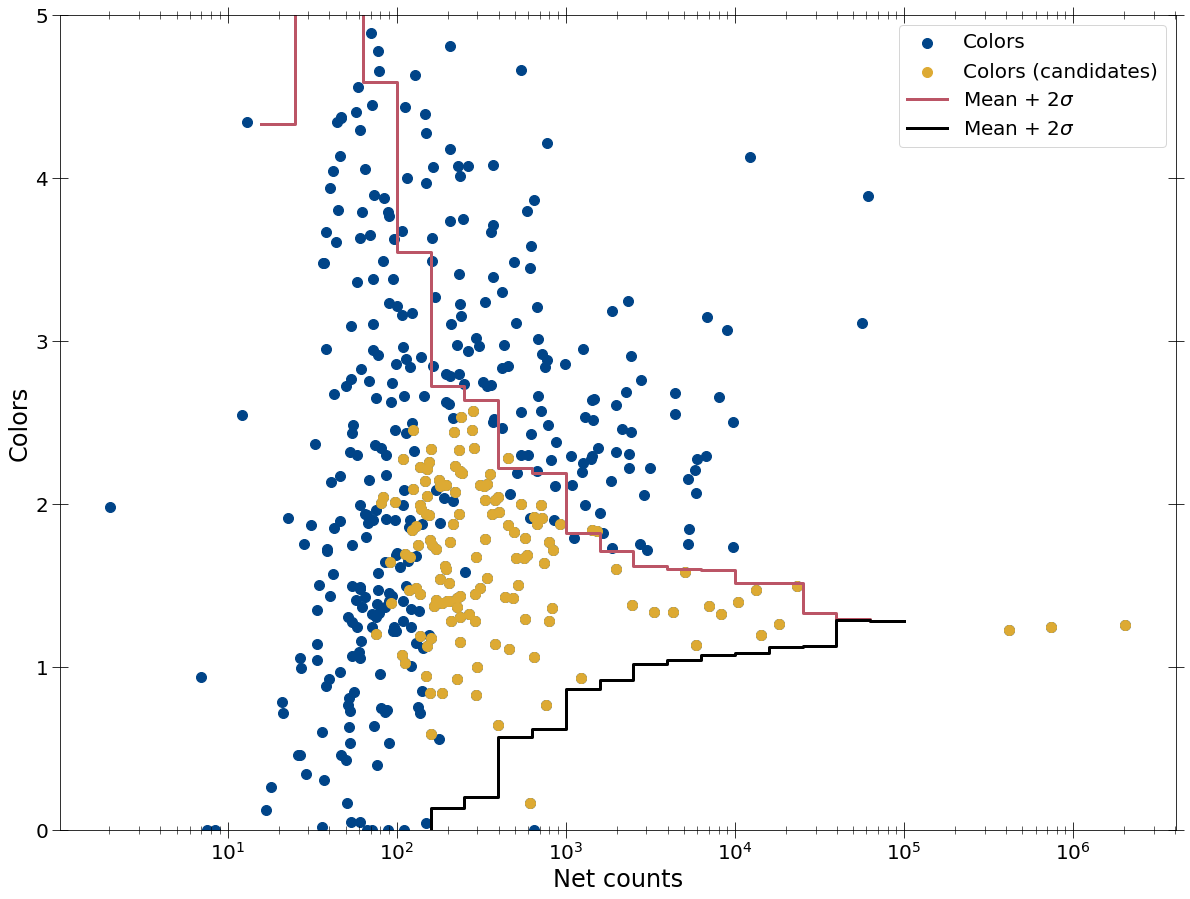

2:80: E501 line too long (83 > 79 characters)


In [52]:
mark_interested_srcs(sim_color_dict_arr[0], obs_color_dict_arr[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     interested_srcs_alldet2[0], 0)

(array([  2,   3,   6,  16,  21,  24,  29,  30,  33,  37,  44,  45,  51,
        53,  55,  56,  59,  66,  67,  72,  81,  84,  86,  93,  96, 103,
       110, 113, 122, 123, 125, 126, 130, 133, 136, 137, 139, 144, 146,
       151, 152, 154, 171, 181, 183, 185, 196, 198, 199, 200, 216, 220,
       221, 223, 224, 226, 229, 231, 234, 242, 243, 246, 253, 254, 261,
       272, 273, 280, 281, 287]),)


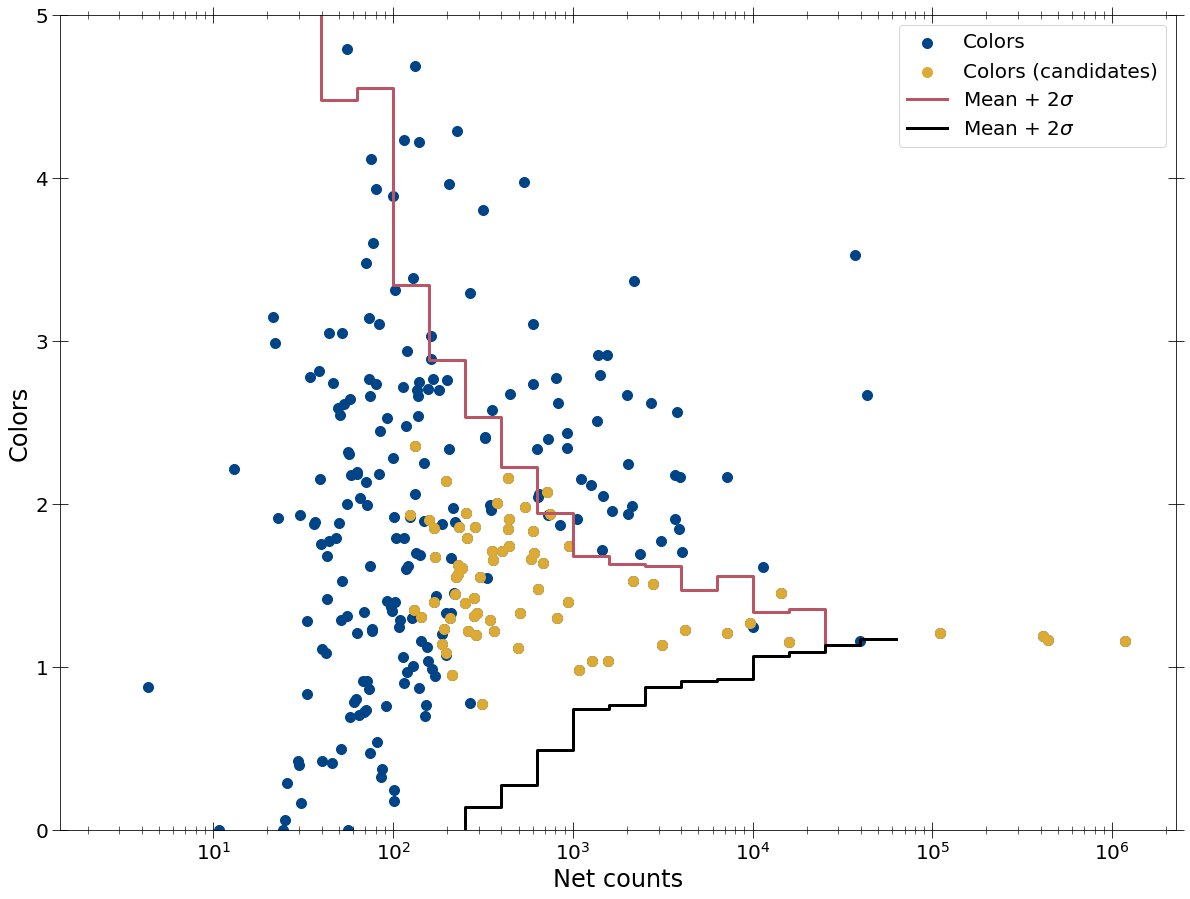

2:80: E501 line too long (83 > 79 characters)


In [53]:
mark_interested_srcs(sim_color_dict_arr[1], obs_color_dict_arr[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     interested_srcs_alldet2[1], 0)

In [59]:
len(interested_srcs_alldet[1])

89

(array([   1,    2,   63,   74,   82,  102,  133,  137,  156,  157,  162,
        234,  242,  249,  278,  282,  321,  345,  358,  376,  396,  401,
        416,  420,  453,  483,  500,  572,  622,  666,  674,  679,  685,
        709,  731,  733,  764,  780,  788,  797,  831,  840,  842,  849,
        883,  900,  910,  936,  945,  949,  951,  957,  961,  977,  990,
       1006, 1012, 1028, 1037, 1105, 1146, 1254, 1263, 1278, 1295, 1325,
       1388, 1394, 1408, 1422, 1424, 1429, 1507, 1522, 1527, 1562, 1571,
       1575, 1590, 1633, 1638, 1640, 1647, 1650, 1656, 1659, 1673, 1678,
       1741, 1756, 1767, 1793, 1827, 1863, 1885, 1901, 1934, 1944, 1956,
       1980, 2041]),)


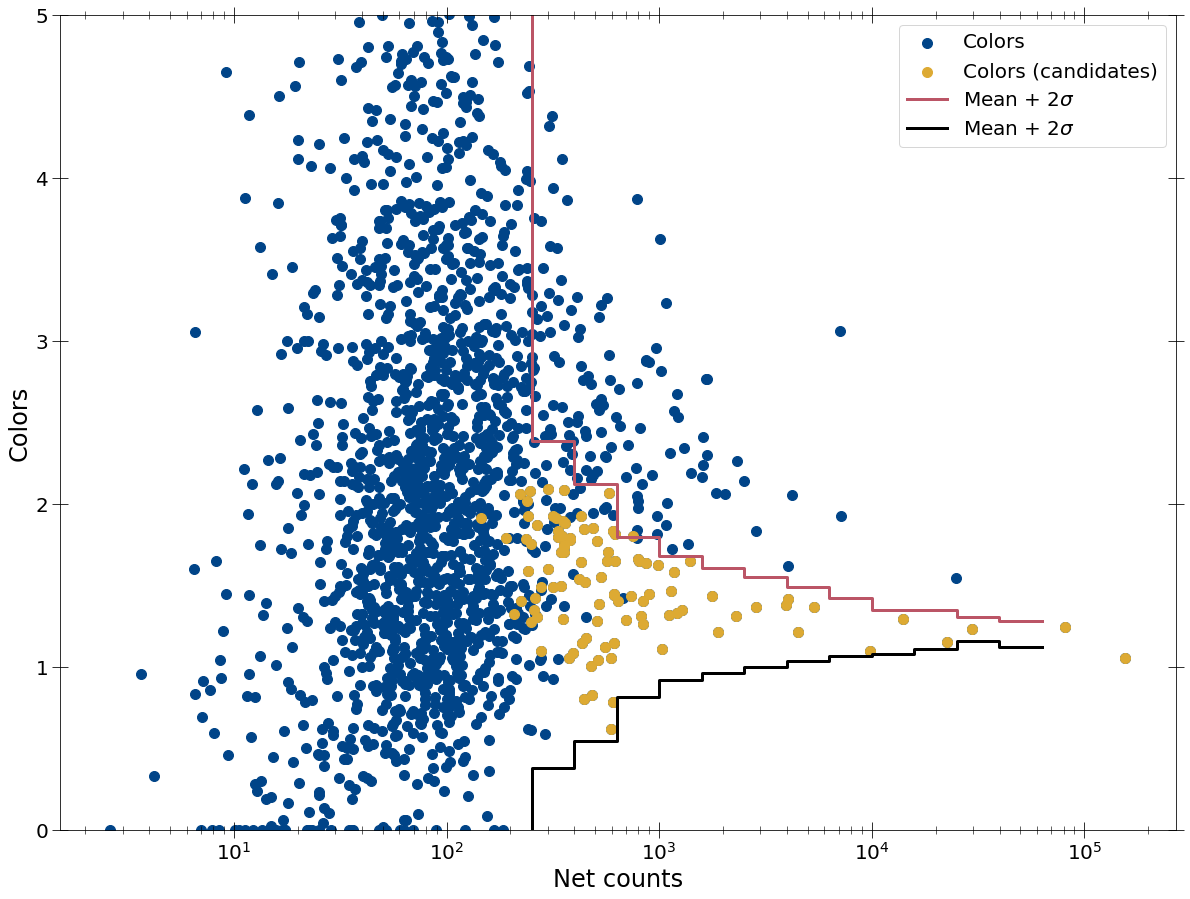

2:80: E501 line too long (83 > 79 characters)


In [22]:
mark_interested_srcs(sim_color_dict_arr[2], obs_color_dict_arr[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     interested_srcs_alldet2[2], 0)

In [28]:
source_nums = np.loadtxt('Interested_sources.txt', dtype='object')

(array([ 24,  38,  43,  50,  75,  91,  98, 111, 121, 127, 140, 152, 187,
       191, 192, 195, 206, 211, 213, 223, 229, 240, 273, 308, 309, 311,
       441, 464, 465, 467, 481, 483]),)


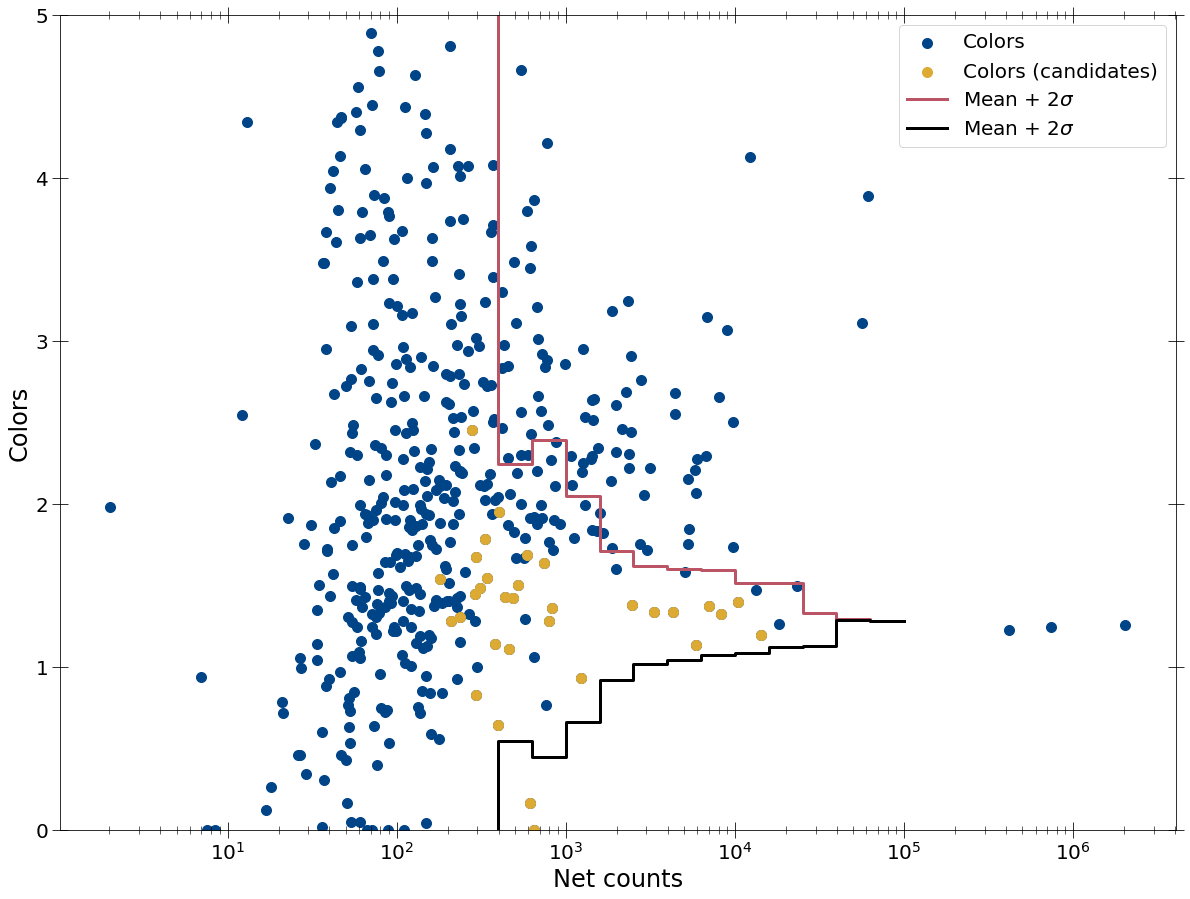

2:80: E501 line too long (83 > 79 characters)


In [29]:
mark_interested_srcs(sim_color_dict_arr[0], obs_color_dict_arr[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     source_nums, 0)

(array([ 16,  24,  29,  33,  55,  66,  72,  84,  93,  97, 103, 119, 122,
       123, 125, 134, 137, 139, 157, 171, 183, 184, 185, 220, 224, 225,
       226, 229, 231]),)


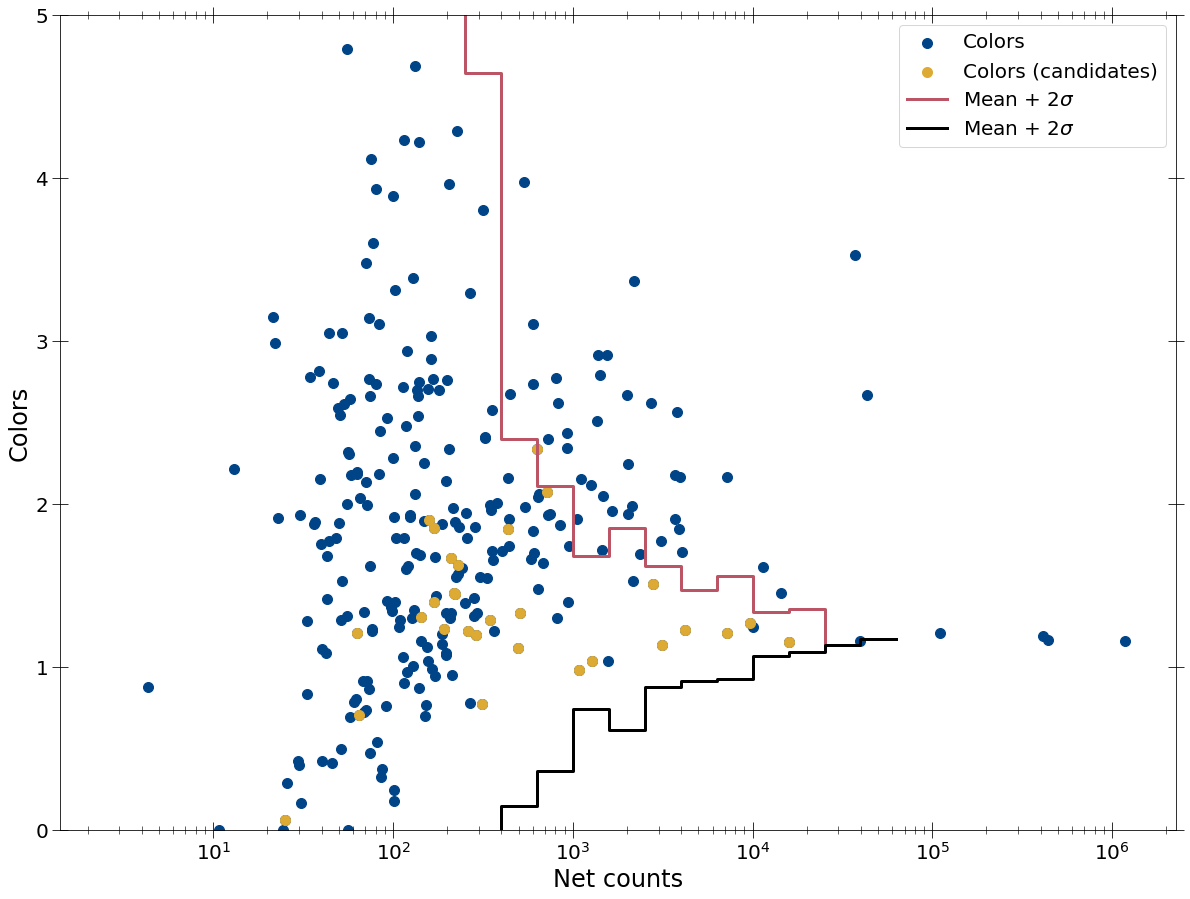

2:80: E501 line too long (83 > 79 characters)


In [30]:
mark_interested_srcs(sim_color_dict_arr[1], obs_color_dict_arr[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     source_nums, 0)

## def unmask_arr(masked_values, mask, filler=-100.0):
    unmasked_arr = np.ones(len(mask), dtype=float)*filler
    unmasked_arr[mask] = masked_values
    return unmasked_arr

In [23]:
print('MOS sources not detected in PN')
mos_not_pn = []
for src in interested_srcs_alldet[1]:
    if src not in interested_srcs_alldet[0]:
        mos_not_pn.append(src)
        print('Source: ', src)
        arg = np.where(spec_summary['src_nums'][0] == src)[0]
        print('Net counts (PN): ', spec_summary['counts'][0][0][1][arg])
        print('Net counts (MOS): ', spec_summary['counts'][0][1][1][arg])
        print('Bg counts (PN): ', spec_summary['counts'][1][0][1][arg])
        print('Bg counts (MOS): ', spec_summary['counts'][1][1][1][arg])
        print('Mask (PN): ', spec_summary['spec_masks'][1][3][arg])
        print('Mask (MOS): ', spec_summary['spec_masks'][1][4][arg])
        print('Color (PN): ', unmask_arr(obs_color_dict_arr[0]['colors'], spec_summary['spec_masks'][1][3])[arg])
        print('Color (MOS): ', unmask_arr(obs_color_dict_arr[1]['colors'], spec_summary['spec_masks'][1][4])[arg])

MOS sources not detected in PN
Source:  201129705010014
Net counts (PN):  [1984.88629568]
Net counts (MOS):  [608.05064636]
Bg counts (PN):  [2078.11370432]
Bg counts (MOS):  [524.94935364]


IndexError: list index out of range

14:80: E501 line too long (113 > 79 characters)


In [395]:
print('PN sources not detected in MOS')
pn_not_mos = []
for src in interested_srcs_alldet[0]:
    if src not in interested_srcs_alldet[1]:
        pn_not_mos.append(src)
        print('Source: ', src)
        arg = np.where(spec_summary['src_nums'][0] == src)[0]
        print('Net counts (PN): ', spec_summary['counts'][0][0][1][arg])
        print('Net counts (MOS): ', spec_summary['counts'][0][1][1][arg])
        print('Bg counts (PN): ', spec_summary['counts'][1][0][1][arg])
        print('Bg counts (MOS): ', spec_summary['counts'][1][1][1][arg])
        print('Mask (PN): ', spec_summary['spec_masks'][1][3][arg])
        print('Mask (MOS): ', spec_summary['spec_masks'][1][4][arg])
        print('Color (PN): ', unmask_arr(obs_color_dict_arr[0]['colors'], spec_summary['spec_masks'][1][3])[arg])
        print('Color (MOS): ', unmask_arr(obs_color_dict_arr[1]['colors'], spec_summary['spec_masks'][1][4])[arg])

PN sources not detected in MOS
Source:  201113501010066
Net counts (PN):  [569.59489915]
Net counts (MOS):  [77.06422098]
Bg counts (PN):  [1054.40510085]
Bg counts (MOS):  [132.93577902]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [1.67109356]
Color (MOS):  [3.60388168]
Source:  201113501010154
Net counts (PN):  [404.91355624]
Net counts (MOS):  [169.29402981]
Bg counts (PN):  [769.08644376]
Bg counts (MOS):  [251.70597019]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [1.95526699]
Color (MOS):  [1.4032798]
Source:  201129701010015
Net counts (PN):  [452.26180445]
Net counts (MOS):  [80.75597502]
Bg counts (PN):  [476.73819555]
Bg counts (MOS):  [149.24402498]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [1.87554681]
Color (MOS):  [2.73833179]
Source:  201129704010011
Net counts (PN):  [465.79990524]
Net counts (MOS):  [287.22584027]
Bg counts (PN):  [836.20009476]
Bg counts (MOS):  [147.77415973]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [2.0655

14:80: E501 line too long (113 > 79 characters)


In [396]:
len(mos_not_pn)

18

In [397]:
len(pn_not_mos)

37

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:486: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:487: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:573: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:574: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

8.0


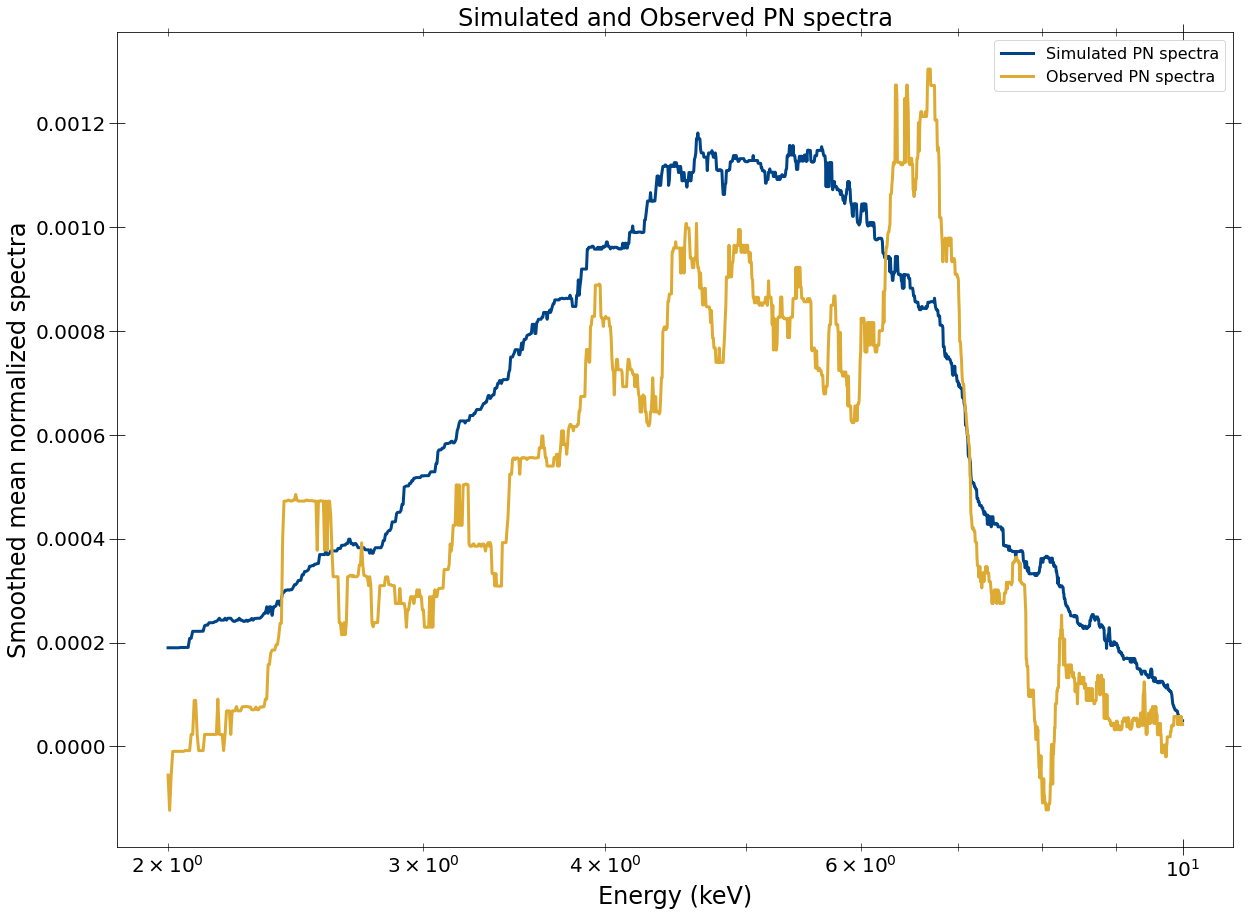

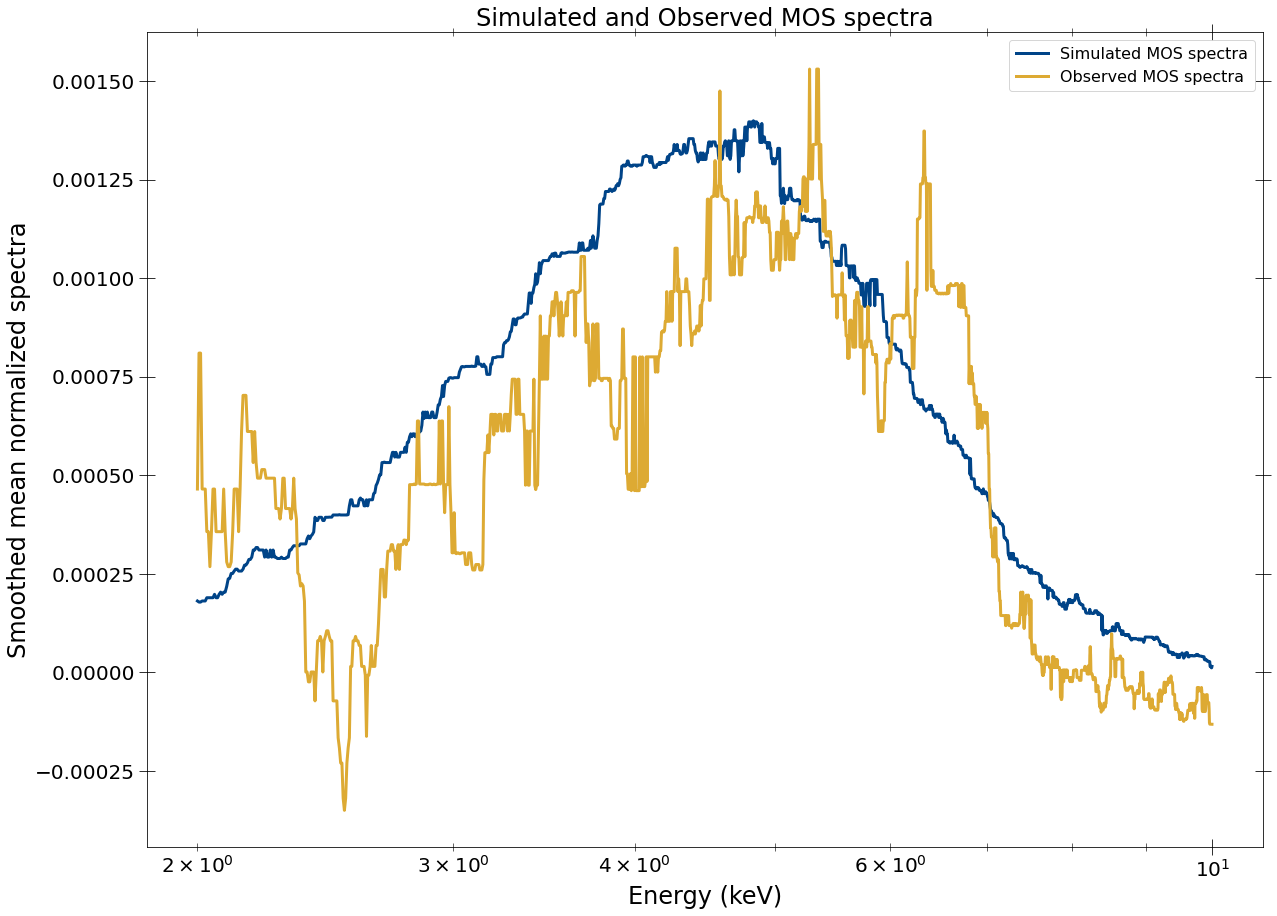

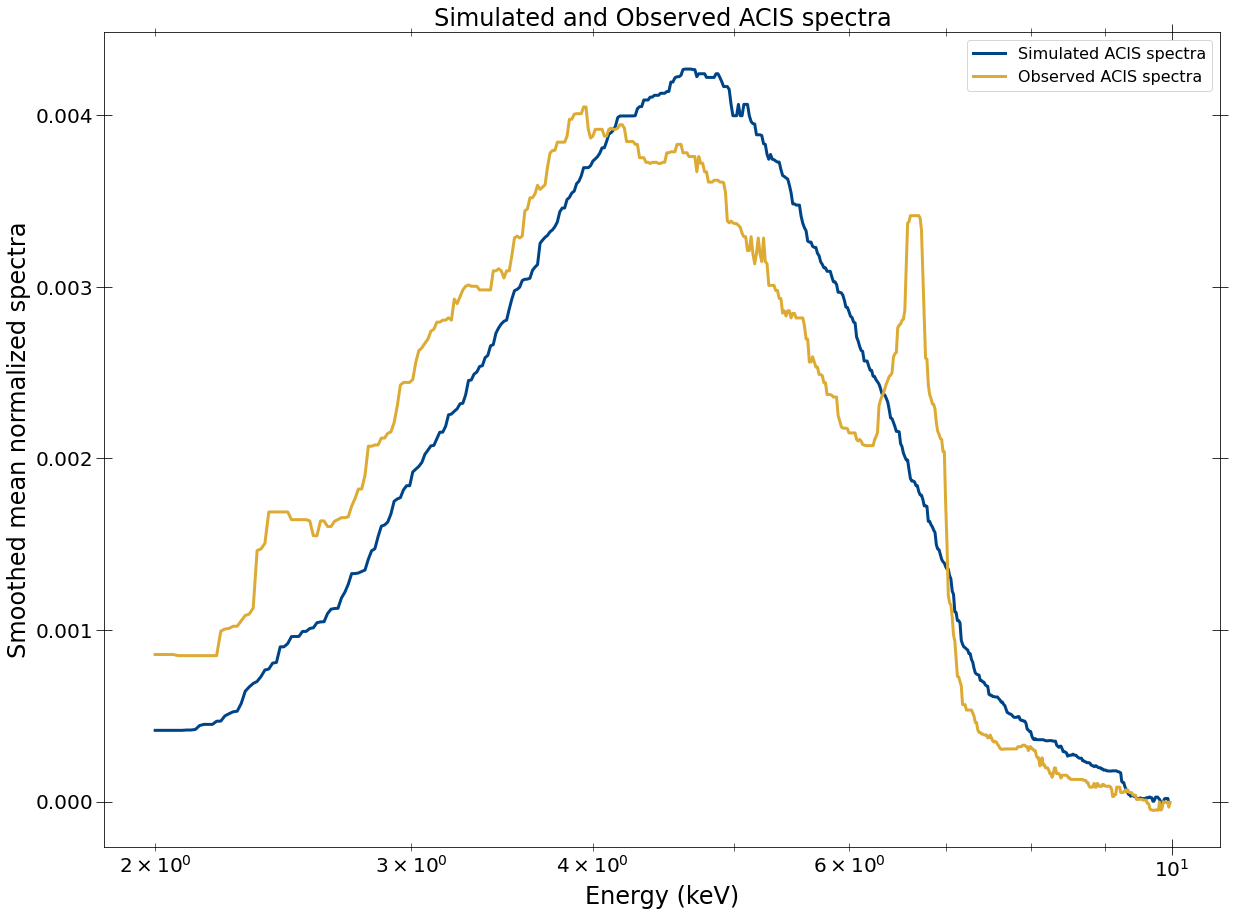

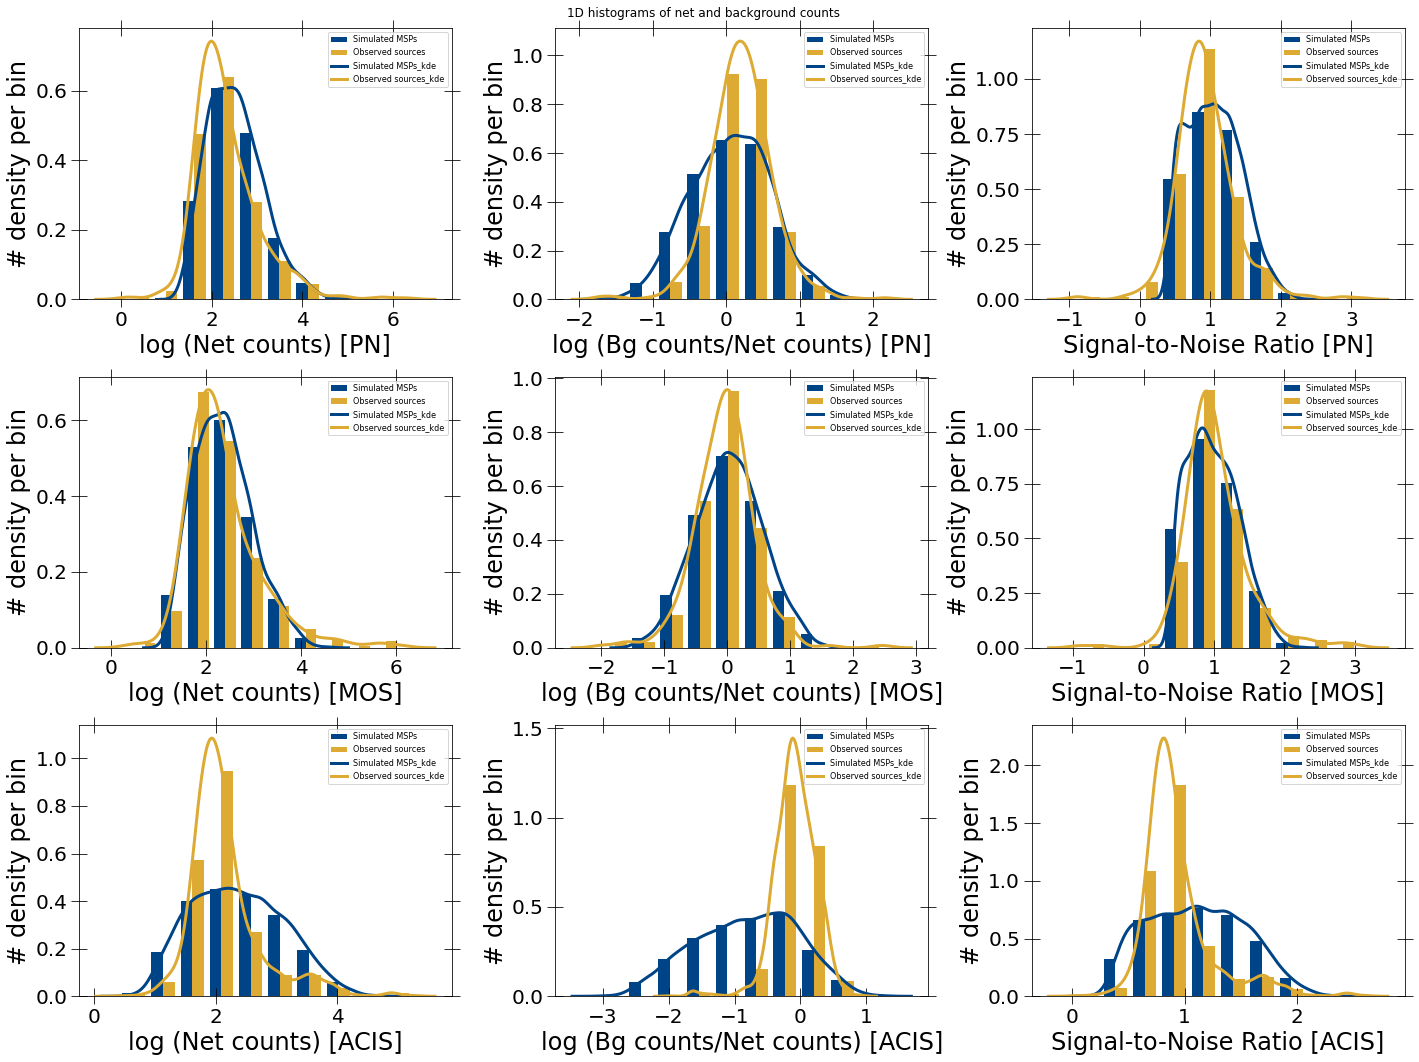

In [340]:
spec_summary = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path, xmm_sim_path, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[2, 10])

In [28]:
def fit_src_pl_gauss(source_num, src_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    if telescope == 'XMM':
        spec_pnfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                 str(source_num) + '_PN_combined_src_grp1*')
        spec_mosfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                  str(source_num) + '_MOS_combined_src_grp1*')
        if len(spec_pnfile) > 0:
            spec_pn = xspec.Spectrum(spec_pnfile[0])
            spec_pn.ignore('0.0-2.0, 10.0-**')
        if len(spec_mosfile) > 0:
            spec_mos = xspec.Spectrum(spec_mosfile[0])
            spec_mos.ignore('0.0-2.0, 10.0-**')
    elif telescope == 'Chandra':
        os.chdir(src_folder + '/' + source_num)
        spec_file = str(source_num) + '_combined_src_grp1.pi'
        spec = xspec.Spectrum(spec_file)
        spec.ignore('0.0-2.0, 10.0-**')
        spec.notice('2.0-10.0')
    else:
        print('Telescope not recognized.')
    
    model = xspec.Model('tbabs*(pegpwrlw+gauss)')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    model.pegpwrlw.eMin.values = '2.0'
    model.pegpwrlw.eMax.values = '10.0'
    model.gaussian.LineE.values = '6.7, 0.0001, 6.1, 6.1, 7.3, 7.3'
    model.gaussian.Sigma.values = '0.1 0'
    model.gaussian.norm.values = '1.0E-5, 0.001,,,,'
    
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.query = 'yes'
    xspec.Fit.perform()
    xspec.Fit.error('2.706 6')
    xspec.Fit.perform()
    xspec.Fit.error('2.706 8')
    xspec.Fit.perform()
    xspec.Fit.error('2.706 6')
    xspec.Fit.error('2.706 8')
    #goodness = xspec.Fit.goodness(1000)
    goodness = 50.0
    line_pos_low = xspec.AllModels(1).gaussian.LineE.error[0]
    line_pos_high = xspec.AllModels(1).gaussian.LineE.error[1]
    line_norm_low = xspec.AllModels(1).gaussian.norm.error[0]
    line_norm_high = xspec.AllModels(1).gaussian.norm.error[1]
    print('Model params for ' + source_num +
          ': NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0],
          ' Fe_pos:', xspec.AllModels(1).gaussian.LineE.values[0],
          line_pos_low, line_pos_high,
          ' Fe_norm:', xspec.AllModels(1).gaussian.norm.values[0],
          line_norm_low, line_norm_high)
    print('Fit stats for ' + source_num + ': ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    os.chdir(curr_dir)
    return ([source_num, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [source_num, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0],
             xspec.AllModels(1).gaussian.LineE.values[0], line_pos_low,
             line_pos_high,
             xspec.AllModels(1).gaussian.norm.values[0], line_norm_low,
             line_norm_high])


25:1: W293 blank line contains whitespace
34:1: W293 blank line contains whitespace
46:5: E265 block comment should start with '# '
64:80: E501 line too long (80 > 79 characters)


In [29]:
def fit_src_pl(source_num, src_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    if telescope == 'XMM':
        spec_pnfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                 str(source_num) + '_PN_combined_src_grp1*')
        spec_mosfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                  str(source_num) + '_MOS_combined_src_grp1*')
        if len(spec_pnfile) > 0:
            spec_pn = xspec.Spectrum(spec_pnfile[0])
            spec_pn.ignore('0.0-2.0, 10.0-**')
        if len(spec_mosfile) > 0:
            spec_mos = xspec.Spectrum(spec_mosfile[0])
            spec_mos.ignore('0.0-2.0, 10.0-**')
    elif telescope == 'Chandra':
        os.chdir(src_folder + '/' + source_num)
        spec_file = str(source_num) + '_combined_src_grp1.pi'
        spec = xspec.Spectrum(spec_file)
        spec.ignore('0.0-2.0, 10.0-**')
        spec.notice('2.0-10.0')
    else:
        print('Telescope not recognized.')

    model = xspec.Model('tbabs*pegpwrlw')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.perform()
    xspec.Fit.error('2.706 2')
    xspec.Fit.perform()
    #goodness = xspec.Fit.goodness(1000)
    goodness = 50.0
    print('Model params for ' + source_num +
          ': NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0])
    print('Fit stats for ' + source_num + ': ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    if telescope == 'Chandra':
        os.chdir(curr_dir)
    return ([source_num, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [source_num, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0]])

35:5: E265 block comment should start with '# '
46:80: E501 line too long (80 > 79 characters)


In [32]:
fit_src_pl(interested_srcs_alldet[0][11])

Model params for 201129704010033: NH =  39.31615012136381  Gamma:  1.108668033822623  norm:  0.2644667587745829
Fit stats for 201129704010033:  667.5720375241511 -7.1247888522302505 50.0 759




(['201129704010033', 667.5720375241511, -7.1247888522302505, 50.0, 759],
 ['201129704010033', 39.31615012136381, 1.108668033822623, 0.2644667587745829])

In [90]:
xspec.AllData.clear()
os.chdir('/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data')

In [28]:
import xspec

In [35]:
pn_fit_stats_table_pl_g = []
pn_model_params_table_pl_g = []
pn_fit_stats_table_pl_g2 = []
pn_model_params_table_pl_g2 = []

for source_num in interested_srcs_alldet[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    pn_fit_stats_table_pl_g.append(fit_stats)
    pn_model_params_table_pl_g.append(model_params)
    pn_fit_stats_table_pl_g2.append(fit_stats2)
    pn_model_params_table_pl_g2.append(model_params2)

200305401010008
Model params for 200305401010008: NH =  7.533939944745336  Gamma:  5.442637447648618e-05  norm:  0.17050804383594798  Fe_pos: 6.626328597681583 0.0 0.0  Fe_norm: 5.323210035530213e-07 0.0 1.2221860033790075e-06
Fit stats for 200305401010008:  305.569596299586 -7.709028419823702 50.0 374


Model params for 200305401010008: NH =  7.962597433801153  Gamma:  0.00014821992520889414  norm:  0.17493341795646422  Fe_norms: 7.265142311619051e-15 0.0 4.0570910778969696e-07 3.8656127404655373e-07 0.0 9.673675942733488e-07 4.594295440240561e-08 0.0 5.896914543091011e-07
Fit stats for 200305401010008:  306.10006819464763 -7.707648851565125 50.0 373


200305401010017
Model params for 200305401010017: NH =  13.817574474508568  Gamma:  1.070204709779063e-06  norm:  0.1442985495758535  Fe_pos: 6.738423088488317 6.64109129015214 6.833690737021409  Fe_norm: 8.203582335736731e-07 3.3312780882047456e-07 1.3858637165450846e-06
Fit stats for 200305401010017:  331.2412290053585 -7.370987428627

Model params for 201129704010053: NH =  11.088605972349708  Gamma:  1.1307905330299015  norm:  0.09810896267439545  Fe_pos: 6.43757960704841 6.3179075355287395 6.555224427839737  Fe_norm: 6.845451128366251e-07 2.5056545136399e-07 1.2106186668855486e-06
Fit stats for 201129704010053:  366.7032766375046 -6.1761306121608115 50.0 451


Model params for 201129704010053: NH =  11.028148664139426  Gamma:  1.1059510983199525  norm:  0.0987580104858422  Fe_norms: 5.191094620427834e-07 1.5350097929227554e-07 9.599782659016053e-07 1.1908874007847244e-07 0.0 4.844506519647475e-07 5.0412999119367507e-20 0.0 1.465022594002325e-07
Fit stats for 201129704010053:  366.9564830773974 -6.172014013341773 50.0 450


201129704010056
Model params for 201129704010056: NH =  29.08351122451185  Gamma:  0.9884219456976203  norm:  0.11172819244551731  Fe_pos: 6.165963046765651 0.0 6.444295587033637  Fe_norm: 4.4543163825884665e-07 0.0 1.0265450819716366e-06
Fit stats for 201129704010056:  448.49001621925134 -7.217

Model params for 203017301010002: NH =  21.037820831249167  Gamma:  1.278738438831918  norm:  0.18109855180378404  Fe_pos: 7.3 0.0 0.0  Fe_norm: 3.1031311992267915e-08 0.0 5.99156178522432e-07
Fit stats for 203017301010002:  350.9904852627127 -6.245660134856746 50.0 364


Model params for 203017301010002: NH =  20.818453268560972  Gamma:  1.2874205363120337  norm:  0.17817757322431338  Fe_norms: 1.281807955218914e-07 0.0 4.602340007745241e-07 1.0061101643583012e-21 0.0 1.4401446068304248e-07 7.787274212095138e-22 0.0 3.309106689969335e-07
Fit stats for 203017301010002:  350.4389451067531 -6.243584064942769 50.0 363


203028828010021
Model params for 203028828010021: NH =  52.27436960150321  Gamma:  1.389292410421775  norm:  0.34528825159456444  Fe_pos: 6.461891795074195 6.331367401093046 6.586484932020409  Fe_norm: 1.2971315012837925e-06 3.321265167967249e-07 2.557277114378633e-06
Fit stats for 203028828010021:  192.87302515191172 -8.491958576570669 50.0 237


Model params for 20302882

Model params for 206946410010178: NH =  8.024512248000173  Gamma:  0.9993788302077241  norm:  0.07330874969455457  Fe_pos: 7.044473647732228 0.0 0.0  Fe_norm: 1.411439942397122e-07 0.0 5.529768416628165e-07
Fit stats for 206946410010178:  340.5536748991003 -6.984668828936018 50.0 438


Model params for 206946410010178: NH =  7.747015547962011  Gamma:  0.9497285606925499  norm:  0.07321174234593691  Fe_norms: 1.808540176606875e-20 0.0 1.1529092018896208e-07 7.587835765141689e-20 0.0 2.3688189558972698e-07 1.7835698594181033e-07 0.0 5.397858452170278e-07
Fit stats for 206946410010178:  339.93555789371146 -7.059735135351436 50.0 437


207622503010099
Model params for 207622503010099: NH =  8.24199940955534  Gamma:  1.7920811792600093  norm:  0.04767876862619716  Fe_pos: 6.372966596131252 6.177528903756428 6.502775732096432  Fe_norm: 3.658327920661404e-07 1.0090069288259952e-07 6.862772466165063e-07
Fit stats for 207622503010099:  380.72861262626014 -8.03549917066575 50.0 417


Model param

Model params for 201129707010002: NH =  14.011359132819933  Gamma:  0.5491696286970138  norm:  0.18982400551267073  Fe_pos: 6.4760557767456115 6.37078534097682 6.585755283949413  Fe_norm: 8.922926870000979e-07 3.93375141846936e-07 1.454651103316543e-06
Fit stats for 201129707010002:  518.6766420185004 -5.6179691304441945 50.0 557


Model params for 201129707010002: NH =  13.820397496036286  Gamma:  0.6096821184514305  norm:  0.1823901695541978  Fe_norms: 7.20326822164432e-07 3.393905040307595e-07 1.1690389934224374e-06 4.090169488477654e-07 4.72545938237606e-08 8.398451958998371e-07 2.0362902763500156e-07 0.0 6.03791075140573e-07
Fit stats for 201129707010002:  513.4657794099021 -5.629831999281462 50.0 556


201129707010007
Model params for 201129707010007: NH =  14.10557334034819  Gamma:  1.5389549865441483  norm:  0.13879551920734431  Fe_pos: 6.450205769124355 6.338894154451264 6.561706026444402  Fe_norm: 6.540897644883892e-07 2.63601548291022e-07 1.1166918161481903e-06
Fit stats for

Model params for 202026707015303: NH =  13.766509291214266  Gamma:  2.0943458610080357  norm:  0.13894274542779805  Fe_norms: 8.773003250160302e-19 0.0 4.017492854692142e-07 2.2226863891337913e-18 0.0 2.770459956991799e-07 6.251617434453274e-08 0.0 4.98144372213923e-07
Fit stats for 202026707015303:  441.51009486521394 -7.488306701791918 50.0 591


202039301010054
Model params for 202039301010054: NH =  16.107035093414353  Gamma:  1.1213793524884514  norm:  0.09854766917478114  Fe_pos: 6.769437362760247 6.603977640347289 7.078750715865505  Fe_norm: 3.3054995590271366e-07 8.030214585614585e-08 6.117618367593149e-07
Fit stats for 202039301010054:  787.5850352119014 -4.638777071287015 50.0 942


Model params for 202039301010054: NH =  16.603133576082264  Gamma:  1.2274714726071303  norm:  0.09818504059092172  Fe_norms: 9.992541598644838e-15 0.0 1.4294711899520285e-07 2.6542849159072495e-07 7.079077834678162e-08 4.917185857303581e-07 2.036819069387548e-07 1.8272843418645565e-08 4.252794079

Model params for 201129704010011: NH =  17.170455878306544  Gamma:  0.43405190935731197  norm:  0.25965854693324925  Fe_norms: 7.920619540211852e-07 3.6284212753863145e-07 1.2757990139958025e-06 1.774066906759965e-07 0.0 6.283966302313072e-07 4.624411278840258e-07 3.836717261331978e-08 9.501260039458207e-07
Fit stats for 201129704010011:  999.9419277867435 -4.510545204231944 50.0 1194


201129704010019
Model params for 201129704010019: NH =  22.089621446819905  Gamma:  0.47088419439088675  norm:  0.1907650860170485  Fe_pos: 6.445404018100875 6.256137596964562 6.728953116375407  Fe_norm: 4.927351161304949e-07 8.461826333979804e-08 9.342503920185451e-07
Fit stats for 201129704010019:  1025.8642811120633 -8.924731246574023 50.0 1216


Model params for 201129704010019: NH =  22.097942195052937  Gamma:  0.5297414368025379  norm:  0.187426186398744  Fe_norms: 3.169609433825432e-07 2.587941056642649e-09 6.662765763420859e-07 1.3267966002114232e-07 0.0 4.84043219693579e-07 2.566585803997388e-0

Model params for 208016803010001: NH =  5.477438247722109  Gamma:  0.7910695804625593  norm:  0.6112963494070606  Fe_pos: 6.47529835813703 6.35485643721511 6.611925243433143  Fe_norm: 1.348419485181247e-06 3.689821193491286e-07 2.4614583841749452e-06
Fit stats for 208016803010001:  986.3285668155654 -7.282235643893765 50.0 1131


Model params for 208016803010001: NH =  5.48781604753007  Gamma:  0.7931337480959886  norm:  0.6112456636763275  Fe_norms: 1.0077959637487782e-06 2.1164269618709708e-07 1.915317598044249e-06 3.574266168295753e-07 0.0 1.214337076209289e-06 1.108762402275001e-15 0.0 6.551420174748969e-07
Fit stats for 208016803010001:  986.6303378164473 -7.280170326033662 50.0 1130


208016813010003
Model params for 208016813010003: NH =  6.951152694332541  Gamma:  1.8606012578069824  norm:  0.2498195847448299  Fe_pos: 6.922400232207302 6.681621493453794 0.0  Fe_norm: 3.887961194557842e-07 0.0 9.172382262747876e-07
Fit stats for 208016813010003:  607.318719084682 -5.654514873657

Model params for 201129721010035: NH =  16.98947951245089  Gamma:  5.0  norm:  0.24173077063518178  Fe_norms: 1.340370959688657e-24 0.0 1.0572708572882437e-07 1.355810837164988e-07 0.0 3.5675355072923425e-07 1.979792400358619e-07 1.9636230452386684e-08 4.014947884305545e-07
Fit stats for 201129721010035:  896.4308963373986 -8.007244736222175 50.0 1065


201129721010057
Model params for 201129721010057: NH =  14.865349759200525  Gamma:  3.156466208720087  norm:  0.09631668048130516  Fe_pos: 6.100000007460654 0.0 0.0  Fe_norm: 1.4124465522567267e-11 0.0 1.4297331293732635e-07
Fit stats for 201129721010057:  2511.841438083403 -4.3195620460871025 50.0 2672


Model params for 201129721010057: NH =  14.124099839223673  Gamma:  3.022123486539761  norm:  0.09109979007087837  Fe_norms: 6.322744464947602e-14 0.0 6.551695621070423e-08 1.1635104408761359e-19 0.0 5.925018979387373e-08 1.0006855117660785e-17 0.0 8.242317764366575e-08
Fit stats for 201129721010057:  2511.948557760672 -4.3227885351931

Model params for 201129705010011: NH =  7.595079927045246  Gamma:  1.2412094900262383  norm:  0.47215386065820286  Fe_norms: 2.69191205722213e-08 0.0 2.83886963109431e-07 3.910514548343649e-19 0.0 1.880737686948485e-07 1.8003158865193587e-20 0.0 1.4312100577553343e-07
Fit stats for 201129705010011:  3101.9130581395707 -5.653636551953409 50.0 2878


201129705010079
Model params for 201129705010079: NH =  13.583270817557871  Gamma:  1.2552021052583269  norm:  13.1164242824439  Fe_pos: 6.560845590322372 0.0 0.0  Fe_norm: 4.777320563650454e-06 0.0 1.0868434672499646e-05
Fit stats for 201129705010079:  2496.5567168632097 -6.995988915321978 50.0 2597


Model params for 201129705010079: NH =  13.571328887124075  Gamma:  1.2458712805195562  norm:  13.155573839653092  Fe_norms: 1.7775784503880453e-07 0.0 4.730674613037286e-06 4.0187228040699684e-07 0.0 5.113217905670533e-06 1.348787255557718e-06 0.0 6.2181940932799805e-06
Fit stats for 201129705010079:  2498.1274246122503 -6.996475276187615 50.

Model params for 201129721010034: NH =  33.77735205853907  Gamma:  2.594316363300628  norm:  147.08385383617988  Fe_norms: 1.0754272133619578e-05 9.327657328119772e-06 1.218231033521706e-05 9.862517320785789e-21 0.8224962005991274 0.0 1.4504033033963037e-21 0.8224962005991274 0.0
Fit stats for 201129721010034:  52561.298428824564 -6.9006747896162235 50.0 3192




In [69]:
pn_fit_stats_table2_pl_g = []
pn_model_params_table2_pl_g = []
pn_fit_stats_table2_pl_g2 = []
pn_model_params_table2_pl_g2 = []

for source_num in interested_srcs_alldet2[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    pn_fit_stats_table2_pl_g.append(fit_stats)
    pn_model_params_table2_pl_g.append(model_params)
    pn_fit_stats_table2_pl_g2.append(fit_stats2)
    pn_model_params_table2_pl_g2.append(model_params2)

201113501010175
Model params for 201113501010175: NH =  8.4024927087956  Gamma:  0.000682455803084796  norm:  0.06976245581039871  Fe_pos: 7.066199415351161 0.0 0.0  Fe_norm: 2.1697162793140578e-07 0.0 5.717906316910192e-07
Fit stats for 201113501010175:  709.0192599737586 -5.022787560749561 50.0 873


Model params for 201113501010175: NH =  8.40495489507823  Gamma:  0.000996916882302617  norm:  0.06972761426796356  Fe_norms: 6.596399384026322e-13 0.0 1.4595965654936065e-07 4.91499281729763e-08 0.0 3.0840617286635105e-07 2.1271597630514698e-07 0.0 4.886713305629608e-07
Fit stats for 201113501010175:  708.0069053741938 -5.0330009254128685 50.0 872


201113501015104
Model params for 201113501015104: NH =  23.619469242264653  Gamma:  1.576906725411623  norm:  0.12761577333780705  Fe_pos: 6.300169242119751 0.0 0.0  Fe_norm: 2.9576154183670717e-07 0.0 8.221730094398566e-07
Fit stats for 201113501015104:  336.74481053394237 -6.778467213439382 50.0 360


Model params for 201113501015104: NH =

Model params for 201129707015101: NH =  66.83033521878707  Gamma:  2.8194101418915483  norm:  0.44610092952134817  Fe_pos: 6.832688263033997 6.7371814535571275 6.93094931916388  Fe_norm: 1.989812409876055e-06 8.107291187500725e-07 4.40467440034941e-06
Fit stats for 201129707015101:  219.9159460829265 -5.839846552206493 50.0 240


Model params for 201129707015101: NH =  70.56358818036232  Gamma:  2.864885160579997  norm:  0.4997735605812714  Fe_norms: 9.877037870545037e-17 0.0 6.833052696741188e-07 1.0197784411693039e-06 1.4037978833184296e-07 2.0973375897286797e-06 7.840060320698054e-07 0.0 2.2672717640444006e-06
Fit stats for 201129707015101:  223.60997300551588 -5.74622459215169 50.0 239


201129708010014
Model params for 201129708010014: NH =  15.17413593488394  Gamma:  6.00214359534559e-07  norm:  0.14733069784278258  Fe_pos: 6.840421205039523 6.69951577823337 6.986835648971391  Fe_norm: 9.855930282004682e-07 2.4978829890050607e-07 1.860753818813438e-06
Fit stats for 20112970801001

Model params for 202039301010123: NH =  30.769076024590753  Gamma:  0.919402927147641  norm:  0.1790131488883642  Fe_pos: 6.9031666156423475 6.779466368531155 7.0428494489225795  Fe_norm: 1.3876435491502096e-06 4.997485505363465e-07 2.773542194103873e-06
Fit stats for 202039301010123:  377.9316019280053 -5.3994603593202495 50.0 387


Model params for 202039301010123: NH =  31.713008051428464  Gamma:  0.8425175587931122  norm:  0.18880355000011387  Fe_norms: 3.405857543801886e-11 0.0 5.672343771815815e-07 3.4845818115050167e-07 0.0 1.199698030194832e-06 7.952431423306222e-07 8.217022507373922e-08 1.8601129652072792e-06
Fit stats for 202039301010123:  381.1683724767849 -5.466015573204053 50.0 386


203017301010002
Model params for 203017301010002: NH =  21.037820831249167  Gamma:  1.278738438831918  norm:  0.18109855180378404  Fe_pos: 7.3 0.0 0.0  Fe_norm: 3.1031311992267915e-08 0.0 5.99156178522432e-07
Fit stats for 203017301010002:  350.9904852627127 -6.245660134856746 50.0 364


Model

Model params for 206946405010094: NH =  4.4217023642215  Gamma:  0.5121665065009954  norm:  0.07484491663232017  Fe_pos: 6.242731356476952 0.0 0.0  Fe_norm: 3.433284254073545e-07 0.0 9.01972521207151e-07
Fit stats for 206946405010094:  288.83441205800824 -6.826141535317265 50.0 328


Model params for 206946405010094: NH =  4.884805016318565  Gamma:  0.5775241305785408  norm:  0.07552828831554295  Fe_norms: 1.6655034764443763e-07 0.0 6.392681670903782e-07 2.2882910276907107e-07 0.0 7.18976042165775e-07 7.1057374092818e-13 0.0 3.520438273688038e-07
Fit stats for 206946405010094:  288.97845038700257 -6.776720610306852 50.0 327


206946408015034
Model params for 206946408015034: NH =  43.14195604869764  Gamma:  3.0580446011083318  norm:  0.7984661099973551  Fe_pos: 6.485833083891439 6.346591141567029 6.65801220575353  Fe_norm: 2.4753037695994324e-06 5.819231624294328e-07 6.271726268729064e-06
Fit stats for 206946408015034:  241.88212263196425 -5.354664371042933 50.0 283


Model params for 

Model params for 201113501010117: NH =  12.748023477898078  Gamma:  3.777240892039336e-07  norm:  0.15148807444180692  Fe_pos: 6.996589135791325 0.0 0.0  Fe_norm: 3.6134431520394527e-07 0.0 1.2628638367357914e-06
Fit stats for 201113501010117:  823.9640686641009 -6.01431174365205 50.0 1056


Model params for 201113501010117: NH =  11.042976536135722  Gamma:  1.2056171199644528e-06  norm:  0.14042965733068716  Fe_norms: 2.6142721168085427e-07 0.0 8.299385436853326e-07 8.85572715368496e-20 0.0 5.012418728999278e-07 4.202508655534445e-07 0.0 1.1571022845990763e-06
Fit stats for 201113501010117:  822.8360888906774 -5.913565935721103 50.0 1055


201129701010015
Model params for 201129701010015: NH =  3.087899479308369  Gamma:  0.7314066670304424  norm:  0.07198983469793094  Fe_pos: 6.878504435779244 6.705796547777163 7.019759367120794  Fe_norm: 2.8030459351071563e-07 4.024787294855468e-08 5.642443402303226e-07
Fit stats for 201129701010015:  726.1680242153152 -6.949036609513501 50.0 881


M

Model params for 201129707010046: NH =  50.224988479397766  Gamma:  1.3493854062182882  norm:  0.244522971483414  Fe_pos: 6.186173002115288 0.0 0.0  Fe_norm: 4.088492931953597e-07 0.0 1.1292426174039996e-06
Fit stats for 201129707010046:  241.03358859689806 -8.22754739994448 50.0 315


Model params for 201129707010046: NH =  64.80668739067522  Gamma:  1.800195766690879  norm:  0.36603263605976105  Fe_norms: 7.243910771904161e-20 0.0 5.44056523138198e-07 1.0277202309872657e-21 0.0 3.4300801194767135e-07 6.352475525927683e-16 0.0 3.495302339103378e-07
Fit stats for 201129707010046:  242.28253690166952 -8.075945854723404 50.0 314


201129708015085
Model params for 201129708015085: NH =  34.82077746807919  Gamma:  1.9157136082671768  norm:  0.15476571842831824  Fe_pos: 6.7182771062773625 6.613779751208496 6.811386111662604  Fe_norm: 1.2084896879353403e-06 5.591918032805421e-07 2.1755133220887703e-06
Fit stats for 201129708015085:  240.46702140573728 -7.256858261282601 50.0 260


Model para

Model params for 204003401010013: NH =  10.034534993799257  Gamma:  0.8377537866208837  norm:  0.0815827279537251  Fe_pos: 6.67873731780274 6.618526758293884 6.735897457968442  Fe_norm: 8.498271503697068e-07 4.933289353588393e-07 1.2736373013457587e-06
Fit stats for 204003401010013:  948.6224486324177 -7.151119077511774 50.0 1165


Model params for 204003401010013: NH =  9.678008172094136  Gamma:  0.7322971975806782  norm:  0.08345507876916487  Fe_norms: 1.9162661440430804e-14 0.0 1.65575885074309e-07 7.313046700653448e-07 4.329130398180617e-07 1.0896424336531539e-06 3.948666477450533e-14 0.0 2.842409534191078e-07
Fit stats for 204003401010013:  946.9087387258753 -7.144505491172025 50.0 1164


204024307010039
Model params for 204024307010039: NH =  15.231252034902253  Gamma:  0.7633084361594118  norm:  0.24830546228237105  Fe_pos: 6.441859203132149 6.382754669289164 6.502717771242341  Fe_norm: 2.374133556055007e-06 1.2140375877859083e-06 3.7750061345179393e-06
Fit stats for 20402430701

Model params for 201113501010122: NH =  7.390341485503745  Gamma:  0.8412257622224554  norm:  0.2546384709977931  Fe_pos: 6.67926797383028 6.628091281819157 6.728464397338762  Fe_norm: 3.088767082321713e-06 2.0919052835031647e-06 4.222915954469557e-06
Fit stats for 201113501010122:  570.7858060520396 -5.906515113229441 50.0 611


Model params for 201113501010122: NH =  7.219455370581917  Gamma:  0.7493218479981563  norm:  0.26322705810606956  Fe_norms: 4.7949642403706565e-16 0.0 4.4425369990479614e-07 2.3001829307658014e-06 1.4822459818312068e-06 3.2557320411135385e-06 9.026596248061822e-08 0.0 7.633313897493667e-07
Fit stats for 201113501010122:  576.3536750384804 -5.8932918445445175 50.0 610


201113501010148
Model params for 201113501010148: NH =  70.33505222497175  Gamma:  0.9718014734396326  norm:  0.12363488024376353  Fe_pos: 6.399836249077355 0.0 0.0  Fe_norm: 2.7809183265368465e-07 0.0 7.189098811597377e-07
Fit stats for 201113501010148:  1080.2504043887511 0.2078341778148354 5

Model params for 201129721010126: NH =  47.1402296633144  Gamma:  3.0253920176284628  norm:  0.11252196378397063  Fe_norms: 3.0810649264869234e-15 0.0 3.369358541870181e-08 2.3233570916178308e-08 0.0 1.9631845850917844e-07 8.498332567319275e-17 0.0 1.1439065023495056e-07
Fit stats for 201129721010126:  2056.0679247573034 -1.9235495488462924 50.0 2247


202026705010034
Model params for 202026705010034: NH =  11.292628706645388  Gamma:  2.651134291780307  norm:  0.09350909210286182  Fe_pos: 6.687588874704923 0.0 0.0  Fe_norm: 1.5381401194177865e-07 0.0 3.6616448899258166e-07
Fit stats for 202026705010034:  1253.5678091100453 -8.509430935731947 50.0 1402


Model params for 202026705010034: NH =  10.87201208452443  Gamma:  2.5512974188607123  norm:  0.09138463567653572  Fe_norms: 8.470667325760535e-14 0.0 6.166505030942785e-08 1.2386151290965407e-07 0.0 2.956580693098877e-07 3.33974753008508e-17 0.0 8.062150392239752e-08
Fit stats for 202026705010034:  1253.6056227645552 -8.425522472630114

Model params for 201129705010015: NH =  9.811437559403423  Gamma:  0.8390385874241209  norm:  0.16711844364486983  Fe_pos: 6.477159921737292 6.4017535165239865 6.560567393364096  Fe_norm: 1.4138354062645079e-06 8.241246842964532e-07 2.062863067471009e-06
Fit stats for 201129705010015:  1325.5604161170281 -5.426296913160746 50.0 1605


Model params for 201129705010015: NH =  10.056605982177222  Gamma:  0.8876535561779505  norm:  0.166896826860336  Fe_norms: 9.251042649033169e-07 4.524721447916227e-07 1.4490138177006136e-06 4.6596548924957e-07 5.4863873582107217e-08 9.27738632988146e-07 1.308784278980812e-07 0.0 5.666822745965817e-07
Fit stats for 201129705010015:  1328.757423257622 -5.434125135023264 50.0 1604


201129707010012
Model params for 201129707010012: NH =  30.72965620335343  Gamma:  0.7411094453129597  norm:  0.2611994152314625  Fe_pos: 6.280521164961761 6.213633016632501 6.3481627632842335  Fe_norm: 1.108564397466515e-06 6.061670825035543e-07 1.6849690373907318e-06
Fit stats

Model params for 201129705015062: NH =  9.579996383768373  Gamma:  0.5812718428753155  norm:  0.0776952503847957  Fe_norms: 2.3203001650860776e-07 9.59080223176303e-08 3.787232468273641e-07 3.289299053955354e-07 1.8201561968972297e-07 4.880970200286008e-07 1.5976827296612113e-07 2.339374012445189e-08 3.0778456326838943e-07
Fit stats for 201129705015062:  2445.211386007545 -2.7805451472063862 50.0 2466


201129721010063
Model params for 201129721010063: NH =  11.515508222249952  Gamma:  1.6940345517895745  norm:  0.1304992109934526  Fe_pos: 6.654314328655692 6.575939896981868 6.731742302215828  Fe_norm: 6.118301197902522e-07 3.632383420500358e-07 8.782835834729781e-07
Fit stats for 201129721010063:  1149.8426434540454 -9.433009996437562 50.0 1304


Model params for 201129721010063: NH =  11.53775396110417  Gamma:  1.721006636264335  norm:  0.12945081876696765  Fe_norms: 2.3506740879262026e-07 7.204523600668266e-08 4.1461375125642825e-07 4.7594509577785515e-07 2.751706303822302e-07 6.936

Model params for 201129721010003: NH =  12.288453903261424  Gamma:  1.4486977955044742  norm:  1.6900740259956315  Fe_norms: 5.100365868588589e-07 1.6333484009881952e-07 8.70637051872801e-07 2.5876605993230183e-07 0.0 6.384757298596394e-07 9.979878914313955e-14 0.0 2.5334606793697774e-07
Fit stats for 201129721010003:  5680.776810739113 -4.625979579403327 50.0 3100


205547504010002
Model params for 205547504010002: NH =  15.207347458486392  Gamma:  1.839311626383599  norm:  4.449414654819969  Fe_pos: 6.642731900916781 6.603737060641102 6.682175244926564  Fe_norm: 5.594789408388735e-06 4.483305807931598e-06 6.732749735708562e-06
Fit stats for 205547504010002:  3673.5574654682237 -6.136644548178457 50.0 3032


Model params for 205547504010002: NH =  15.286657647257025  Gamma:  1.866424389690214  norm:  4.442648641457918  Fe_norms: 2.132898911375946e-06 1.3354200122725254e-06 2.956176905656626e-06 3.812715304863704e-06 2.9305120890444238e-06 4.722138563106213e-06 1.7351518326328805e-06 9

In [89]:
len(pn_fit_stats_table2_pl)

138

In [36]:
pn_fit_stats_table_pl = []
pn_model_params_table_pl = []

for source_num in interested_srcs_alldet[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    pn_fit_stats_table_pl.append(fit_stats)
    pn_model_params_table_pl.append(model_params)

200305401010008
Model params for 200305401010008: NH =  8.609671845856257  Gamma:  5.9247765179925336e-06  norm:  0.18293136318952102
Fit stats for 200305401010008:  307.89924050591105 -7.45970645374718 50.0 376


200305401010017
Model params for 200305401010017: NH =  17.66178023514366  Gamma:  1.1209482410490107e-06  norm:  0.17104815611223634
Fit stats for 200305401010017:  339.6800276062975 -7.4789393609606 50.0 369


201113501010117
Model params for 201113501010117: NH =  14.446896370816338  Gamma:  1.017319189512604e-06  norm:  0.16215905755592722
Fit stats for 201113501010117:  824.450776600158 -6.056201255710245 50.0 1058


201113501010162
Model params for 201113501010162: NH =  8.938022683331221  Gamma:  0.5931951690825678  norm:  0.2374113311193738
Fit stats for 201113501010162:  423.01493186449494 -5.384308073078314 50.0 497


201113501015104
Model params for 201113501015104: NH =  24.74647151081266  Gamma:  1.521053969179662  norm:  0.13694739174043127
Fit stats for 2011135

Model params for 207641901010010: NH =  5.70956644543002  Gamma:  3.3816658668118555e-06  norm:  0.21409401535793238
Fit stats for 207641901010010:  360.6951997166889 -7.309471356252626 50.0 437


207641901010014
Model params for 207641901010014: NH =  16.399784374757594  Gamma:  1.1954644201451874  norm:  0.2087811858766189
Fit stats for 207641901010014:  276.4001930024582 -6.573318989492837 50.0 329


208016813010013
Model params for 208016813010013: NH =  6.2129703823132525  Gamma:  0.24658217895254392  norm:  0.2683124097208932
Fit stats for 208016813010013:  347.3815332130674 -8.689638894584515 50.0 385


208251401010018
Model params for 208251401010018: NH =  7.87888266121239  Gamma:  0.06766072443125885  norm:  0.11989755402194871
Fit stats for 208251401010018:  606.0231609599599 -7.2871193894937 50.0 664


208251401010021
Model params for 208251401010021: NH =  7.453691219275281  Gamma:  0.33812091786534676  norm:  0.07220272975876856
Fit stats for 208251401010021:  624.7326700

Model params for 201129721010070: NH =  33.32292797274534  Gamma:  2.98801367753995e-06  norm:  0.13143590538734068
Fit stats for 201129721010070:  1368.7909668927011 -6.014811375310737 50.0 1539


201129721010126
Model params for 201129721010126: NH =  47.6788758829545  Gamma:  3.1094815746060975  norm:  0.11756899849573617
Fit stats for 201129721010126:  2056.1101220958135 -1.9547763150709794 50.0 2250


204003401010007
Model params for 204003401010007: NH =  5.472578325357658  Gamma:  0.8424586889428248  norm:  0.0967887822840139
Fit stats for 204003401010007:  1141.6552412391381 -8.166210822379103 50.0 1387


204105804010005
Model params for 204105804010005: NH =  16.159276330839546  Gamma:  1.932627588478275  norm:  0.4974085271190189
Fit stats for 204105804010005:  1497.955651820031 -6.488017813588674 50.0 1834


206556701010012
Model params for 206556701010012: NH =  9.429567876195971  Gamma:  0.0910212907828966  norm:  0.15238332866896276
Fit stats for 206556701010012:  1186.55

Model params for 201113503010004: NH =  17.482352841070277  Gamma:  1.9494358417010464  norm:  90.81526581665877
Fit stats for 201113503010004:  12529.034509943202 -7.054555444688077 50.0 3195


201129721010034
Model params for 201129721010034: NH =  33.81787432898886  Gamma:  2.592385547225015  norm:  147.4373756930205
Fit stats for 201129721010034:  52718.17133415656 -6.899455331897195 50.0 3195




In [73]:
pn_fit_stats_table2_pl = []
pn_model_params_table2_pl = []

for source_num in interested_srcs_alldet2[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    pn_fit_stats_table2_pl.append(fit_stats)
    pn_model_params_table2_pl.append(model_params)

201113501010175
Model params for 201113501010175: NH =  9.172422008479945  Gamma:  3.882806487446845e-06  norm:  0.07355385339297234
Fit stats for 201113501010175:  710.4682524591094 -5.009397449254651 50.0 875


201113501015104
Model params for 201113501015104: NH =  24.74647151081266  Gamma:  1.521053969179662  norm:  0.13694739174043127
Fit stats for 201113501015104:  338.08617617225764 -6.931833839735165 50.0 362


201129701010051
Model params for 201129701010051: NH =  0.43201730131312205  Gamma:  7.463879676030254e-06  norm:  0.1466287081116996
Fit stats for 201129701010051:  310.75854886357934 -6.081222052127955 50.0 317


201129702010034
Model params for 201129702010034: NH =  0.10000000260292653  Gamma:  6.679972261147413e-07  norm:  0.019928961834708908
Fit stats for 201129702010034:  439.56401140801813 -4.928706114724412 50.0 527


201129704010041
Model params for 201129704010041: NH =  10.611039158171966  Gamma:  0.3067599355345301  norm:  0.2244129493697962
Fit stats for 2

Model params for 207641901010010: NH =  5.70956644543002  Gamma:  3.3816658668118555e-06  norm:  0.21409401535793238
Fit stats for 207641901010010:  360.6951997166889 -7.309471356252626 50.0 437


207641901010014
Model params for 207641901010014: NH =  16.399784374757594  Gamma:  1.1954644201451874  norm:  0.2087811858766189
Fit stats for 207641901010014:  276.4001930024582 -6.573318989492837 50.0 329


207641901010015
Model params for 207641901010015: NH =  6.070262880742853  Gamma:  3.853686359079104e-06  norm:  0.2015038319378513
Fit stats for 207641901010015:  239.59628624774822 -5.965285875633566 50.0 209


207641903010010
Model params for 207641903010010: NH =  11.344645773241973  Gamma:  0.5768803041232395  norm:  0.1573057470649496
Fit stats for 207641903010010:  133.14542843255165 -6.216125374294365 50.0 132


208251401010021
Model params for 208251401010021: NH =  7.453691219275281  Gamma:  0.33812091786534676  norm:  0.07220272975876856
Fit stats for 208251401010021:  624.73

Model params for 208016803010003: NH =  6.185355381703184  Gamma:  1.222260426169147  norm:  0.3198136926262305
Fit stats for 208016803010003:  628.9378982866099 -6.627109769538901 50.0 773


208016813010003
Model params for 208016813010003: NH =  6.628568658343826  Gamma:  1.762801904733762  norm:  0.2506705496106544
Fit stats for 208016813010003:  609.6442782716246 -5.657308286493724 50.0 763


208016813010013
Model params for 208016813010013: NH =  6.2129703823132525  Gamma:  0.24658217895254392  norm:  0.2683124097208932
Fit stats for 208016813010013:  347.3815332130674 -8.689638894584515 50.0 385


208251401010016
Model params for 208251401010016: NH =  8.498412325429088  Gamma:  1.1796254430378177e-06  norm:  0.13148582008628226
Fit stats for 208251401010016:  504.55476415611827 -7.135025746657915 50.0 646


208251401010018
Model params for 208251401010018: NH =  7.87888266121239  Gamma:  0.06766072443125885  norm:  0.11989755402194871
Fit stats for 208251401010018:  606.02316095

Model params for 201129705010067: NH =  35.10247310158324  Gamma:  1.5156601544467625  norm:  0.266865896906199
Fit stats for 201129705010067:  2182.2143701257646 -3.4802542262868488 50.0 2426


201129705015062
Model params for 201129705015062: NH =  10.545789506959265  Gamma:  0.36931618982872605  norm:  0.09023210481702262
Fit stats for 201129705015062:  2469.949331638987 -2.775961284069425 50.0 2469


201129721010063
Model params for 201129721010063: NH =  11.033747519547642  Gamma:  1.5012332688136443  norm:  0.13417512397707235
Fit stats for 201129721010063:  1167.9615856920984 -8.751214938038842 50.0 1306


205547504010092
Model params for 205547504010092: NH =  51.83509045470862  Gamma:  1.8654054818546757  norm:  0.3207648435244197
Fit stats for 205547504010092:  1509.6778840514935 -7.510500424745965 50.0 1693


201129719010010
Model params for 201129719010010: NH =  13.443049053479205  Gamma:  2.4673724240736092  norm:  1.5693253156605629
Fit stats for 201129719010010:  2199.9

In [40]:
test

SyntaxError: unexpected character after line continuation character (<ipython-input-40-7dc8c59fb709>, line 1)

6: E999 SyntaxError: unexpected character after line continuation character


Error before execution: unexpected character after line continuation character (<ipython-input-40-7dc8c59fb709>, line 1)


In [92]:
mos_fit_stats_table2_pl_g = []
mos_model_params_table2_pl_g = []
mos_fit_stats_table2_pl_g2 = []
mos_model_params_table2_pl_g2 = []

for source_num in interested_srcs_alldet2[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    mos_fit_stats_table2_pl_g.append(fit_stats)
    mos_model_params_table2_pl_g.append(model_params)
    mos_fit_stats_table2_pl_g2.append(fit_stats2)
    mos_model_params_table2_pl_g2.append(model_params2)

201113501010154
Model params for 201113501010154: NH =  13.647200513231622  Gamma:  3.088517178714544e-07  norm:  0.12298142138175654  Fe_pos: 6.416690600469637 6.298723544754718 6.534899099476123  Fe_norm: 3.657184129034429e-07 7.614809810754411e-08 6.787741527602388e-07
Fit stats for 201113501010154:  898.9897342154572 -8.359309395703193 50.0 1150


Model params for 201113501010154: NH =  12.43463921471214  Gamma:  1.9925650942333157e-05  norm:  0.1173694435337349  Fe_norms: 3.440569565532842e-07 1.2141950802781013e-07 6.019272280519034e-07 2.2127256592676018e-15 0.0 1.8358911809234167e-07 2.495487322022283e-07 1.0062421412736358e-08 5.310918399841933e-07
Fit stats for 201113501010154:  894.4630260041358 -8.422982674201208 50.0 1149


201129701010027
Model params for 201129701010027: NH =  9.819770036600167  Gamma:  1.1039206092219227  norm:  0.1677499948292157  Fe_pos: 6.3840886259328435 6.257737231836482 6.517471358685884  Fe_norm: 2.686869599961564e-07 2.1695656705176165e-08 5.437

Model params for 207641901010010: NH =  6.966433928941913  Gamma:  0.23352553712362822  norm:  0.20500201515126196  Fe_pos: 7.299999999699763 6.700517413061059 0.0  Fe_norm: 8.871815469333716e-07 1.2391972887974015e-07 1.853589796553659e-06
Fit stats for 207641901010010:  356.88825701159817 -7.315146152461581 50.0 435


Model params for 207641901010010: NH =  5.584923667551076  Gamma:  0.07124772805274578  norm:  0.20246397208911823  Fe_norms: 1.0936700637223285e-07 0.0 5.864642517171806e-07 2.6672803681815725e-07 0.0 8.185401334656552e-07 2.6634039825366583e-07 0.0 8.620476677970026e-07
Fit stats for 207641901010010:  358.87529932304 -7.30183244033844 50.0 434


208016813010003
Model params for 208016813010003: NH =  6.951152694332541  Gamma:  1.8606012578069824  norm:  0.2498195847448299  Fe_pos: 6.922400232207302 6.681621493453794 0.0  Fe_norm: 3.887961194557842e-07 0.0 9.172382262747876e-07
Fit stats for 208016813010003:  607.318719084682 -5.654514873657285 50.0 761


Model params 

Model params for 201129702010014: NH =  31.404488705233746  Gamma:  0.9175973855586866  norm:  0.23865141621773162  Fe_pos: 6.89161397711267 6.832472918495771 6.953152147898238  Fe_norm: 1.2641997051473289e-06 7.649469373018733e-07 1.8392729864336846e-06
Fit stats for 201129702010014:  912.5512103645456 -6.124659428438177 50.0 1060


Model params for 201129702010014: NH =  26.63265137629688  Gamma:  0.7704809009390754  norm:  0.20387558712836992  Fe_norms: 6.871228143881488e-07 3.4786499166720456e-07 1.0834831969107467e-06 2.827431116431712e-07 0.0 6.54525455321919e-07 8.086872752931121e-07 4.379408100541463e-07 1.2437981877984932e-06
Fit stats for 201129702010014:  907.3862566689552 -6.053509115968777 50.0 1059


201129704010011
Model params for 201129704010011: NH =  16.705689284621272  Gamma:  0.33259820227484704  norm:  0.26348483523439253  Fe_pos: 6.376259261068899 6.258892581039014 6.494192767509886  Fe_norm: 1.038662399360663e-06 4.954221241300742e-07 1.6353937551316888e-06
Fit 

Model params for 201129708010046: NH =  5.108284783538644  Gamma:  5.23752400636942e-07  norm:  0.17254557501476744  Fe_norms: 4.100265949226463e-07 0.0 1.1206212487048232e-06 7.383931701607475e-07 4.513283060790938e-08 1.6364023390356256e-06 1.2425086233419207e-18 0.0 8.159224631669558e-07
Fit stats for 201129708010046:  288.22232434348643 -7.192941038081498 50.0 384


206556701010019
Model params for 206556701010019: NH =  5.744690082272975  Gamma:  1.198926188749602  norm:  0.07890938206122303  Fe_pos: 6.501514612987022 6.32396299163263 6.75656787770979  Fe_norm: 9.492487946619873e-07 1.1975957024529554e-07 2.0296796480594224e-06
Fit stats for 206556701010019:  351.67979785975706 -5.982003621514848 50.0 422


Model params for 206556701010019: NH =  6.950357831941106  Gamma:  1.5084523868196322  norm:  0.07743303123485963  Fe_norms: 6.437965363413312e-07 7.429002350564393e-08 1.4321779716177092e-06 6.102075964430809e-07 0.0 1.496420671965215e-06 7.419198361578961e-15 0.0 4.3753510887

Model params for 201129721010078: NH =  9.146509688343405  Gamma:  0.00016090232956165874  norm:  0.21983953750711235  Fe_pos: 6.674145527040251 6.573123729196247 6.77617149077467  Fe_norm: 8.819972803895822e-07 4.365614457865268e-07 1.3414834857730585e-06
Fit stats for 201129721010078:  2093.8596214346526 -5.631150679443616 50.0 2341


Model params for 201129721010078: NH =  8.60293174486005  Gamma:  0.00010892794858368209  norm:  0.21172664899557883  Fe_norms: 2.5654748679412615e-07 0.0 5.731246211276886e-07 6.611600035162862e-07 3.1863546791572427e-07 1.0339009590450178e-06 3.4322620789189667e-07 0.0 7.290092888921427e-07
Fit stats for 201129721010078:  2091.102567298557 -5.615704364897015 50.0 2340


206556701010012
Model params for 206556701010012: NH =  9.977470724587201  Gamma:  0.4156702384356325  norm:  0.13365134050476252  Fe_pos: 6.664569714183259 6.610154264013206 6.721045919539632  Fe_norm: 9.879737143004975e-07 6.498645114268046e-07 1.3653524065862406e-06
Fit stats for 20

Model params for 201129721010022: NH =  41.54774463013954  Gamma:  1.6367841421300389  norm:  0.5632132540350324  Fe_pos: 6.58487757174734 6.4620069659441635 6.699877981332949  Fe_norm: 9.611296499478609e-07 5.241949794542264e-07 1.4243046731140883e-06
Fit stats for 201129721010022:  2368.0908856805136 -4.308924345814496 50.0 2390


Model params for 201129721010022: NH =  41.351073052078156  Gamma:  1.6907222183601893  norm:  0.5568705581932148  Fe_norms: 4.933026109328448e-07 1.8488408324366754e-07 8.237852042308392e-07 6.001120864963417e-07 2.7042227978891555e-07 9.55858210492569e-07 2.993529432758913e-07 0.0 6.287212488167799e-07
Fit stats for 201129721010022:  2365.210519488532 -4.304990489210074 50.0 2389


201129705010079
Model params for 201129705010079: NH =  13.583270817557871  Gamma:  1.2552021052583269  norm:  13.1164242824439  Fe_pos: 6.560845590322372 0.0 0.0  Fe_norm: 4.777320563650454e-06 0.0 1.0868434672499646e-05
Fit stats for 201129705010079:  2496.5567168632097 -6.99

In [91]:
mos_fit_stats_table2_pl = []
mos_model_params_table2_pl = []

for source_num in interested_srcs_alldet2[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    mos_fit_stats_table2_pl.append(fit_stats)
    mos_model_params_table2_pl.append(model_params)

201113501010154
Model params for 201113501010154: NH =  15.993393673135401  Gamma:  5.873779352462729e-05  norm:  0.1360911048936591
Fit stats for 201113501010154:  903.3608054015875 -7.9889327474572935 50.0 1152


201129701010027
Model params for 201129701010027: NH =  9.649795795108659  Gamma:  1.0283016380837886  norm:  0.1715001259084814
Fit stats for 201129701010027:  845.1138053816295 -8.60805417961941 50.0 1045


201129704010027
Model params for 201129704010027: NH =  44.39880849974752  Gamma:  1.2401345386008342  norm:  0.4023523674453735
Fit stats for 201129704010027:  785.9195607248512 -7.299622810407817 50.0 1013


201129709010018
Model params for 201129709010018: NH =  8.040866776035127  Gamma:  1.0274785764202767  norm:  0.32120961613408416
Fit stats for 201129709010018:  494.54723774945256 -3.674875881220442 50.0 457


201129721010130
Model params for 201129721010130: NH =  43.20461746392677  Gamma:  1.5327250398577243  norm:  0.12773026239932017
Fit stats for 20112972101

Model params for 201129704010012: NH =  91.25326545471623  Gamma:  2.3979080807814617  norm:  0.7218731327232614
Fit stats for 201129704010012:  1170.9839941807534 -6.309766803446694 50.0 1455


201129705010014
Model params for 201129705010014: NH =  5.584993694401494  Gamma:  0.17866456445596005  norm:  0.3195350386161304
Fit stats for 201129705010014:  1838.6315286875965 -8.242586123281855 50.0 2043


201129705010038
Model params for 201129705010038: NH =  59.05083331613379  Gamma:  2.198862301599937  norm:  0.736990714467476
Fit stats for 201129705010038:  1750.4485461496538 -5.979054694517373 50.0 2076


201129705010095
Model params for 201129705010095: NH =  16.17548024513693  Gamma:  0.45086831302989494  norm:  0.1282611608480652
Fit stats for 201129705010095:  2161.409346521828 -8.301528319760006 50.0 2430


201129707010063
Model params for 201129707010063: NH =  39.546320825282926  Gamma:  1.8118136579422774  norm:  0.45568380335765596
Fit stats for 201129707010063:  1603.58062

In [37]:
mos_fit_stats_table_pl = []
mos_model_params_table_pl = []

for source_num in interested_srcs_alldet[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    mos_fit_stats_table_pl.append(fit_stats)
    mos_model_params_table_pl.append(model_params)

201113501010072
Model params for 201113501010072: NH =  17.604294639522895  Gamma:  2.3747087253427816e-07  norm:  0.2230716310574511
Fit stats for 201113501010072:  998.1681129679789 -7.024260759302704 50.0 1179


201113501010093
Model params for 201113501010093: NH =  0.10000000089332793  Gamma:  0.7568341696915415  norm:  0.03078818254841877
Fit stats for 201113501010093:  1034.841784339067 -4.484505823680009 50.0 1314


201113501010131
Model params for 201113501010131: NH =  18.435724233564173  Gamma:  2.9710325437133522  norm:  0.28436067788337366
Fit stats for 201113501010131:  548.1552164320973 -2.923861294318052 50.0 610


201113501010154
Model params for 201113501010154: NH =  15.993393673135401  Gamma:  5.873779352462729e-05  norm:  0.1360911048936591
Fit stats for 201113501010154:  903.3608054015875 -7.9889327474572935 50.0 1152


201129701010027
Model params for 201129701010027: NH =  9.649795795108659  Gamma:  1.0283016380837886  norm:  0.1715001259084814
Fit stats for 201

Model params for 201129707010017: NH =  31.7747856043358  Gamma:  0.7830322534995174  norm:  0.4185460142183195
Fit stats for 201129707010017:  1004.2115291098596 -7.957087168972243 50.0 1058


201129709010018
Model params for 201129709010018: NH =  8.040866776035127  Gamma:  1.0274785764202767  norm:  0.32120961613408416
Fit stats for 201129709010018:  494.54723774945256 -3.674875881220442 50.0 457


201129715010017
Model params for 201129715010017: NH =  9.265284440950781  Gamma:  1.0582421133490545  norm:  0.23883337833777518
Fit stats for 201129715010017:  422.04520424635166 -6.528761937454078 50.0 479


201129715010047
Model params for 201129715010047: NH =  24.91396938561505  Gamma:  6.417202236215809e-05  norm:  0.24026186140014863
Fit stats for 201129715010047:  857.2922959014869 -6.6795181643007835 50.0 972


201129719010007
Model params for 201129719010007: NH =  6.602032854251495  Gamma:  7.221055895790494e-06  norm:  0.4972249272113047
Fit stats for 201129719010007:  628.77

Model params for 201129719010010: NH =  13.443049053479205  Gamma:  2.4673724240736092  norm:  1.5693253156605629
Fit stats for 201129719010010:  2199.9548261971568 -8.76805391003477 50.0 2328


201129705010079
Model params for 201129705010079: NH =  13.537728248809993  Gamma:  1.236871482965438  norm:  13.167906395842255
Fit stats for 201129705010079:  2498.3710570952508 -6.996623535641844 50.0 2599


201129702010002
Model params for 201129702010002: NH =  22.633930223758657  Gamma:  1.7757562204643884  norm:  3.18514517268081
Fit stats for 201129702010002:  2895.3997524677925 -7.181849182309015 50.0 2963


201129706010014
Model params for 201129706010014: NH =  13.312680243891005  Gamma:  1.158161842645984  norm:  0.423490739766449
Fit stats for 201129706010014:  3520.864063718219 -5.843367273656462 50.0 3162


201129721010014
Model params for 201129721010014: NH =  56.864801484152366  Gamma:  1.3629025034775881  norm:  1.1314592656065332
Fit stats for 201129721010014:  3851.02523839

In [38]:
mos_fit_stats_table_pl_g = []
mos_model_params_table_pl_g = []
mos_fit_stats_table_pl_g2 = []
mos_model_params_table_pl_g2 = []

for source_num in interested_srcs_alldet[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    mos_fit_stats_table_pl_g.append(fit_stats)
    mos_model_params_table_pl_g.append(model_params)
    mos_fit_stats_table_pl_g2.append(fit_stats2)
    mos_model_params_table_pl_g2.append(model_params2)

201113501010072
Model params for 201113501010072: NH =  10.97234963946731  Gamma:  1.3092833182109707e-06  norm:  0.17069402635074815  Fe_pos: 6.716895923857079 6.634460663141928 6.803592324336899  Fe_norm: 1.5098088345291847e-06 9.977721508920549e-07 2.063022139227088e-06
Fit stats for 201113501010072:  971.179382026374 -7.702725484877695 50.0 1177


Model params for 201113501010072: NH =  9.086127917334602  Gamma:  1.4164086749186788e-05  norm:  0.1559632883707364  Fe_norms: 5.70118288011894e-07 2.717009854732586e-07 9.021792217685788e-07 9.832518284179787e-07 6.052121264672989e-07 1.4080096794242783e-06 3.8494629275884434e-07 5.5519807737769825e-08 7.710057572102079e-07
Fit stats for 201113501010072:  967.1082602046213 -7.956645541132275 50.0 1176


201113501010093
Model params for 201113501010093: NH =  0.10000733406436148  Gamma:  0.9966103660940342  norm:  0.02634172947305685  Fe_pos: 6.682298278550088 6.558460915566365 6.843440307755253  Fe_norm: 4.1162395078644564e-07 1.8165895

Model params for 201129705010043: NH =  57.37525311050525  Gamma:  3.7335779137833707  norm:  1.5898082459682654  Fe_norms: 2.9011383929692107e-06 1.3381231396638802e-06 5.403674736531599e-06 2.8408538290572453e-06 1.302289021968596e-06 5.227887673432251e-06 1.055128829284603e-06 0.0 2.7994494069810773e-06
Fit stats for 201129705010043:  734.6011260119665 -5.821062990968307 50.0 895


201129721010108
Model params for 201129721010108: NH =  101.15249672102392  Gamma:  3.1106079947631233  norm:  0.8218676710950394  Fe_pos: 6.690775904937594 6.641353513756282 6.741919969207677  Fe_norm: 1.2851438293089358e-06 8.838730670863658e-07 1.7604749381686102e-06
Fit stats for 201129721010108:  2472.0414444612516 -5.520552608192264 50.0 2627


Model params for 201129721010108: NH =  97.85533247880758  Gamma:  3.074569182352151  norm:  0.7491711463671106  Fe_norms: 2.805740871709561e-07 0.0 6.133599380769515e-07 1.0309259273063888e-06 7.200945094026456e-07 1.4121678268061704e-06 2.0296864914919312e-

Model params for 206946408010009: NH =  8.295780900878187  Gamma:  2.324887161662011  norm:  0.13526651637997267  Fe_norms: 2.5888163540189718e-15 0.0 1.4378010770399412e-07 4.3031699281556964e-07 1.097475100039457e-07 8.283991238967776e-07 2.5318890842223535e-07 0.0 6.208563016434219e-07
Fit stats for 206946408010009:  354.56780115483593 -6.796442167082577 50.0 383


206946408010115
Model params for 206946408010115: NH =  9.053745428663076  Gamma:  2.460029900928507  norm:  0.05975443242153284  Fe_pos: 6.505250166671318 6.388451914801133 6.621991268289128  Fe_norm: 2.875338975087995e-07 1.0227041016582603e-07 5.050782965681206e-07
Fit stats for 206946408010115:  484.8166606986621 -6.7429864160441655 50.0 585


Model params for 206946408010115: NH =  9.058473292785207  Gamma:  2.4626258871868254  norm:  0.0597275491720966  Fe_norms: 1.919179365812201e-07 4.467838472447828e-08 3.713452638509918e-07 9.747760548394638e-08 0.0 2.59545026638372e-07 9.393519352139599e-23 0.0 8.30602216237408

Model params for 201129704010040: NH =  16.96773581829117  Gamma:  1.0096092942365227  norm:  0.1757431507598852  Fe_pos: 6.463751478135746 6.389955115535725 6.535924330597903  Fe_norm: 1.2084539066399474e-06 7.062553850382349e-07 1.7677654445551645e-06
Fit stats for 201129704010040:  852.3903385689875 -5.041611125168187 50.0 1092


Model params for 201129704010040: NH =  17.388514696348594  Gamma:  1.1852858468517713  norm:  0.16984855970276136  Fe_norms: 9.54332276900227e-07 5.500617180056845e-07 1.424204863132832e-06 3.9223215543332416e-07 3.517698168185023e-08 8.099401786917619e-07 4.767721810182084e-07 9.692352098411386e-08 9.22628339470926e-07
Fit stats for 201129704010040:  846.9496697173969 -5.057406474437198 50.0 1091


201129705010038
Model params for 201129705010038: NH =  57.47974774894054  Gamma:  2.3457401084252334  norm:  0.7141999644479755  Fe_pos: 6.834091060606804 6.687614570437812 6.991814599579169  Fe_norm: 1.151499605546152e-06 3.7710191201371855e-07 2.030147738439

Model params for 202026708010061: NH =  13.383145955052694  Gamma:  3.6381751237295146  norm:  0.1590275589414452  Fe_norms: 5.241466480361348e-16 0.0 1.1285955232464037e-07 2.3281911611286263e-07 0.0 5.236932102431219e-07 1.3324433709959668e-07 0.0 4.153424100221913e-07
Fit stats for 202026708010061:  783.7765002636002 -6.353012588812573 50.0 1081


204003401010007
Model params for 204003401010007: NH =  5.70878484136381  Gamma:  0.8942089377486862  norm:  0.09635804465848645  Fe_pos: 7.299999998226762 0.0 0.0  Fe_norm: 7.519391980881133e-08 0.0 4.2832859325743126e-07
Fit stats for 204003401010007:  1141.5054008909347 -8.16300439507749 50.0 1385


Model params for 204003401010007: NH =  5.371255528463312  Gamma:  0.8146915517373484  norm:  0.09728527259996675  Fe_norms: 1.1350835426517976e-16 0.0 6.137460808672664e-08 3.032312391483764e-15 0.0 1.7240443275140485e-07 2.1746981624581612e-17 0.0 2.1506342076519936e-07
Fit stats for 204003401010007:  1141.66684870895 -8.15286588567674 50.

Model params for 201129721010053: NH =  22.87893118643299  Gamma:  1.1582523026600127  norm:  0.12671237737024282  Fe_norms: 6.020490720906182e-07 3.922341684471112e-07 8.46223730396135e-07 5.280480191886703e-07 2.985999758562804e-07 7.880017268287148e-07 3.6052887725907637e-07 1.4062332286811155e-07 6.094649810118401e-07
Fit stats for 201129721010053:  1951.8078542192575 -4.744021820311858 50.0 2283


206556701010012
Model params for 206556701010012: NH =  9.977470724587201  Gamma:  0.4156702384356325  norm:  0.13365134050476252  Fe_pos: 6.664569714183259 6.610154264013206 6.721045919539632  Fe_norm: 9.879737143004975e-07 6.498645114268046e-07 1.3653524065862406e-06
Fit stats for 206556701010012:  1158.4382948149878 -6.724140754982233 50.0 1499


Model params for 206556701010012: NH =  9.90394805105122  Gamma:  0.3956497748211416  norm:  0.13430216115046825  Fe_norms: 1.2757044236155965e-07 0.0 3.6683266080498435e-07 8.12745460284784e-07 5.308032192160254e-07 1.1308715841016697e-06 2.

Model params for 201129721010075: NH =  15.549859687267247  Gamma:  1.9993392714557134  norm:  0.19414074230078296  Fe_pos: 6.465954794013548 6.351229878588866 6.593968736785734  Fe_norm: 6.982856264654161e-07 3.1053508002474836e-07 1.1167218843189562e-06
Fit stats for 201129721010075:  2656.318426416053 -5.939471046685366 50.0 2823


Model params for 201129721010075: NH =  16.855241836828338  Gamma:  2.2391231694855303  norm:  0.20331022000579052  Fe_norms: 5.050003129607513e-07 2.036439084414808e-07 8.346466616582062e-07 2.5838166801536494e-07 0.0 6.112321416467181e-07 4.56583560333997e-07 1.0151948646710671e-07 8.425418576099754e-07
Fit stats for 201129721010075:  2652.6056812514835 -5.894318127537476 50.0 2822


202026705010053
Model params for 202026705010053: NH =  12.943243700048106  Gamma:  1.1105462651292575  norm:  0.19866548878034912  Fe_pos: 6.9152191320474135 0.0 0.0  Fe_norm: 4.24773297993363e-07 0.0 1.4361613339034006e-06
Fit stats for 202026705010053:  411.9951812826102

Model params for 201129721010014: NH =  56.8640193802911  Gamma:  1.3628621660464841  norm:  1.131435238704884  Fe_pos: 6.100000000000434 0.0 0.0  Fe_norm: 1.29284548884816e-22 0.8224962005991274 0.0
Fit stats for 201129721010014:  3851.0253683479277 -6.7499176976141255 50.0 3186


Model params for 201129721010014: NH =  56.86601230441558  Gamma:  1.3628186576771482  norm:  1.1315469500402864  Fe_norms: 3.4213226438274324e-23 0.0 5.445045511015372e-08 2.881280934299602e-22 0.8224962005991274 0.0 1.3097431032089704e-22 0.8224962005991274 0.0
Fit stats for 201129721010014:  3851.0250718070934 -6.749723820819797 50.0 3185


201129721010003
Model params for 201129721010003: NH =  12.292014746178827  Gamma:  1.4499631492740557  norm:  1.6896857639094933  Fe_pos: 6.486531050448998 6.375051165211479 6.607821189137098  Fe_norm: 8.040839637454311e-07 3.3125466513859914e-07 1.2887200937638725e-06
Fit stats for 201129721010003:  5679.784088173892 -4.62596950232822 50.0 3101


Model params for 201

In [95]:
os.chdir('/Users/pavanrh/Documents/UofA_projects/GalacticBulge/data/')
os.getcwd()

'/Users/pavanrh/Documents/UofA_projects/GalacticBulge/data'

In [96]:
acis_fit_stats_table2_pl_g = []
acis_model_params_table2_pl_g = []
acis_fit_stats_table2_pl_g2 = []
acis_model_params_table2_pl_g2 = []
acis_fit_stats_table2_pl = []
acis_model_params_table2_pl = []

for source_num in interested_srcs_alldet2[2]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num, src_folder='./chandra_obs', telescope='Chandra')
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num, src_folder='./chandra_obs', telescope='Chandra')
    fit_stats3, model_params3 = fit_src_pl(source_num, src_folder='./chandra_obs', telescope='Chandra')
    acis_fit_stats_table2_pl_g.append(fit_stats)
    acis_model_params_table2_pl_g.append(model_params)
    acis_fit_stats_table2_pl_g2.append(fit_stats2)
    acis_model_params_table2_pl_g2.append(model_params2)
    acis_fit_stats_table2_pl.append(fit_stats3)
    acis_model_params_table2_pl.append(model_params3)

2CXOJ174621.3-285537
Model params for 2CXOJ174621.3-285537: NH =  30.60719834724924  Gamma:  0.8404488752081646  norm:  0.08227623817036182  Fe_pos: 6.507994851454048 6.419387939439592 6.601298222856386  Fe_norm: 1.28022253359877e-06 6.043856422911548e-07 2.8362512917102463e-06
Fit stats for 2CXOJ174621.3-285537:  195.34040388126334 -5.140515097196689 50.0 240


Model params for 2CXOJ174621.3-285537: NH =  29.68046609473705  Gamma:  0.6546414235995374  norm:  0.08301953135347591  Fe_norms: 7.923190627331201e-07 2.630154261621772e-07 1.9781854566438066e-06 4.0393563760463187e-07 0.0 8.69229705518152e-07 1.9343987482738972e-20 0.0 5.585222133661041e-07
Fit stats for 2CXOJ174621.3-285537:  198.85725727964302 -5.141936940675614 50.0 239


Model params for 2CXOJ174621.3-285537: NH =  30.843556306840334  Gamma:  0.0002461617551211512  norm:  0.11082179786070007
Fit stats for 2CXOJ174621.3-285537:  208.3969711485517 -4.946403012190124 50.0 242


2CXOJ174536.0-290253
Model params for 2CXOJ1745

Model params for 2CXOJ174539.3-285538: NH =  11.985027742473426  Gamma:  1.3325494533821933  norm:  0.015736669892842874
Fit stats for 2CXOJ174539.3-285538:  244.52805854710476 -8.192390072600087 50.0 312


2CXOJ174555.6-290306
Model params for 2CXOJ174555.6-290306: NH =  26.76906031846388  Gamma:  0.4113339604270938  norm:  0.023109693272826  Fe_pos: 6.691439362448612 6.5261711157812226 7.1614253107360675  Fe_norm: 1.671200590418023e-07 1.8065314708816517e-08 4.3116747684253316e-07
Fit stats for 2CXOJ174555.6-290306:  257.66508480206846 -6.716405919029814 50.0 325


Model params for 2CXOJ174555.6-290306: NH =  31.074305215193046  Gamma:  0.6687359960293424  norm:  0.02469608071622699  Fe_norms: 2.91089962589465e-15 0.0 8.190190782246282e-08 1.4803775667011718e-07 1.56325355395548e-08 5.463788887312547e-07 4.554329512292573e-08 0.0 2.709333785251535e-07
Fit stats for 2CXOJ174555.6-290306:  257.1272272836544 -6.59779297403456 50.0 324


Model params for 2CXOJ174555.6-290306: NH =  47.15

Model params for 2CXOJ174511.6-285121: NH =  15.397814556816543  Gamma:  0.00294002245235361  norm:  0.18598805628887127
Fit stats for 2CXOJ174511.6-285121:  137.59062432089382 -6.634116033682546 50.0 135


2CXOJ174536.6-285903
Model params for 2CXOJ174536.6-285903: NH =  42.879377956281424  Gamma:  1.7653869986722919  norm:  0.028683119088333868  Fe_pos: 7.3 0.0 0.0  Fe_norm: 1.335629995027897e-07 0.0 4.299541547134924e-07
Fit stats for 2CXOJ174536.6-285903:  128.21367210971232 -8.286595481653853 50.0 179


Model params for 2CXOJ174536.6-285903: NH =  33.635299082079065  Gamma:  1.150849003646411  norm:  0.022059118994786957  Fe_norms: 9.659735362862287e-10 0.0 6.20546287363796e-08 5.526193126622905e-08 0.0 1.4280875981949886e-07 9.13617298054341e-24 0.8224962005991274 0.0
Fit stats for 2CXOJ174536.6-285903:  128.7482984813853 -7.936712953254366 50.0 178


Model params for 2CXOJ174536.6-285903: NH =  33.830214135533765  Gamma:  0.9801637870896398  norm:  0.023065513710007465
Fit stats

Model params for 2CXOJ174542.2-285816: NH =  14.430365965009159  Gamma:  1.3240923441463532  norm:  0.017379276430761918
Fit stats for 2CXOJ174542.2-285816:  219.34141675636747 -8.837366337076867 50.0 247


2CXOJ174539.0-290053
Model params for 2CXOJ174539.0-290053: NH =  23.004143282649736  Gamma:  1.0566937749373022  norm:  0.01170908498433306  Fe_pos: 6.487572285467898 0.0 0.0  Fe_norm: 4.7035744184767866e-08 0.0 1.3353796150801357e-07
Fit stats for 2CXOJ174539.0-290053:  197.8999070784726 -7.637574053584907 50.0 230


Model params for 2CXOJ174539.0-290053: NH =  25.005166673990026  Gamma:  1.3763341244853433  norm:  0.011922744571020329  Fe_norms: 3.811082730520744e-08 0.0 1.1252910006421344e-07 1.1463445000060825e-15 0.0 6.840010823902178e-08 4.3686997708278775e-08 0.0 1.3215994582980686e-07
Fit stats for 2CXOJ174539.0-290053:  196.76835401418117 -7.643727636712097 50.0 229


Model params for 2CXOJ174539.0-290053: NH =  23.982637044570918  Gamma:  0.9000217782420386  norm:  0.0127

Model params for 2CXOJ174518.6-290010: NH =  15.97826025792241  Gamma:  0.7782617651696652  norm:  0.01516576185154729
Fit stats for 2CXOJ174518.6-290010:  208.60902544441032 -7.595358234957394 50.0 230


2CXOJ174603.8-285937
Model params for 2CXOJ174603.8-285937: NH =  13.92950590970121  Gamma:  1.6137556986551511  norm:  0.0157466017444067  Fe_pos: 7.299999073028557 0.0 0.0  Fe_norm: 7.926482956205643e-08 0.0 2.1198469397099638e-07
Fit stats for 2CXOJ174603.8-285937:  220.67492696160997 -7.823528537893756 50.0 293


Model params for 2CXOJ174603.8-285937: NH =  14.915454750862445  Gamma:  1.8836901788512628  norm:  0.015699052913543284  Fe_norms: 4.574268378178026e-08 0.0 1.2182132370081955e-07 1.2607069007950315e-08 0.0 9.277085233538245e-08 5.046492900938333e-08 0.0 1.4069722783707929e-07
Fit stats for 2CXOJ174603.8-285937:  219.48936881218253 -7.782972150958063 50.0 292


Model params for 2CXOJ174603.8-285937: NH =  11.576841580748395  Gamma:  1.2173473531956123  norm:  0.015218441

Model params for 2CXOJ174526.5-285842: NH =  7.252062104266455  Gamma:  8.3143220443648e-07  norm:  0.010485799387561235
Fit stats for 2CXOJ174526.5-285842:  166.24005859964979 -6.96128655118325 50.0 216


2CXOJ174552.1-290422
Model params for 2CXOJ174552.1-290422: NH =  33.41719709259301  Gamma:  2.302111343019595  norm:  0.023307011169004833  Fe_pos: 6.2363754977494406 0.0 6.626262699811502  Fe_norm: 1.0549247253555938e-07 7.346181058683819e-09 3.2076482826772463e-07
Fit stats for 2CXOJ174552.1-290422:  235.65249981797032 -7.3725771967223395 50.0 293


Model params for 2CXOJ174552.1-290422: NH =  39.54546009572598  Gamma:  2.6585314794599024  norm:  0.030535501417970737  Fe_norms: 7.591427844992985e-08 0.0 2.4734286104079543e-07 3.7263450303628104e-08 0.0 1.6731757492143426e-07 1.985266921758852e-14 0.0 7.88677526640502e-08
Fit stats for 2CXOJ174552.1-290422:  236.13339184595253 -6.867168555590982 50.0 292


Model params for 2CXOJ174552.1-290422: NH =  38.95451482638611  Gamma:  2.16

Model params for 2CXOJ174609.2-285846: NH =  15.15373505612913  Gamma:  0.00012013834182259556  norm:  0.020959661580438705
Fit stats for 2CXOJ174609.2-285846:  263.9759562112771 -6.195058549655896 50.0 321


2CXOJ174539.7-285925
Model params for 2CXOJ174539.7-285925: NH =  58.74801411821295  Gamma:  2.9631810958340727  norm:  0.029940990881418366  Fe_pos: 6.804385876259799 0.0 0.0  Fe_norm: 5.097889586878397e-08 0.0 1.61000879638322e-07
Fit stats for 2CXOJ174539.7-285925:  136.2859519508487 -7.186296873169019 50.0 180


Model params for 2CXOJ174539.7-285925: NH =  57.193317024827245  Gamma:  2.714004395169768  norm:  0.027063985500829963  Fe_norms: 4.984704950016293e-13 0.0 5.691398523377807e-08 2.6285053731021972e-08 0.0 1.18876872233907e-07 5.980379499360327e-09 0.0 4.7348722091173263e-08
Fit stats for 2CXOJ174539.7-285925:  137.18307512741595 -7.092843215509284 50.0 179


Model params for 2CXOJ174539.7-285925: NH =  55.55862773839301  Gamma:  2.4517296423858292  norm:  0.0246312392

Model params for 2CXOJ174539.5-290039: NH =  4.163353156616041  Gamma:  0.9908712876717432  norm:  0.010511074568406347
Fit stats for 2CXOJ174539.5-290039:  299.86302464279566 -7.954989607380457 50.0 331


2CXOJ174534.0-290201
Model params for 2CXOJ174534.0-290201: NH =  8.454366105480725  Gamma:  0.5259039652024612  norm:  0.007904467853765406  Fe_pos: 6.721477063928887 6.614856915039033 6.829571898315857  Fe_norm: 9.793053238943072e-08 4.055265304089434e-08 1.69091361452494e-07
Fit stats for 2CXOJ174534.0-290201:  144.7248123740404 -8.22270657327226 50.0 182


Model params for 2CXOJ174534.0-290201: NH =  8.0392648217491  Gamma:  0.4172609154537566  norm:  0.008100839639012113  Fe_norms: 2.122859803208676e-14 0.0 3.249159622370833e-08 8.56832669371604e-08 3.462374450899536e-08 1.4927201530894e-07 1.2246514124666392e-17 0.0 5.0088001874794216e-08
Fit stats for 2CXOJ174534.0-290201:  144.66044144287758 -8.266252278176545 50.0 181


Model params for 2CXOJ174534.0-290201: NH =  6.82768838

Model params for 2CXOJ174532.0-290248: NH =  14.156686442927448  Gamma:  0.00015388826341149607  norm:  0.011910375766492926
Fit stats for 2CXOJ174532.0-290248:  155.76771324701699 -6.752546557959452 50.0 174


2CXOJ174540.4-285616
Model params for 2CXOJ174540.4-285616: NH =  13.341849170826139  Gamma:  1.0354461295071855  norm:  0.012260176040963203  Fe_pos: 6.60888575442763 0.0 0.0  Fe_norm: 4.3754053076408456e-08 0.0 1.1797413877025989e-07
Fit stats for 2CXOJ174540.4-285616:  204.44566058809363 -6.863402013365512 50.0 257


Model params for 2CXOJ174540.4-285616: NH =  13.738728597192036  Gamma:  1.1362961155846385  norm:  0.012116226032919317  Fe_norms: 1.954968288429797e-08 0.0 7.089636006102532e-08 4.3696385662347084e-08 0.0 1.077447257603446e-07 1.14284476295225e-21 0.0 3.105547460030654e-08
Fit stats for 2CXOJ174540.4-285616:  203.44066009050954 -6.8117599440082905 50.0 256


Model params for 2CXOJ174540.4-285616: NH =  11.993556966389157  Gamma:  0.7353518894848711  norm:  0.01

Model params for 2CXOJ174541.0-290706: NH =  15.450627409914665  Gamma:  0.007384819921025555  norm:  0.019891710262382595
Fit stats for 2CXOJ174541.0-290706:  222.19231102918945 -6.294376117536641 50.0 279


2CXOJ174527.8-290210
Model params for 2CXOJ174527.8-290210: NH =  20.654452229003553  Gamma:  2.8324511303513535  norm:  0.0285938642193224  Fe_pos: 6.725355022311402 6.439091545555539 0.0  Fe_norm: 6.772686555364552e-08 0.0 1.573708619841985e-07
Fit stats for 2CXOJ174527.8-290210:  331.9078315210561 -9.000049329498628 50.0 344


Model params for 2CXOJ174527.8-290210: NH =  21.143863379475196  Gamma:  2.9135778706348265  norm:  0.02951708314913158  Fe_norms: 3.9853177534773745e-17 0.0 2.0735547007806678e-08 5.527942235539399e-08 0.0 1.2736066925152918e-07 2.632982007044075e-08 0.0 9.672433193932773e-08
Fit stats for 2CXOJ174527.8-290210:  331.50436468301325 -8.964579112094265 50.0 343


Model params for 2CXOJ174527.8-290210: NH =  18.54893842272468  Gamma:  2.4427092736737923  nor

Model params for 2CXOJ174538.4-290136: NH =  29.689349833934546  Gamma:  2.0870180640022986  norm:  0.02011097058685371
Fit stats for 2CXOJ174538.4-290136:  189.13501890715122 -7.357833535418281 50.0 223


2CXOJ174540.0-290046
Model params for 2CXOJ174540.0-290046: NH =  8.215964206674764  Gamma:  0.9947676769051818  norm:  0.012068295020897752  Fe_pos: 6.4029133476627065 6.220718490239736 6.672746136500603  Fe_norm: 6.310512682537246e-08 7.134795028215675e-09 1.322416472815001e-07
Fit stats for 2CXOJ174540.0-290046:  245.91281525429542 -8.349257314366278 50.0 293


Model params for 2CXOJ174540.0-290046: NH =  8.637750599554014  Gamma:  1.0868756410070117  norm:  0.012026559744847983  Fe_norms: 5.1139299433430066e-08 5.265141007670012e-09 1.0933916232764865e-07 1.7174774642114635e-08 0.0 7.726506402515928e-08 5.315893822483774e-09 0.0 5.4533958899188085e-08
Fit stats for 2CXOJ174540.0-290046:  245.6494357744076 -8.218958041418142 50.0 292


Model params for 2CXOJ174540.0-290046: NH =  

Model params for 2CXOJ174536.0-290434: NH =  21.83598017567852  Gamma:  0.12058949882134419  norm:  0.02543128257940855
Fit stats for 2CXOJ174536.0-290434:  237.80801276692947 -7.400333217150397 50.0 267


2CXOJ174539.9-290123
Model params for 2CXOJ174539.9-290123: NH =  20.60129857685771  Gamma:  1.318495581230232  norm:  0.01842100789125406  Fe_pos: 6.830250062274499 6.6826898303742075 6.974102998693076  Fe_norm: 1.0072305934390621e-07 3.515345395421319e-08 1.8195847133220622e-07
Fit stats for 2CXOJ174539.9-290123:  169.40541278373772 -8.356921783724948 50.0 290


Model params for 2CXOJ174539.9-290123: NH =  20.95106296929721  Gamma:  1.381468361077068  norm:  0.018451277105378618  Fe_norms: 6.4154446775316075e-09 0.0 5.4963620926584005e-08 5.510431820728549e-08 3.4310844029557213e-09 1.2025582559245615e-07 5.236156654503652e-08 0.0 1.210619225392742e-07
Fit stats for 2CXOJ174539.9-290123:  170.142662861087 -8.31638756746942 50.0 289


Model params for 2CXOJ174539.9-290123: NH =  18.

Model params for 2CXOJ174606.3-290532: NH =  5.931396177253193  Gamma:  6.07121368383994e-07  norm:  0.02668241358898255
Fit stats for 2CXOJ174606.3-290532:  333.68353863681153 -6.867211538460703 50.0 426


2CXOJ174530.8-290139
Model params for 2CXOJ174530.8-290139: NH =  28.360964110833365  Gamma:  1.2821311732279943  norm:  0.012935729944525392  Fe_pos: 6.65293775487917 6.555853153965971 6.747352612102052  Fe_norm: 1.9573520602822518e-07 1.0370532844599615e-07 3.313050818074909e-07
Fit stats for 2CXOJ174530.8-290139:  126.97259627126905 -7.816637445044229 50.0 153


Model params for 2CXOJ174530.8-290139: NH =  28.368786530079046  Gamma:  1.365490258100784  norm:  0.012670066380539103  Fe_norms: 5.378311872163487e-08 2.5870178124271026e-09 1.3096782627419115e-07 1.5718835397091694e-07 7.521715325207062e-08 2.7629271284196535e-07 6.079071466841187e-10 0.0 7.82058332644906e-08
Fit stats for 2CXOJ174530.8-290139:  126.64418433545659 -7.972818217028487 50.0 152


Model params for 2CXOJ174

Model params for 2CXOJ174605.6-285453: NH =  38.91317189307843  Gamma:  1.4935038690157116  norm:  0.05016706739973057
Fit stats for 2CXOJ174605.6-285453:  260.6606389350369 -8.051230119374656 50.0 320


2CXOJ174535.7-290004
Model params for 2CXOJ174535.7-290004: NH =  24.866394030041107  Gamma:  1.5813872994962053  norm:  0.04052546070008169  Fe_pos: 6.505348725541062 6.320075050782313 6.829147833758636  Fe_norm: 1.1568902715654401e-07 1.095864870756976e-08 2.534004455149772e-07
Fit stats for 2CXOJ174535.7-290004:  216.10212421697082 -8.175803506918273 50.0 252


Model params for 2CXOJ174535.7-290004: NH =  25.294693190701558  Gamma:  1.6423470508550815  norm:  0.040934446317875135  Fe_norms: 8.531655806100725e-08 0.0 1.9846436077281447e-07 3.5908650704885276e-08 0.0 1.5934190141787257e-07 1.1327547386683504e-08 0.0 1.3669784512889456e-07
Fit stats for 2CXOJ174535.7-290004:  216.40324068904283 -8.163633107538715 50.0 251


Model params for 2CXOJ174535.7-290004: NH =  24.14028591574549

Model params for 2CXOJ174615.6-285836: NH =  23.349305545365244  Gamma:  1.6456184235700233  norm:  0.05320440598899297
Fit stats for 2CXOJ174615.6-285836:  403.39612577189456 -7.671930483601556 50.0 446


2CXOJ174523.2-290034
Model params for 2CXOJ174523.2-290034: NH =  17.544399931675684  Gamma:  0.5645469954568361  norm:  0.01748785725094348  Fe_pos: 6.245674262612951 0.0 6.403571144733299  Fe_norm: 8.408678106357795e-08 2.1496939019829982e-08 1.615553980587904e-07
Fit stats for 2CXOJ174523.2-290034:  185.5371472794039 -7.601781911320318 50.0 220


Model params for 2CXOJ174523.2-290034: NH =  20.429513446837934  Gamma:  1.0002284394783596  norm:  0.017595760850184605  Fe_norms: 5.010645147900579e-08 0.0 1.2059979618953255e-07 6.658698978083663e-08 3.5982298922434636e-09 1.4940398613404604e-07 3.95344641568996e-08 0.0 1.246689119958986e-07
Fit stats for 2CXOJ174523.2-290034:  183.91060229602203 -7.919724604451332 50.0 219


Model params for 2CXOJ174523.2-290034: NH =  17.501226862077

Model params for 2CXOJ174544.2-285918: NH =  28.3365270721233  Gamma:  2.028134570949286  norm:  0.07321644673547381
Fit stats for 2CXOJ174544.2-285918:  203.84948062823713 -9.951722986931232 50.0 261


2CXOJ174542.2-285959
Model params for 2CXOJ174542.2-285959: NH =  25.19172402041209  Gamma:  1.7032248150515987  norm:  0.0687074940390855  Fe_pos: 6.318680121218307 0.0 0.0  Fe_norm: 1.2895587976033935e-07 0.0 3.2382305922852375e-07
Fit stats for 2CXOJ174542.2-285959:  278.33768863563876 -8.449242776604557 50.0 326


Model params for 2CXOJ174542.2-285959: NH =  25.35030045374481  Gamma:  1.676698020488801  norm:  0.0696684221155341  Fe_norms: 9.521049714493421e-08 0.0 2.6117378156691577e-07 6.368436772967876e-24 0.8224962005991274 0.0 2.4122745247145096e-23 0.8224962005991274 0.0
Fit stats for 2CXOJ174542.2-285959:  278.88542314661896 -8.455729035440456 50.0 325


Model params for 2CXOJ174542.2-285959: NH =  25.319004395763823  Gamma:  1.590513340280591  norm:  0.07070243943304982
Fit 

Model params for 2CXOJ174557.9-285740: NH =  11.949967851974197  Gamma:  1.17467335870927e-06  norm:  0.02943784907099033
Fit stats for 2CXOJ174557.9-285740:  416.3692931541167 -7.230277485591899 50.0 421


2CXOJ174531.5-290307
Model params for 2CXOJ174531.5-290307: NH =  20.779278041814834  Gamma:  0.9398716287371571  norm:  0.03701304103338581  Fe_pos: 6.651022763612796 6.574284242696269 6.728530632587802  Fe_norm: 1.9555750978667981e-07 1.0545722571337378e-07 2.9975700022335364e-07
Fit stats for 2CXOJ174531.5-290307:  268.2028514333295 -9.064598526244081 50.0 329


Model params for 2CXOJ174531.5-290307: NH =  20.731847535298495  Gamma:  0.933257947990777  norm:  0.03699675274450237  Fe_norms: 3.120614754301294e-08 0.0 9.399949257853137e-08 1.6340936371427522e-07 8.496019536443449e-08 2.4996343521876364e-07 1.3252105611063787e-21 0.0 3.2958858386355985e-08
Fit stats for 2CXOJ174531.5-290307:  268.0053897711192 -9.057879860811413 50.0 328


Model params for 2CXOJ174531.5-290307: NH = 

Model params for 2CXOJ174533.6-290140: NH =  25.45366766449797  Gamma:  1.4979976221730076  norm:  0.03691258489009575
Fit stats for 2CXOJ174533.6-290140:  282.85746387235406 -8.756834367645315 50.0 326


2CXOJ174538.8-290056
Model params for 2CXOJ174538.8-290056: NH =  43.2326992544419  Gamma:  2.1937620867251106  norm:  0.0684663339460721  Fe_pos: 6.396924374274801 0.0 0.0  Fe_norm: 6.582231043185053e-08 0.0 1.9714728619522875e-07
Fit stats for 2CXOJ174538.8-290056:  282.12274388288245 -7.904711009943652 50.0 328


Model params for 2CXOJ174538.8-290056: NH =  43.93972735838018  Gamma:  2.2961553226193367  norm:  0.07059913330962313  Fe_norms: 6.829843556859817e-08 0.0 1.7939465409491974e-07 2.714729159353397e-18 0.0 7.318709118689155e-08 3.3871029250635876e-08 0.0 1.5096949090386932e-07
Fit stats for 2CXOJ174538.8-290056:  281.3377271287899 -7.860502214322097 50.0 327


Model params for 2CXOJ174538.8-290056: NH =  43.692922486393854  Gamma:  2.123655696881319  norm:  0.06972457631931

Model params for 2CXOJ174545.3-285521: NH =  14.998983393357559  Gamma:  0.7931251919854644  norm:  0.03139763544060858
Fit stats for 2CXOJ174545.3-285521:  293.37196947766137 -8.74734158863727 50.0 351


2CXOJ174606.2-285653
Model params for 2CXOJ174606.2-285653: NH =  20.682719224220637  Gamma:  0.5728212569444276  norm:  0.04278352234741541  Fe_pos: 6.655753611270389 0.0 0.0  Fe_norm: 9.532606742513138e-08 0.0 2.1271208904210276e-07
Fit stats for 2CXOJ174606.2-285653:  369.53733947914395 -8.328715392608071 50.0 398


Model params for 2CXOJ174606.2-285653: NH =  20.59208644426992  Gamma:  0.6063214630291351  norm:  0.04204811783615819  Fe_norms: 5.459712429903525e-08 0.0 1.443441887182578e-07 7.626790262830766e-08 0.0 1.748336099192495e-07 7.294679938169972e-15 0.0 9.288476081947394e-08
Fit stats for 2CXOJ174606.2-285653:  368.3485769005954 -8.384099955109416 50.0 397


Model params for 2CXOJ174606.2-285653: NH =  20.296410012798617  Gamma:  0.4290292611553507  norm:  0.0442867915893

Model params for 2CXOJ174549.1-290137: NH =  16.620900158493686  Gamma:  0.4956234167037206  norm:  0.03523908478384532
Fit stats for 2CXOJ174549.1-290137:  322.9595039915665 -8.90622990388689 50.0 338


2CXOJ174533.4-285617
Model params for 2CXOJ174533.4-285617: NH =  21.257026147331093  Gamma:  1.6619695028319352  norm:  0.07558027968944707  Fe_pos: 6.9044109150358555 0.0 0.0  Fe_norm: 7.741848942975916e-08 0.0 1.9848815469481769e-07
Fit stats for 2CXOJ174533.4-285617:  369.7404947821756 -9.435045765986493 50.0 409


Model params for 2CXOJ174533.4-285617: NH =  20.98695083967104  Gamma:  1.6106176511991095  norm:  0.07524803425752054  Fe_norms: 3.40711858482786e-10 0.0 8.20746958219529e-08 3.406321607217736e-15 0.0 7.006082740921651e-08 4.473086739860004e-08 0.0 1.4995483521843424e-07
Fit stats for 2CXOJ174533.4-285617:  370.54165188194855 -9.393586399265542 50.0 408


Model params for 2CXOJ174533.4-285617: NH =  20.594641752956868  Gamma:  1.5414932046826504  norm:  0.07472731742269

Model params for 2CXOJ174539.8-285901: NH =  14.573006033858077  Gamma:  0.8085880956923577  norm:  0.04502935399794091
Fit stats for 2CXOJ174539.8-285901:  398.46525802994245 -8.930719890660294 50.0 393


2CXOJ174536.9-290039
Model params for 2CXOJ174536.9-290039: NH =  32.56780044210924  Gamma:  2.117421329741658  norm:  0.13632598546577632  Fe_pos: 6.778963445765611 6.521687497346129 7.135179501943091  Fe_norm: 1.7427905586629562e-07 2.4006515850894384e-09 3.6819430183503547e-07
Fit stats for 2CXOJ174536.9-290039:  341.77998992125424 -9.871299609625027 50.0 387


Model params for 2CXOJ174536.9-290039: NH =  32.91698126831548  Gamma:  2.169538475539656  norm:  0.13824128530453256  Fe_norms: 5.4557158152566107e-14 0.0 1.1265319696324751e-07 1.4314730567579634e-07 0.0 3.059586290967107e-07 7.4035496908206e-08 0.0 2.3806088884467742e-07
Fit stats for 2CXOJ174536.9-290039:  340.80402348470886 -9.916018231068454 50.0 386


Model params for 2CXOJ174536.9-290039: NH =  31.58600190642118  Ga

Model params for 2CXOJ174554.4-285454: NH =  14.557652383420768  Gamma:  2.239873310153627  norm:  1.9266990065785465
Fit stats for 2CXOJ174554.4-285454:  677.6245460853586 -11.077331957087125 50.0 527


2CXOJ174539.8-290020
Model params for 2CXOJ174539.8-290020: NH =  21.68986138110206  Gamma:  1.467577279079447  norm:  0.38023833386871403  Fe_pos: 7.29999999999844 0.0 0.0  Fe_norm: 1.731743893486101e-07 0.0 4.2396456849849e-07
Fit stats for 2CXOJ174539.8-290020:  588.0337654055023 -11.845562114017225 50.0 516


Model params for 2CXOJ174539.8-290020: NH =  21.151766198848996  Gamma:  1.391225295917162  norm:  0.37602685326720775  Fe_norms: 4.63951212062349e-21 0.0 4.8998554765087735e-08 5.132430171042576e-23 0.0 1.1413322344567893e-07 5.379459045726952e-23 0.0 8.757698176696775e-08
Fit stats for 2CXOJ174539.8-290020:  589.5869886012297 -11.6310201799785 50.0 515


Model params for 2CXOJ174539.8-290020: NH =  21.346165671597774  Gamma:  1.4177188272061716  norm:  0.3775790292734393
Fit

10:80: E501 line too long (107 > 79 characters)
11:80: E501 line too long (110 > 79 characters)
12:80: E501 line too long (103 > 79 characters)


In [40]:
acis_fit_stats_table_pl = []
acis_model_params_table_pl = []

for source_num in interested_srcs_alldet[2]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num, src_folder='./chandra_obs', telescope='Chandra')
    acis_fit_stats_table_pl.append(fit_stats)
    acis_model_params_table_pl.append(model_params)

2CXOJ174527.7-290203
Model params for 2CXOJ174527.7-290203: NH =  2.676429407922629  Gamma:  0.5252846175599799  norm:  0.005988290068670348
Fit stats for 2CXOJ174527.7-290203:  212.4514552808058 -7.4146931130861145 50.0 277


2CXOJ174529.4-290024
Model params for 2CXOJ174529.4-290024: NH =  17.68446892347236  Gamma:  0.5161094589464073  norm:  0.0149402006972964
Fit stats for 2CXOJ174529.4-290024:  203.21783021093137 -7.483585460910148 50.0 214


2CXOJ174600.8-285608
Model params for 2CXOJ174600.8-285608: NH =  9.572665269274998  Gamma:  1.3387302065121964  norm:  0.01558956845368858
Fit stats for 2CXOJ174600.8-285608:  204.87247863769724 -6.9588177969705765 50.0 279


2CXOJ174605.2-285656
Model params for 2CXOJ174605.2-285656: NH =  7.205645995838064  Gamma:  1.9913568220482176  norm:  0.007623620895249119
Fit stats for 2CXOJ174605.2-285656:  237.35692206680343 -7.407833029151158 50.0 290


2CXOJ174532.8-290117
Model params for 2CXOJ174532.8-290117: NH =  8.32301144593092  Gamma:  1.

Model params for 2CXOJ174529.9-290329: NH =  13.267495869278386  Gamma:  0.4673309937450831  norm:  0.014607120294503291
Fit stats for 2CXOJ174529.9-290329:  235.12225112943236 -6.810053247641092 50.0 223


2CXOJ174552.5-285758
Model params for 2CXOJ174552.5-285758: NH =  79.34834297816678  Gamma:  1.7385293744362643e-06  norm:  0.058609224941122195
Fit stats for 2CXOJ174552.5-285758:  165.47323599743004 -4.55801712411942 50.0 234


2CXOJ174540.5-290055
Model params for 2CXOJ174540.5-290055: NH =  9.601124199119928  Gamma:  0.8290718894889975  norm:  0.012148920936464563
Fit stats for 2CXOJ174540.5-290055:  175.31898630346856 -7.212663014528307 50.0 231


2CXOJ174518.6-290010
Model params for 2CXOJ174518.6-290010: NH =  15.97826025792241  Gamma:  0.7782617651696652  norm:  0.01516576185154729
Fit stats for 2CXOJ174518.6-290010:  208.60902544441032 -7.595358234957394 50.0 230


2CXOJ174539.6-290047
Model params for 2CXOJ174539.6-290047: NH =  13.397316404813829  Gamma:  2.01931367981972

Model params for 2CXOJ174546.4-290322: NH =  10.005476467220113  Gamma:  0.6382910535683299  norm:  0.00912134756272266
Fit stats for 2CXOJ174546.4-290322:  177.17647971721559 -7.649153276072114 50.0 233


2CXOJ174540.4-285616
Model params for 2CXOJ174540.4-285616: NH =  11.993556966389157  Gamma:  0.7353518894848711  norm:  0.012675973299002571
Fit stats for 2CXOJ174540.4-285616:  206.1413921065124 -6.961438558514958 50.0 259


2CXOJ174523.2-290034
Model params for 2CXOJ174523.2-290034: NH =  17.501226862077974  Gamma:  0.31296710660296545  norm:  0.019593820444553794
Fit stats for 2CXOJ174523.2-290034:  190.71199554423822 -7.238070378635837 50.0 222


2CXOJ174541.7-290028
Model params for 2CXOJ174541.7-290028: NH =  11.236714090670652  Gamma:  0.8814449164449751  norm:  0.022564482187473683
Fit stats for 2CXOJ174541.7-290028:  213.52248737998337 -7.714338006227317 50.0 265


2CXOJ174611.0-290159
Model params for 2CXOJ174611.0-290159: NH =  15.369961731313051  Gamma:  0.41473548570297

Model params for 2CXOJ174536.0-290434: NH =  21.83598017567852  Gamma:  0.12058949882134419  norm:  0.02543128257940855
Fit stats for 2CXOJ174536.0-290434:  237.80801276692947 -7.400333217150397 50.0 267


2CXOJ174546.6-290328
Model params for 2CXOJ174546.6-290328: NH =  23.660860291613744  Gamma:  0.609481941264933  norm:  0.02687185079043891
Fit stats for 2CXOJ174546.6-290328:  285.892666432963 -7.218351524268843 50.0 299


2CXOJ174551.5-285651
Model params for 2CXOJ174551.5-285651: NH =  58.56761501483879  Gamma:  2.312915044133143  norm:  0.09228982060520576
Fit stats for 2CXOJ174551.5-285651:  328.73256156068055 -6.450063257062375 50.0 345


2CXOJ174600.0-285615
Model params for 2CXOJ174600.0-285615: NH =  15.313203637376622  Gamma:  1.4226755325533245  norm:  0.018056382000533753
Fit stats for 2CXOJ174600.0-285615:  362.20523050913016 -7.527805379063266 50.0 352


2CXOJ174539.9-290123
Model params for 2CXOJ174539.9-290123: NH =  18.02002144856103  Gamma:  0.8235867410946827  norm

Model params for 2CXOJ174513.0-290229: NH =  51.22498201634591  Gamma:  0.8913578671919993  norm:  0.07493366597524916
Fit stats for 2CXOJ174513.0-290229:  258.5067930967507 -7.176326566960982 50.0 335


2CXOJ174553.9-290347
Model params for 2CXOJ174553.9-290347: NH =  12.445146764738515  Gamma:  1.3517841401140651  norm:  0.018805542143099027
Fit stats for 2CXOJ174553.9-290347:  219.12211927370942 -7.60805694749652 50.0 254


2CXOJ174551.2-285827
Model params for 2CXOJ174551.2-285827: NH =  15.202266997508577  Gamma:  1.3721953042149255  norm:  0.013829386281979966
Fit stats for 2CXOJ174551.2-285827:  188.2947156407177 -7.938912975771881 50.0 292


2CXOJ174503.9-290139
Model params for 2CXOJ174503.9-290139: NH =  17.72388434338822  Gamma:  2.1864385824416233  norm:  0.08748343042044023
Fit stats for 2CXOJ174503.9-290139:  296.1339328744097 -8.221205627550948 50.0 375


2CXOJ174540.6-290001
Model params for 2CXOJ174540.6-290001: NH =  35.663434274992504  Gamma:  2.199409880616021  norm

Model params for 2CXOJ174540.3-290005: NH =  21.234432681840698  Gamma:  1.790251076863172  norm:  0.040827989262783033
Fit stats for 2CXOJ174540.3-290005:  325.16607782374706 -8.140229007572875 50.0 353


2CXOJ174613.9-285924
Model params for 2CXOJ174613.9-285924: NH =  15.20459905652538  Gamma:  1.48001135910372  norm:  0.031225477846867637
Fit stats for 2CXOJ174613.9-285924:  404.0792415535776 -7.9310012813682835 50.0 427


2CXOJ174558.8-285815
Model params for 2CXOJ174558.8-285815: NH =  37.0962532481127  Gamma:  1.1244206851363427  norm:  0.05990363980773337
Fit stats for 2CXOJ174558.8-285815:  364.0339475622922 -8.23805810211419 50.0 408


2CXOJ174538.8-290027
Model params for 2CXOJ174538.8-290027: NH =  27.928239233958443  Gamma:  1.3909753830249092  norm:  0.03458506314594991
Fit stats for 2CXOJ174538.8-290027:  289.55196897438145 -8.323536920074282 50.0 364


2CXOJ174527.8-290210
Model params for 2CXOJ174527.8-290210: NH =  18.54893842272468  Gamma:  2.4427092736737923  norm: 

Model params for 2CXOJ174545.5-285828: NH =  29.433911775357156  Gamma:  1.6487748064553107  norm:  0.4819692038627572
Fit stats for 2CXOJ174545.5-285828:  517.0003163707127 -10.490204557425427 50.0 483


2CXOJ174539.8-290020
Model params for 2CXOJ174539.8-290020: NH =  21.346165671597774  Gamma:  1.4177188272061716  norm:  0.3775790292734393
Fit stats for 2CXOJ174539.8-290020:  589.4922427864296 -11.662041089492751 50.0 518


2CXOJ174538.0-290022
Model params for 2CXOJ174538.0-290022: NH =  17.692136196664254  Gamma:  0.5236919138348067  norm:  0.8491262972668839
Fit stats for 2CXOJ174538.0-290022:  1217.4196118228128 -10.222353613329496 50.0 545


2CXOJ174554.4-285454
Model params for 2CXOJ174554.4-285454: NH =  14.557652383420768  Gamma:  2.239873310153627  norm:  1.9266990065785465
Fit stats for 2CXOJ174554.4-285454:  677.6245460853586 -11.077331957087125 50.0 527


2CXOJ174502.3-285449
Model params for 2CXOJ174502.3-285449: NH =  9.117406483464851  Gamma:  0.13688384167112197  nor

6:80: E501 line too long (101 > 79 characters)


Model params for 2CXOJ174540.1-290029: NH =  25.3516333214437  Gamma:  4.174771890198073  norm:  10.323669094082566
Fit stats for 2CXOJ174540.1-290029:  3166.4841363819296 -10.354160549761449 50.0 546




In [41]:
acis_fit_stats_table_pl_g = []
acis_model_params_table_pl_g = []
acis_fit_stats_table_pl_g2 = []
acis_model_params_table_pl_g2 = []

for source_num in interested_srcs_alldet[2]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num, src_folder='./chandra_obs', telescope='Chandra')
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num, src_folder='./chandra_obs', telescope='Chandra')
    acis_fit_stats_table_pl_g.append(fit_stats)
    acis_model_params_table_pl_g.append(model_params)
    acis_fit_stats_table_pl_g2.append(fit_stats2)
    acis_model_params_table_pl_g2.append(model_params2)

2CXOJ174527.7-290203
Model params for 2CXOJ174527.7-290203: NH =  5.506993064412227  Gamma:  1.257891237262344  norm:  0.00538073372085575  Fe_pos: 7.201906515254491 6.7186655051773405 0.0  Fe_norm: 8.367729573676031e-08 2.0438613558251014e-08 1.7031422302577742e-07
Fit stats for 2CXOJ174527.7-290203:  207.25214331630332 -7.3915942364603495 50.0 275


Model params for 2CXOJ174527.7-290203: NH =  4.840123669438465  Gamma:  1.1246395863438088  norm:  0.005357481241650624  Fe_norms: 3.193038086030904e-15 0.0 1.8551187420107962e-08 4.3156946170541015e-08 0.0 9.951249802633815e-08 2.6700555523812278e-08 0.0 8.92693357391914e-08
Fit stats for 2CXOJ174527.7-290203:  209.28003759439326 -7.775815808098285 50.0 274


2CXOJ174529.4-290024
Model params for 2CXOJ174529.4-290024: NH =  20.024691571225453  Gamma:  1.0040866278663367  norm:  0.014219324516809921  Fe_pos: 6.837778413750648 6.599233529684252 7.0280559806100165  Fe_norm: 8.530257231600768e-08 1.890656527150141e-08 1.719417504978767e-07
F

Model params for 2CXOJ174512.5-285923: NH =  8.881781082521977  Gamma:  3.4842021191207625e-07  norm:  0.014028278596832824  Fe_norms: 5.15397290705854e-17 0.0 4.643167205289899e-08 1.5173678437761722e-08 0.0 1.1439484108291753e-07 1.3308491177165747e-07 3.125793531830147e-08 2.5963103185785076e-07
Fit stats for 2CXOJ174512.5-285923:  307.8170773586992 -6.92232651336881 50.0 323


2CXOJ174542.3-285830
Model params for 2CXOJ174542.3-285830: NH =  15.847503370811383  Gamma:  1.0014715819102196  norm:  0.011570236652541772  Fe_pos: 6.808851184672746 0.0 7.135121919799011  Fe_norm: 6.129794511619059e-08 6.677854361621899e-10 1.3978338656151606e-07
Fit stats for 2CXOJ174542.3-285830:  158.30654691153788 -7.5517736266573765 50.0 183


Model params for 2CXOJ174542.3-285830: NH =  16.530255694199003  Gamma:  1.1512434743406588  norm:  0.01143092267380525  Fe_norms: 9.658719752175966e-09 0.0 5.907543417615478e-08 4.2817456982376516e-08 0.0 1.0749893741461621e-07 3.200293888433894e-08 0.0 9.8946

Model params for 2CXOJ174527.3-290352: NH =  18.11730359904137  Gamma:  2.121050544672554  norm:  0.014649005871937484  Fe_pos: 7.000215285109326 6.737226134220937 7.173945956887743  Fe_norm: 8.618618223357635e-08 1.1216504744451912e-08 1.869390934498529e-07
Fit stats for 2CXOJ174527.3-290352:  190.74479201578941 -7.443037883799722 50.0 233


Model params for 2CXOJ174527.3-290352: NH =  18.787466359987548  Gamma:  2.248625022240716  norm:  0.015022464558455066  Fe_norms: 4.671632633580451e-13 0.0 4.2762101139695796e-08 2.2070544414920194e-08 0.0 8.673527709908413e-08 7.93035471845519e-08 1.4275172080120955e-08 1.6660659359897134e-07
Fit stats for 2CXOJ174527.3-290352:  189.45644073085197 -7.368409994054405 50.0 232


2CXOJ174524.3-285705
Model params for 2CXOJ174524.3-285705: NH =  26.607877175022267  Gamma:  2.6355735068157893  norm:  0.02779850442606349  Fe_pos: 7.299999999999984 0.0 0.0  Fe_norm: 5.8504713719360695e-08 0.0 2.1141695364330017e-07
Fit stats for 2CXOJ174524.3-285705:  

Model params for 2CXOJ174547.9-285440: NH =  26.87456137420551  Gamma:  2.702765403795316  norm:  0.029065293115278952  Fe_norms: 2.30107411212969e-09 0.0 1.5008822235968796e-07 8.08338164769519e-08 0.0 2.6247427529636983e-07 3.440650802989515e-21 0.0 6.538252056388183e-08
Fit stats for 2CXOJ174547.9-285440:  205.27349384484708 -7.129208936982264 50.0 256


2CXOJ174509.2-285702
Model params for 2CXOJ174509.2-285702: NH =  36.476791440485876  Gamma:  2.2635012109663943  norm:  0.03580267404601011  Fe_pos: 6.687550090527632 6.5196976753767535 6.880032059016515  Fe_norm: 2.41265321424077e-07 7.580775216999161e-08 5.081782616546719e-07
Fit stats for 2CXOJ174509.2-285702:  273.5300371574706 -8.557446589698932 50.0 346


Model params for 2CXOJ174509.2-285702: NH =  15.130822945273664  Gamma:  2.313795769036745e-07  norm:  0.022506738021713216  Fe_norms: 2.5413468760492267e-08 0.0 1.0840619484334471e-07 1.0386989051939466e-07 8.287643655803722e-09 2.1952680309260246e-07 3.566537921434237e-08 

Model params for 2CXOJ174543.2-290003: NH =  56.74544228585064  Gamma:  5.0  norm:  0.2939838977653347  Fe_pos: 6.914314614740399 0.0 0.0  Fe_norm: 1.7349787622180816e-07 0.0 4.5844777867515203e-07
Fit stats for 2CXOJ174543.2-290003:  166.74607251218066 -7.295869408022453 50.0 260


Model params for 2CXOJ174543.2-290003: NH =  57.451790453056155  Gamma:  4.999999999999999  norm:  0.3025621014701397  Fe_norms: 6.405396701097331e-22 0.0 1.4473062790960989e-07 1.716821005151346e-19 0.0 2.977575924227808e-07 1.2932393486615652e-07 0.0 3.5802429139269943e-07
Fit stats for 2CXOJ174543.2-290003:  167.088320724579 -7.364177348527165 50.0 259


2CXOJ174530.4-290605
Model params for 2CXOJ174530.4-290605: NH =  28.395387167637246  Gamma:  1.6889258692119815  norm:  0.020711061580359853  Fe_pos: 6.688090623873456 0.0 0.0  Fe_norm: 6.867992647972828e-08 0.0 2.5026679219928556e-07
Fit stats for 2CXOJ174530.4-290605:  228.83721749803792 -6.202614247575364 50.0 304


Model params for 2CXOJ174530.4-290

Model params for 2CXOJ174545.3-290216: NH =  18.43155741120454  Gamma:  2.1847486729653958  norm:  0.012737683760794396  Fe_norms: 9.752099121092008e-09 0.0 5.14874172021308e-08 4.4650330982650174e-08 3.5985466030586317e-09 1.0007633443068626e-07 5.0641288267325215e-08 3.0867937584381813e-09 1.1491848953633941e-07
Fit stats for 2CXOJ174545.3-290216:  138.91170360573255 -8.070391936147278 50.0 192


2CXOJ174520.8-285448
Model params for 2CXOJ174520.8-285448: NH =  0.10000000000000532  Gamma:  2.566556952514407e-05  norm:  0.011594603237094237  Fe_pos: 6.898469240648099 6.539985254652934 7.121214870245868  Fe_norm: 1.4918995263450953e-07 4.3307703590721136e-08 2.7899646060021445e-07
Fit stats for 2CXOJ174520.8-285448:  310.3241298487789 -6.2995259158006425 50.0 361


Model params for 2CXOJ174520.8-285448: NH =  0.10000000000001451  Gamma:  9.701610335956391e-07  norm:  0.01153260157629121  Fe_norms: 9.198283340796495e-09 0.0 8.208890622912325e-08 5.781897114870598e-08 0.0 1.6364308334709

Model params for 2CXOJ174536.1-290149: NH =  43.88741535053556  Gamma:  2.361220638041963  norm:  0.025394568685079937  Fe_pos: 6.67947523092957 6.515895479458503 6.8584057032631165  Fe_norm: 1.7084671750361755e-07 6.797154420848384e-08 3.4067627386730915e-07
Fit stats for 2CXOJ174536.1-290149:  128.53359541984463 -8.08515089590944 50.0 186


Model params for 2CXOJ174536.1-290149: NH =  46.113417743016115  Gamma:  2.7485251699791546  norm:  0.02858093075171678  Fe_norms: 6.215263274073663e-08 0.0 1.688411514756954e-07 1.1466654130625255e-07 3.205830286061654e-08 2.2310244592016546e-07 5.270989675105791e-08 0.0 1.664990516705181e-07
Fit stats for 2CXOJ174536.1-290149:  127.44063069981387 -8.030155049424035 50.0 185


2CXOJ174513.9-285916
Model params for 2CXOJ174513.9-285916: NH =  0.33976255187433035  Gamma:  2.035768784649788e-06  norm:  0.009008569454396358  Fe_pos: 6.1 0.0 0.0  Fe_norm: 4.596081744047335e-08 0.0 1.1128749824384841e-07
Fit stats for 2CXOJ174513.9-285916:  228.3496723

Model params for 2CXOJ174538.0-285911: NH =  19.658614943335916  Gamma:  2.711947720188178  norm:  0.013569114004812331  Fe_norms: 3.2942469029360556e-08 0.0 8.269769663109696e-08 1.8495765542120612e-17 0.0 4.60681168791125e-08 2.694356971582464e-08 0.0 8.484796974162215e-08
Fit stats for 2CXOJ174538.0-285911:  222.4266014053475 -7.712537038441821 50.0 249


2CXOJ174600.7-285622
Model params for 2CXOJ174600.7-285622: NH =  18.613012849202995  Gamma:  0.7542900978741847  norm:  0.02317324180189963  Fe_pos: 6.463538710402572 6.151998559909888 6.678796649813114  Fe_norm: 1.4631340737323622e-07 7.31564274393017e-08 3.437442521471992e-07
Fit stats for 2CXOJ174600.7-285622:  326.12354451856874 -7.224536546198114 50.0 346


Model params for 2CXOJ174600.7-285622: NH =  18.293078080399845  Gamma:  0.6889689330843937  norm:  0.023337365550226034  Fe_norms: 1.206379192459246e-07 1.885091024866511e-09 2.8352678737520943e-07 1.3259918137251038e-08 0.0 1.329489012913103e-07 8.292928287248772e-21 0.0

Model params for 2CXOJ174527.2-285803: NH =  12.684899351375346  Gamma:  1.2276843155122068  norm:  0.013265608872187622  Fe_norms: 6.52248451548416e-16 0.0 4.1778814060291415e-08 2.010854616295111e-08 0.0 8.779636816517351e-08 7.855384070722782e-08 1.5263604925011108e-08 1.650504138018317e-07
Fit stats for 2CXOJ174527.2-285803:  176.69294747669338 -7.4316198967479945 50.0 206


2CXOJ174605.9-285659
Model params for 2CXOJ174605.9-285659: NH =  25.711396031245652  Gamma:  2.633907319814101  norm:  0.037505347640500675  Fe_pos: 6.669157987193417 0.0 0.0  Fe_norm: 9.747714593278719e-08 0.0 2.776934806321644e-07
Fit stats for 2CXOJ174605.9-285659:  220.23056292259255 -6.579203448335907 50.0 248


Model params for 2CXOJ174605.9-285659: NH =  24.38840391568066  Gamma:  2.451427863572086  norm:  0.03504704933726643  Fe_norms: 5.922239624247807e-15 0.0 1.0043082045850082e-07 7.24181345469584e-08 0.0 2.225821803751413e-07 1.7573371561904873e-15 0.0 1.133931996404618e-07
Fit stats for 2CXOJ17460

Model params for 2CXOJ174516.1-290425: NH =  17.664630520130995  Gamma:  2.678274708958565  norm:  0.01559526970143071  Fe_pos: 6.692707816396122 0.0 0.0  Fe_norm: 8.702072178874765e-08 0.0 2.437743944057153e-07
Fit stats for 2CXOJ174516.1-290425:  386.53966275438927 -5.7407917243769875 50.0 355


Model params for 2CXOJ174516.1-290425: NH =  14.610041618722594  Gamma:  2.240823447353483  norm:  0.01336400490065283  Fe_norms: 1.3878943358456121e-15 0.0 3.5447683341580286e-08 7.928369282153498e-08 0.0 2.2285911589178717e-07 1.0720779281601914e-24 0.0 4.273705747624627e-08
Fit stats for 2CXOJ174516.1-290425:  386.15200776080553 -5.7676288892593695 50.0 354


2CXOJ174530.2-290127
Model params for 2CXOJ174530.2-290127: NH =  33.0796877281336  Gamma:  2.6738539268845885  norm:  0.027054749684010105  Fe_pos: 6.72948513715812 6.553129481745982 6.9176504793040845  Fe_norm: 1.0690096310682717e-07 2.6508517842617428e-08 2.1476444474039677e-07
Fit stats for 2CXOJ174530.2-290127:  145.0274904221213

Model params for 2CXOJ174539.3-285538: NH =  12.855902992269343  Gamma:  1.515763276140613  norm:  0.01577658260399082  Fe_norms: 1.4327489619666003e-15 0.0 2.703481312325875e-08 2.4427927963790922e-08 0.0 8.466655124466296e-08 4.556633105771595e-09 0.0 6.664442785062374e-08
Fit stats for 2CXOJ174539.3-285538:  243.89386798789616 -8.339924166073255 50.0 309


2CXOJ174546.2-285426
Model params for 2CXOJ174546.2-285426: NH =  27.894742707434855  Gamma:  2.3257914897152596  norm:  0.048445039020429105  Fe_pos: 6.367358329351057 6.30554828198838 6.425627843616297  Fe_norm: 5.610741943591786e-07 3.2947922553741054e-07 8.354384185398516e-07
Fit stats for 2CXOJ174546.2-285426:  335.01354885497335 -8.337131359236597 50.0 355


Model params for 2CXOJ174546.2-285426: NH =  24.12904602333129  Gamma:  1.6788712368697924  norm:  0.04308647269629454  Fe_norms: 3.9286640598413066e-07 2.0853603642318397e-07 6.667812291731336e-07 4.184258768031197e-20 0.0 7.655195130746846e-08 2.9472953716456407e-19 0.

Model params for 2CXOJ174606.3-290532: NH =  4.814057152597204  Gamma:  5.441793605687815e-06  norm:  0.024396438766633607  Fe_pos: 7.113792037223628 6.883260816759036 7.292074735954898  Fe_norm: 2.4236010924140564e-07 8.50105304058099e-08 4.4979662281755275e-07
Fit stats for 2CXOJ174606.3-290532:  326.73483801423833 -8.087225659478122 50.0 424


Model params for 2CXOJ174606.3-290532: NH =  4.534156369536065  Gamma:  3.9377325596758945e-05  norm:  0.02390530386658833  Fe_norms: 3.636139203764666e-08 0.0 1.268183441504516e-07 4.898613716726921e-08 0.0 1.6879862096675878e-07 1.3065511719931924e-07 1.4058898337822131e-08 2.7327962771981394e-07
Fit stats for 2CXOJ174606.3-290532:  328.9661987094545 -8.078919864302284 50.0 423


2CXOJ174603.8-285937
Model params for 2CXOJ174603.8-285937: NH =  13.92950590970121  Gamma:  1.6137556986551511  norm:  0.0157466017444067  Fe_pos: 7.299999073028557 0.0 0.0  Fe_norm: 7.926482956205643e-08 0.0 2.1198469397099638e-07
Fit stats for 2CXOJ174603.8-28593

Model params for 2CXOJ174600.1-285633: NH =  41.44050308112304  Gamma:  2.156887671235366  norm:  0.06046457416522505  Fe_norms: 3.733466787785997e-07 2.1839422537623638e-07 6.166264539124715e-07 2.4663018950685464e-17 0.0 4.68420390141919e-08 3.7981729626256554e-08 0.0 1.7287393034404046e-07
Fit stats for 2CXOJ174600.1-285633:  300.6888491742118 -8.205266982885963 50.0 338


2CXOJ174611.2-290347
Model params for 2CXOJ174611.2-290347: NH =  5.318345257931085  Gamma:  0.8680905146988007  norm:  0.01633211270124631  Fe_pos: 6.33590258037665 0.0 0.0  Fe_norm: 5.838920140713809e-08 0.0 1.529207052846169e-07
Fit stats for 2CXOJ174611.2-290347:  339.1608426155414 -6.982922686568158 50.0 399


Model params for 2CXOJ174611.2-290347: NH =  5.847288121962534  Gamma:  0.9868786568665442  norm:  0.016174779596764808  Fe_norms: 5.66645235997422e-08 0.0 1.4004091788795276e-07 2.0586234839179342e-18 0.0 4.218391684070995e-08 3.778541062889891e-08 0.0 1.4077872518664305e-07
Fit stats for 2CXOJ174611.2

Model params for 2CXOJ174503.9-290139: NH =  21.077034093002926  Gamma:  2.786466897744516  norm:  0.1032517729593484  Fe_pos: 6.535482563311611 6.296589519150463 6.764981937559427  Fe_norm: 3.350218312836609e-07 1.760255203890988e-08 7.380625616810745e-07
Fit stats for 2CXOJ174503.9-290139:  293.11949941877515 -8.312024801472587 50.0 373


Model params for 2CXOJ174503.9-290139: NH =  20.754483451510215  Gamma:  2.7309041529492686  norm:  0.10128736188305369  Fe_norms: 1.6147434240021338e-07 0.0 4.601623357055842e-07 1.4363795773070698e-07 0.0 4.857504441979807e-07 3.01021214812563e-24 0.0 1.6110907548632767e-07
Fit stats for 2CXOJ174503.9-290139:  294.2142093003308 -8.296052671105643 50.0 372


2CXOJ174540.6-290001
Model params for 2CXOJ174540.6-290001: NH =  38.687797685007936  Gamma:  2.731523598360845  norm:  0.07643477532851735  Fe_pos: 6.717398693121657 6.6159995552460105 6.82516252626116  Fe_norm: 2.1749053076457849e-07 7.472796063675206e-08 3.9910761049634076e-07
Fit stats for 

Model params for 2CXOJ174540.0-290046: NH =  8.637750599554014  Gamma:  1.0868756410070117  norm:  0.012026559744847983  Fe_norms: 5.1139299433430066e-08 5.265141007670012e-09 1.0933916232764865e-07 1.7174774642114635e-08 0.0 7.726506402515928e-08 5.315893822483774e-09 0.0 5.4533958899188085e-08
Fit stats for 2CXOJ174540.0-290046:  245.6494357744076 -8.218958041418142 50.0 292


2CXOJ174541.4-290027
Model params for 2CXOJ174541.4-290027: NH =  18.321626607536448  Gamma:  1.383302245046911  norm:  0.033860432009326986  Fe_pos: 6.100000000088181 0.0 0.0  Fe_norm: 6.303174585187622e-08 0.0 1.4942132615427224e-07
Fit stats for 2CXOJ174541.4-290027:  363.44890594129555 -8.679986064879676 50.0 378


Model params for 2CXOJ174541.4-290027: NH =  18.64756180524981  Gamma:  1.3120196601086431  norm:  0.035392783765044004  Fe_norms: 2.0671435378003126e-23 0.8224962005991274 0.0 1.1332271326313546e-23 0.8224962005991274 0.0 3.8299458657602126e-24 0.8224962005991274 0.0
Fit stats for 2CXOJ174541.4-

Model params for 2CXOJ174545.3-285944: NH =  7.478227811896042  Gamma:  1.0178987563945048  norm:  0.021205537072158772  Fe_pos: 6.3464855384291825 0.0 0.0  Fe_norm: 4.594738761842868e-08 0.0 1.1907566508374432e-07
Fit stats for 2CXOJ174545.3-285944:  315.78743948915593 -9.351143294813287 50.0 337


Model params for 2CXOJ174545.3-285944: NH =  7.170398789520714  Gamma:  0.9253916263225642  norm:  0.021578779064943765  Fe_norms: 3.30829065214095e-08 0.0 9.407749519637576e-08 2.2241950803799013e-21 0.0 2.7503630847405725e-08 1.7713657504017626e-20 0.0 4.558576153680966e-08
Fit stats for 2CXOJ174545.3-285944:  316.2245754694337 -9.137407504935211 50.0 336


2CXOJ174512.9-285844
Model params for 2CXOJ174512.9-285844: NH =  27.34786182496588  Gamma:  0.5809566470562173  norm:  0.09689325155760443  Fe_pos: 6.791987231975383 6.516929309201693 6.935885302944228  Fe_norm: 5.167184535064616e-07 2.3146667014930304e-07 8.603131288975443e-07
Fit stats for 2CXOJ174512.9-285844:  333.6178647524537 -8

Model params for 2CXOJ174613.9-285924: NH =  17.45306270513218  Gamma:  1.9117122776243327  norm:  0.03256365110691123  Fe_pos: 6.396875530394516 0.0 0.0  Fe_norm: 9.123387118201036e-08 0.0 2.5286485478881143e-07
Fit stats for 2CXOJ174613.9-285924:  402.75794905030557 -8.127833730358086 50.0 425


Model params for 2CXOJ174613.9-285924: NH =  18.140878608500866  Gamma:  2.028302978512296  norm:  0.033351495483386506  Fe_norms: 7.202731645850539e-08 0.0 2.062561786636178e-07 5.254614111633367e-08 0.0 1.9429177593025865e-07 2.7163175786813925e-15 0.0 1.0452762012576783e-07
Fit stats for 2CXOJ174613.9-285924:  402.42646872217756 -8.256022592881143 50.0 424


2CXOJ174558.8-285815
Model params for 2CXOJ174558.8-285815: NH =  37.10938491502603  Gamma:  1.5309542051152818  norm:  0.05680496168482851  Fe_pos: 6.704854341214525 6.572967858525709 6.823535341520751  Fe_norm: 2.7014071592952613e-07 1.1695544883738065e-07 4.6795415440849825e-07
Fit stats for 2CXOJ174558.8-285815:  354.5929175673012 

Model params for 2CXOJ174547.5-285408: NH =  13.20633341242855  Gamma:  1.187579297428923  norm:  0.04600046201629284  Fe_pos: 6.372055284953996 0.0 6.595708167062007  Fe_norm: 1.1588681028057585e-07 1.0109338837059515e-08 2.3660598826641696e-07
Fit stats for 2CXOJ174547.5-285408:  400.0181172083321 -9.640094762980977 50.0 420


Model params for 2CXOJ174547.5-285408: NH =  12.967752831369749  Gamma:  1.1259201361220899  norm:  0.04634302686503584  Fe_norms: 7.446368700977391e-08 0.0 1.6895245789572877e-07 1.9539611667432956e-19 0.0 5.773510107697964e-08 1.3841859806661991e-08 0.0 1.1575010235684554e-07
Fit stats for 2CXOJ174547.5-285408:  401.0902298244215 -9.571930830719136 50.0 419


2CXOJ174539.4-290041
Model params for 2CXOJ174539.4-290041: NH =  19.929878550527235  Gamma:  3.08203239347919  norm:  0.03376829315189621  Fe_pos: 6.566317197658806 0.0 0.0  Fe_norm: 2.145027694574004e-08 0.0 8.962776311315344e-08
Fit stats for 2CXOJ174539.4-290041:  347.3359886000522 -8.615716295266903

Model params for 2CXOJ174536.9-290039: NH =  32.91698126831548  Gamma:  2.169538475539656  norm:  0.13824128530453256  Fe_norms: 5.4557158152566107e-14 0.0 1.1265319696324751e-07 1.4314730567579634e-07 0.0 3.059586290967107e-07 7.4035496908206e-08 0.0 2.3806088884467742e-07
Fit stats for 2CXOJ174536.9-290039:  340.80402348470886 -9.916018231068454 50.0 386


2CXOJ174533.4-285617
Model params for 2CXOJ174533.4-285617: NH =  21.257026147331093  Gamma:  1.6619695028319352  norm:  0.07558027968944707  Fe_pos: 6.9044109150358555 0.0 0.0  Fe_norm: 7.741848942975916e-08 0.0 1.9848815469481769e-07
Fit stats for 2CXOJ174533.4-285617:  369.7404947821756 -9.435045765986493 50.0 409


Model params for 2CXOJ174533.4-285617: NH =  20.98695083967104  Gamma:  1.6106176511991095  norm:  0.07524803425752054  Fe_norms: 3.40711858482786e-10 0.0 8.20746958219529e-08 3.406321607217736e-15 0.0 7.006082740921651e-08 4.473086739860004e-08 0.0 1.4995483521843424e-07
Fit stats for 2CXOJ174533.4-285617:  370.5416

Model params for 2CXOJ174540.4-290430: NH =  44.175691193599036  Gamma:  1.2234903747184753  norm:  0.59716295622751  Fe_norms: 1.3147471040323388e-07 0.0 3.978529016551768e-07 5.374497128408461e-08 0.0 3.36697415649697e-07 2.5262819286401115e-07 0.0 5.634603414579544e-07
Fit stats for 2CXOJ174540.4-290430:  476.9665609503386 -11.177078573474885 50.0 500


2CXOJ174545.5-285828
Model params for 2CXOJ174545.5-285828: NH =  29.395068132493623  Gamma:  1.641769685250049  norm:  0.4815860512851916  Fe_pos: 6.103557663704073 0.0 0.0  Fe_norm: 2.3460382997848334e-14 0.0 2.1014730608322446e-07
Fit stats for 2CXOJ174545.5-285828:  517.0058885380631 -10.502483007657595 50.0 481


Model params for 2CXOJ174545.5-285828: NH =  29.24166860313703  Gamma:  1.6228579263561207  norm:  0.47951620503773845  Fe_norms: 1.0336913264089068e-16 0.0 1.0253493500324493e-07 4.364397303360239e-19 0.0 1.21278859483363e-07 4.206297784607344e-20 0.0 2.0730304657779142e-07
Fit stats for 2CXOJ174545.5-285828:  517.0487

8:80: E501 line too long (107 > 79 characters)
9:80: E501 line too long (110 > 79 characters)


Model params for 2CXOJ174540.1-290029: NH =  25.352118415465736  Gamma:  4.174847106009023  norm:  10.324181747572075  Fe_norms: 5.668214038950232e-22 0.8224962005991274 0.0 6.129880223152039e-22 0.8224962005991274 0.0 4.238321533480543e-23 0.8224962005991274 0.0
Fit stats for 2CXOJ174540.1-290029:  3166.483794220905 -10.354487890089555 50.0 543




In [42]:
aic_pl_arr = []
aic_pl_g_arr = []
aic_pl_g3_arr = []
fit_stats_pl_list = [pn_fit_stats_table_pl, mos_fit_stats_table_pl, acis_fit_stats_table_pl]
fit_stats_pl_g_list = [pn_fit_stats_table_pl_g, mos_fit_stats_table_pl_g, acis_fit_stats_table_pl_g]
fit_stats_pl_g3_list = [pn_fit_stats_table_pl_g2, mos_fit_stats_table_pl_g2, acis_fit_stats_table_pl_g2]

for i, fit_stats_pl in enumerate(fit_stats_pl_list):
    fit_stats_pl_arr = np.array(fit_stats_pl)
    fit_stats_pl_gauss_arr = np.array(fit_stats_pl_g_list[i])
    fit_stats_pl_gauss3_arr = np.array(fit_stats_pl_g3_list[i])

    aic_pl = fit_stats_pl_arr[:, 1].astype(float) + 6
    aic_pl_gauss = fit_stats_pl_gauss_arr[:, 1].astype(float) + 10
    aic_pl_gauss3 = fit_stats_pl_gauss3_arr[:, 1].astype(float) + 12
    
    aic_pl_arr.append(aic_pl)
    aic_pl_g_arr.append(aic_pl_gauss)
    aic_pl_g3_arr.append(aic_pl_gauss3)

4:80: E501 line too long (92 > 79 characters)
5:80: E501 line too long (100 > 79 characters)
6:80: E501 line too long (104 > 79 characters)
16:1: W293 blank line contains whitespace


In [43]:
candidate_srcs_pn = (interested_srcs_alldet[0][np.where(aic_pl_arr[0] < aic_pl_g3_arr[0] - 4)])

In [44]:
candidate_srcs_mos = (interested_srcs_alldet[1][np.where(aic_pl_arr[1] < aic_pl_g3_arr[1] - 4)])

In [45]:
candidate_srcs_acis = (interested_srcs_alldet[2][np.where(aic_pl_arr[2] < aic_pl_g3_arr[2] - 4)])

In [47]:
print(len(candidate_srcs_pn))
candidate_srcs_pn

37


array(['200305401010008', '201113501010117', '201113501015104',
       '201129701010028', '201129704010031', '201129704010033',
       '201129704010056', '201129707010029', '201129707010046',
       '202026708010224', '203017301010002', '205100104010019',
       '206946404010167', '206946410010178', '207641901010010',
       '207641901010014', '200305401015015', '201129707010042',
       '201129715010042', '202026707015303', '204003401010008',
       '208016803010003', '201129701010015', '201129707010063',
       '201129721010126', '204003401010007', '208016813010003',
       '201129721010057', '201129721010133', '206946402010009',
       '202026705010034', '201129721010060', '201129705010011',
       '201129705010079', '201129702010002', '201129721010014',
       '203032102010002'], dtype=object)

In [48]:
print(len(candidate_srcs_mos))
candidate_srcs_mos

21


array(['201113501010131', '201129704010033', '204003401010008',
       '206556701010016', '206556701010040', '208016803010003',
       '206043008010110', '206735502010070', '201129715010017',
       '204003401010007', '208016813010003', '206735502010100',
       '201129707010063', '202026705010053', '201129721010057',
       '201129721010060', '201129705010011', '201129705010079',
       '201129702010002', '201129721010014', '206946404010008'],
      dtype=object)

In [49]:
print(len(candidate_srcs_acis))
np.sort(candidate_srcs_acis)

92


array(['2CXOJ174502.3-285449', '2CXOJ174503.8-290051',
       '2CXOJ174503.9-290139', '2CXOJ174508.6-285652',
       '2CXOJ174508.6-285939', '2CXOJ174512.3-285901',
       '2CXOJ174513.9-285916', '2CXOJ174515.1-290016',
       '2CXOJ174518.6-290010', '2CXOJ174520.5-290501',
       '2CXOJ174524.3-285705', '2CXOJ174530.0-285943',
       '2CXOJ174530.4-290605', '2CXOJ174530.7-290555',
       '2CXOJ174531.8-285708', '2CXOJ174532.1-290054',
       '2CXOJ174532.2-290240', '2CXOJ174532.7-290121',
       '2CXOJ174532.8-290117', '2CXOJ174533.1-290046',
       '2CXOJ174533.4-285617', '2CXOJ174533.6-285930',
       '2CXOJ174533.6-290140', '2CXOJ174533.7-290138',
       '2CXOJ174535.0-285757', '2CXOJ174535.5-290124',
       '2CXOJ174535.6-290133', '2CXOJ174535.7-290109',
       '2CXOJ174536.4-290043', '2CXOJ174536.6-285903',
       '2CXOJ174537.8-285908', '2CXOJ174537.8-290142',
       '2CXOJ174538.0-290022', '2CXOJ174538.0-290153',
       '2CXOJ174538.1-290047', '2CXOJ174538.3-290048',
       '2C

(array([  0,   5,  19,  33,  40,  44,  50,  74,  75,  86,  91, 111, 137,
       144, 147, 152, 187, 198, 211, 213, 229, 231, 240, 260, 266, 283,
       304, 308, 309, 336, 374, 388, 412, 442, 443, 465, 467]),)


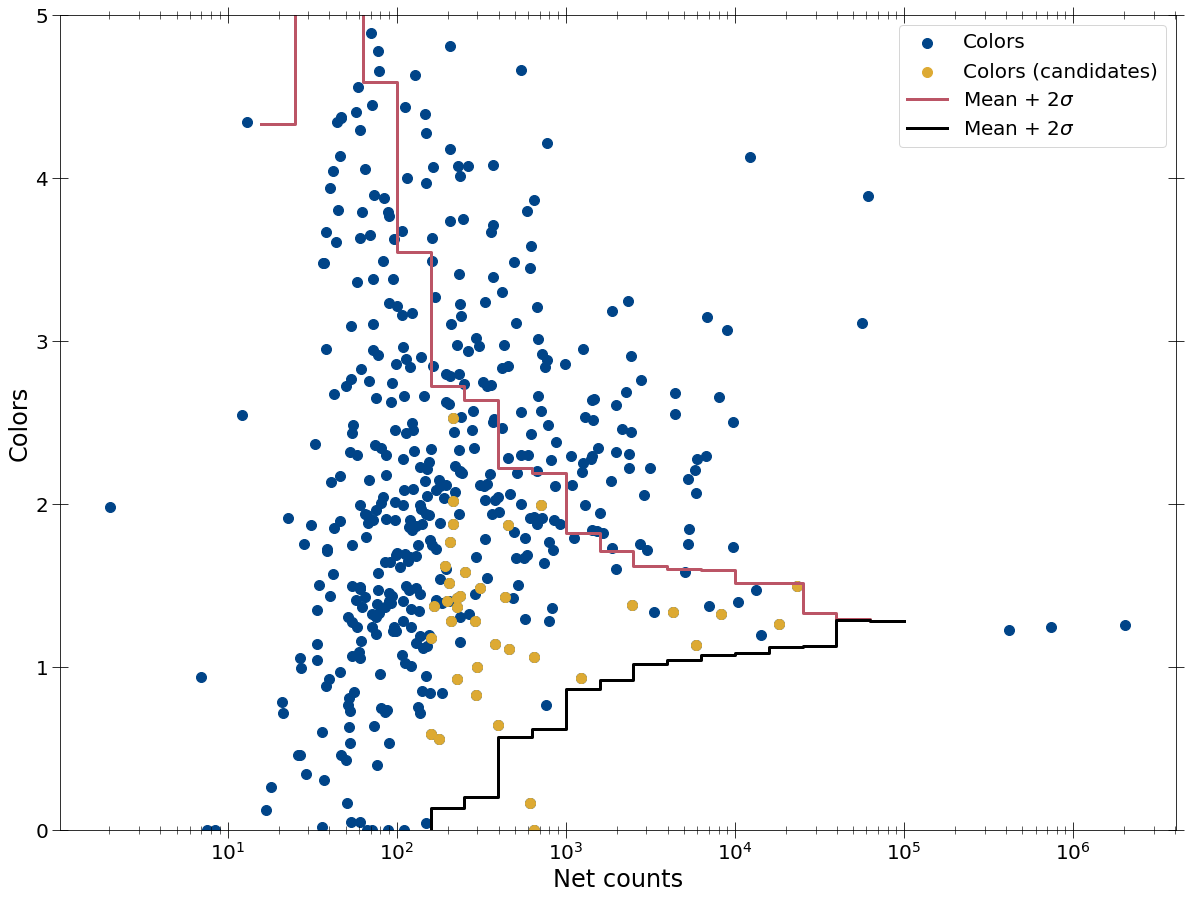

2:80: E501 line too long (83 > 79 characters)


In [64]:
mark_interested_srcs(sim_color_dict_arr[0], obs_color_dict_arr[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     candidate_srcs_pn, 0)

(array([ 14,  33,  55,  66,  84, 103, 117, 128, 137, 139, 183, 184, 199,
       201, 225, 226, 246, 260, 272, 273, 280]),)


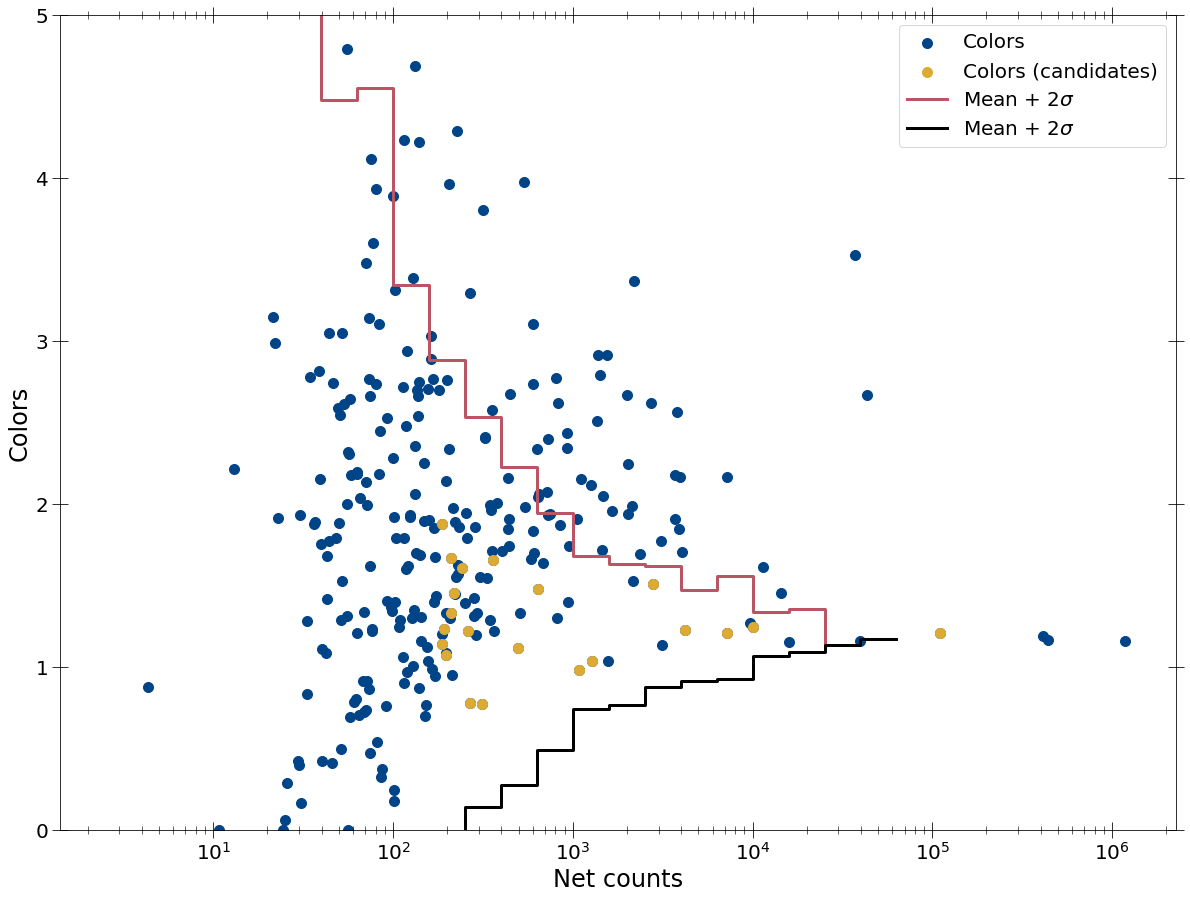

2:80: E501 line too long (83 > 79 characters)


In [65]:
mark_interested_srcs(sim_color_dict_arr[1], obs_color_dict_arr[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     candidate_srcs_mos, 0)

(array([   1,    2,   63,  115,  123,  137,  156,  162,  262,  349,  350,
        395,  396,  411,  419,  453,  454,  500,  543,  607,  616,  622,
        623,  674,  679,  685,  711,  719,  722,  737,  827,  831,  854,
        883,  900,  936,  945,  949,  982,  996,  997, 1006, 1037, 1051,
       1057, 1058, 1146, 1148, 1254, 1260, 1267, 1295, 1301, 1325, 1336,
       1353, 1382, 1391, 1394, 1416, 1424, 1471, 1501, 1507, 1524, 1527,
       1562, 1563, 1602, 1604, 1609, 1614, 1640, 1647, 1650, 1658, 1665,
       1686, 1734, 1735, 1737, 1767, 1786, 1816, 1820, 1833, 1863, 1885,
       1901, 1961, 1980, 2041]),)


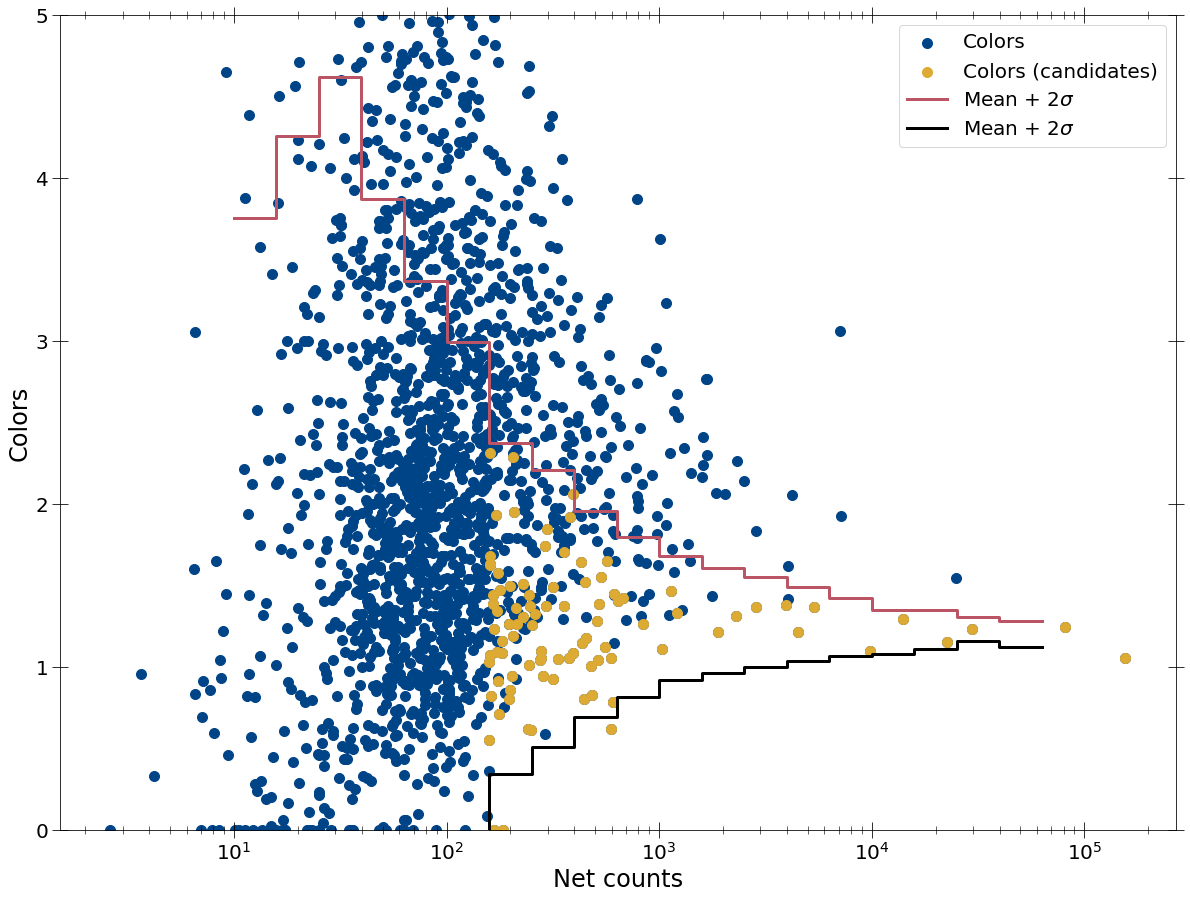

2:80: E501 line too long (83 > 79 characters)


In [66]:
mark_interested_srcs(sim_color_dict_arr[2], obs_color_dict_arr[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     candidate_srcs_acis, 0)

(array([  0,   5,  19,  33,  40,  44,  50,  74,  75,  86,  91, 111, 137,
       144, 147, 152, 187, 198, 211, 213, 229, 231, 240, 260, 266, 283,
       304, 308, 309, 336, 374, 388, 412, 442, 443, 465, 467]),)
(array([ 14,  33,  55,  66,  84, 103, 117, 128, 137, 139, 183, 184, 199,
       201, 225, 226, 246, 260, 272, 273, 280]),)
(array([   1,    2,   63,  115,  123,  137,  156,  162,  262,  349,  350,
        395,  396,  411,  419,  453,  454,  500,  543,  607,  616,  622,
        623,  674,  679,  685,  711,  719,  722,  737,  827,  831,  854,
        883,  900,  936,  945,  949,  982,  996,  997, 1006, 1037, 1051,
       1057, 1058, 1146, 1148, 1254, 1260, 1267, 1295, 1301, 1325, 1336,
       1353, 1382, 1391, 1394, 1416, 1424, 1471, 1501, 1507, 1524, 1527,
       1562, 1563, 1602, 1604, 1609, 1614, 1640, 1647, 1650, 1658, 1665,
       1686, 1734, 1735, 1737, 1767, 1786, 1816, 1820, 1833, 1863, 1885,
       1901, 1961, 1980, 2041]),)


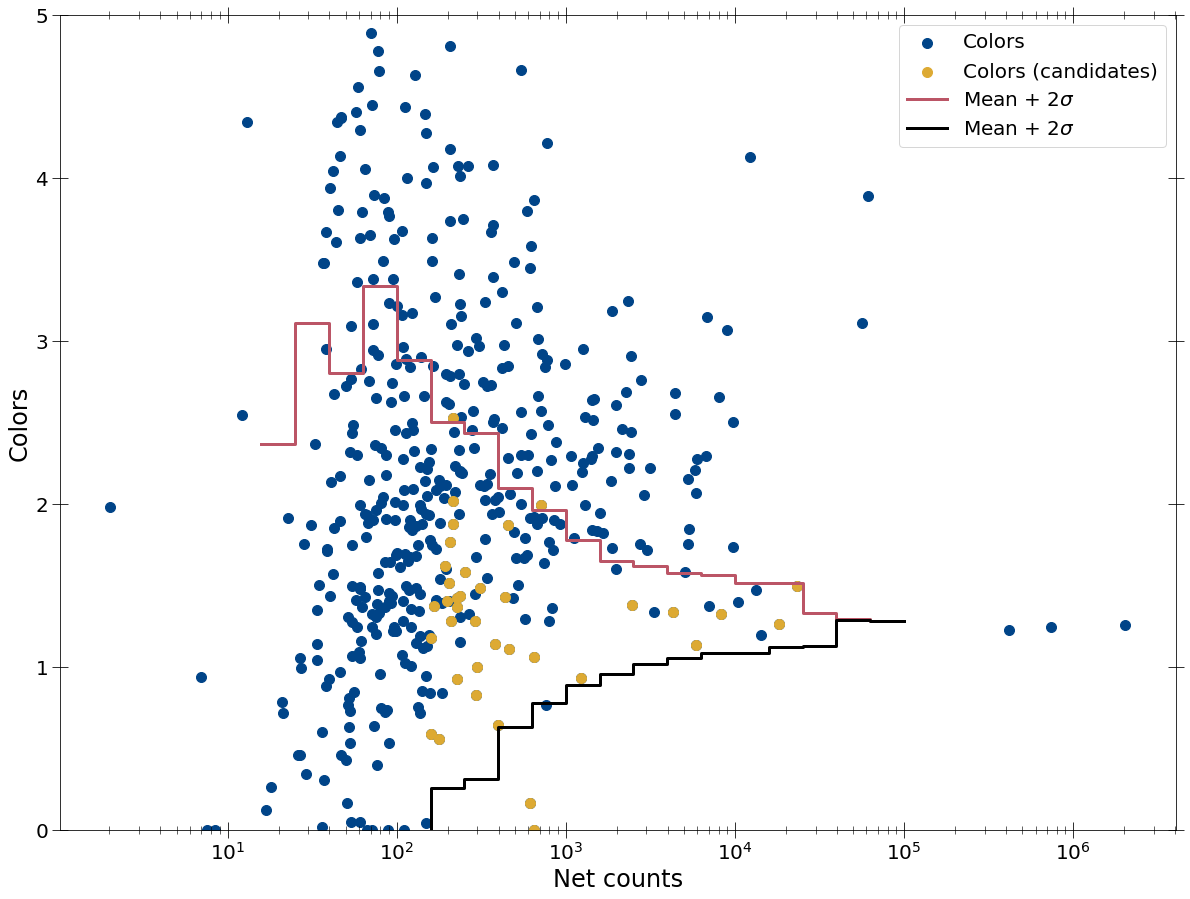

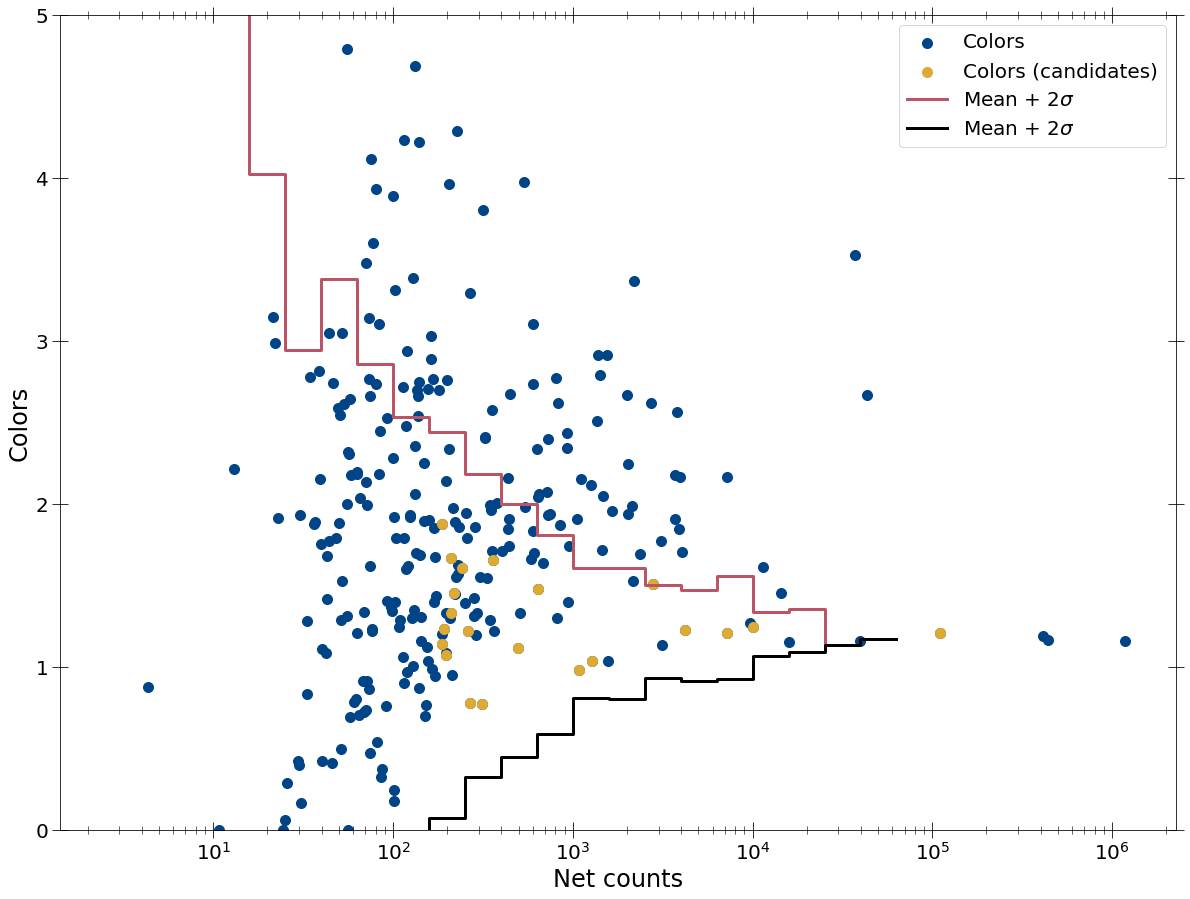

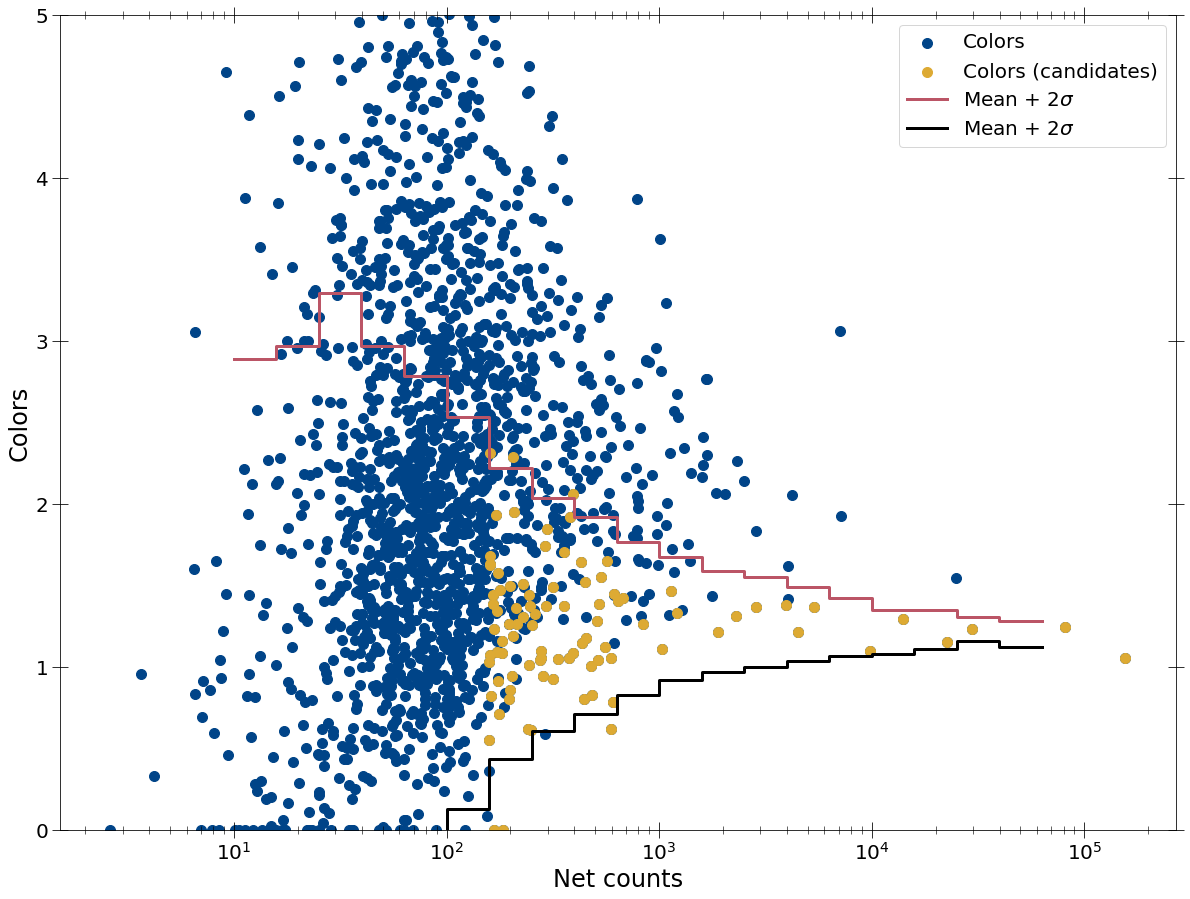

1:80: E501 line too long (82 > 79 characters)
2:80: E501 line too long (83 > 79 characters)
4:80: E501 line too long (82 > 79 characters)
5:80: E501 line too long (83 > 79 characters)
7:80: E501 line too long (82 > 79 characters)
8:80: E501 line too long (83 > 79 characters)


In [67]:
mark_interested_srcs(sim_color_dict_arr_clipped[0], obs_color_dict_arr_clipped[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     candidate_srcs_pn, 0)
mark_interested_srcs(sim_color_dict_arr_clipped[1], obs_color_dict_arr_clipped[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     candidate_srcs_mos, 0)
mark_interested_srcs(sim_color_dict_arr_clipped[2], obs_color_dict_arr_clipped[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     candidate_srcs_acis, 0)

In [108]:
np.where(interested_srcs_alldet[2] == '2CXOJ174530.0-285943')

(array([177]),)

In [110]:
print(acis_fit_stats_table_pl[125])
print(acis_fit_stats_table_pl_g[125])
print(acis_fit_stats_table_pl_g2[125])
print()
print(acis_fit_stats_table_pl[208])
print(acis_fit_stats_table_pl_g[208])
print(acis_fit_stats_table_pl_g2[208])
print()
print(acis_fit_stats_table_pl[133])
print(acis_fit_stats_table_pl_g[133])
print(acis_fit_stats_table_pl_g2[133])

['2CXOJ174540.3-290049', 266.01879656001785, -7.589646752720701, 50.0, 299]
['2CXOJ174540.3-290049', 264.6833556689429, -7.805990677928118, 50.0, 297]
['2CXOJ174540.3-290049', 263.92879916841827, -7.8578460350119865, 50.0, 296]

['2CXOJ174536.9-290039', 344.5620739732016, -9.526574126034008, 50.0, 389]
['2CXOJ174536.9-290039', 341.77998992125424, -9.871299609625027, 50.0, 387]
['2CXOJ174536.9-290039', 340.80402348470886, -9.916018231068454, 50.0, 386]

['2CXOJ174535.7-290004', 219.3432290242929, -8.32886982476195, 50.0, 254]
['2CXOJ174535.7-290004', 216.10212421697082, -8.175803506918273, 50.0, 252]
['2CXOJ174535.7-290004', 216.40324068904283, -8.163633107538715, 50.0, 251]


In [106]:
print(acis_model_params_table_pl_g2[125])
print(acis_model_params_table_pl_g2[208])
print(acis_model_params_table_pl_g2[133])

['2CXOJ174540.3-290049', 14.747172266857492, 2.284559245444103, 0.014014393023623173, 3.157876082859608e-08, 1.936457506907927e-08, 4.298694332175304e-19, 0.0, 8.242343569531286e-08, 0.0, 7.391659902986237e-08, 0.0, 3.2311902308687976e-08]
['2CXOJ174536.9-290039', 32.91698126831548, 2.169538475539656, 0.13824128530453256, 5.4557158152566107e-14, 1.4314730567579634e-07, 7.4035496908206e-08, 0.0, 1.1265319696324751e-07, 0.0, 3.059586290967107e-07, 0.0, 2.3806088884467742e-07]
['2CXOJ174535.7-290004', 25.294693190701558, 1.6423470508550815, 0.040934446317875135, 8.531655806100725e-08, 3.5908650704885276e-08, 1.1327547386683504e-08, 0.0, 1.9846436077281447e-07, 0.0, 1.5934190141787257e-07, 0.0, 1.3669784512889456e-07]


(array([ 678,  840,  990, 1335]),)


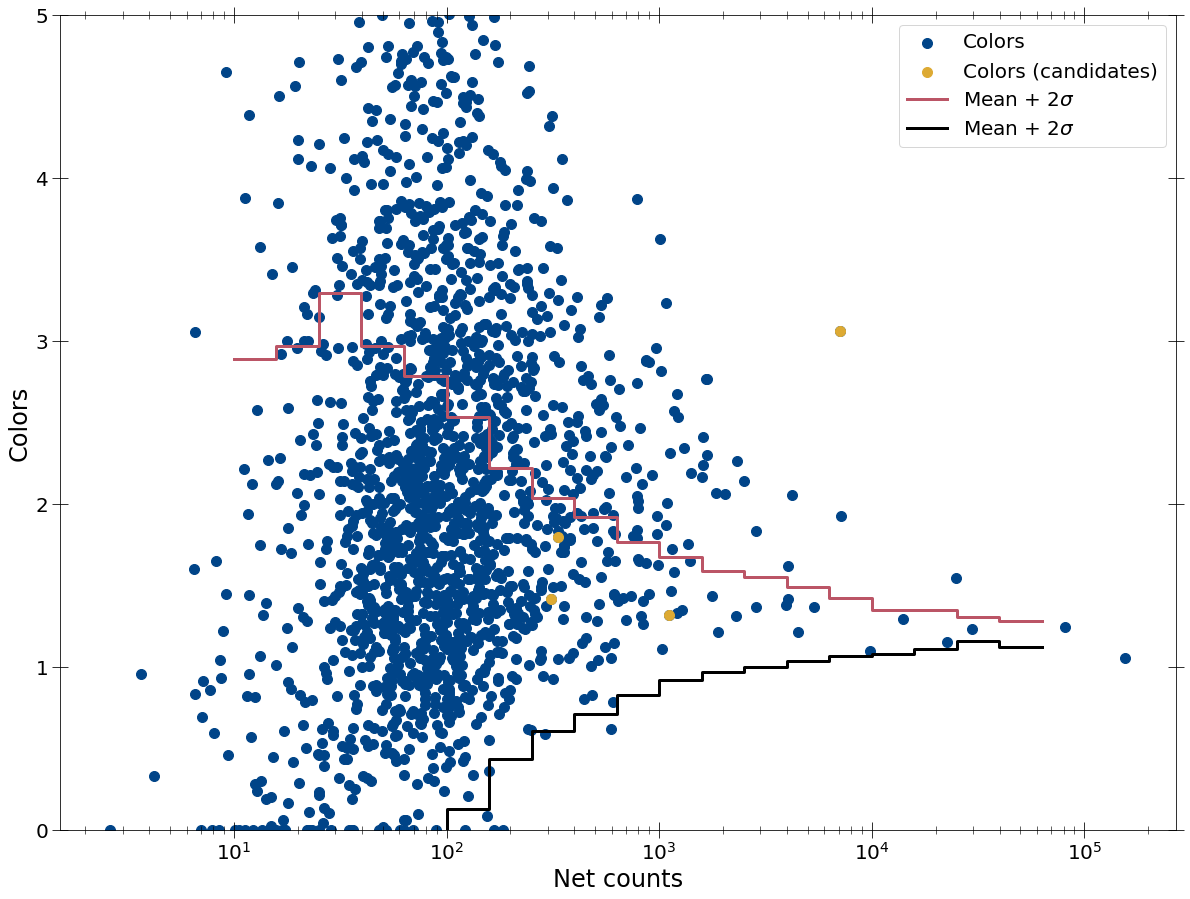

1:80: E501 line too long (82 > 79 characters)
2:80: E501 line too long (83 > 79 characters)


In [113]:
mark_interested_srcs(sim_color_dict_arr_clipped[2], obs_color_dict_arr_clipped[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     ['2CXOJ174540.3-290049', '2CXOJ174536.9-290039',
                      '2CXOJ174535.7-290004', '2CXOJ174536.1-285638',
                      '2CXOJ174532.7-285616'], 0)

In [ ]:

    candidate_args = interested_args_alldet[0][np.where(aic_pl > aic_pl_gauss)]
    candidate_netcounts = spec_summary['counts'][0][0][1][spec_summary['spec_masks'][1][3]][candidate_args]
    interested_netcounts = spec_summary['counts'][0][0][1][spec_summary['spec_masks'][1][3]][interested_args_alldet[0]]

    candidate_hist, bins = np.histogram(candidate_netcounts, bins=sim_color_dict_arr[0]['prop_bins'][0])
    interested_hist, bins = np.histogram(interested_netcounts, bins=sim_color_dict_arr[0]['prop_bins'][0])

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


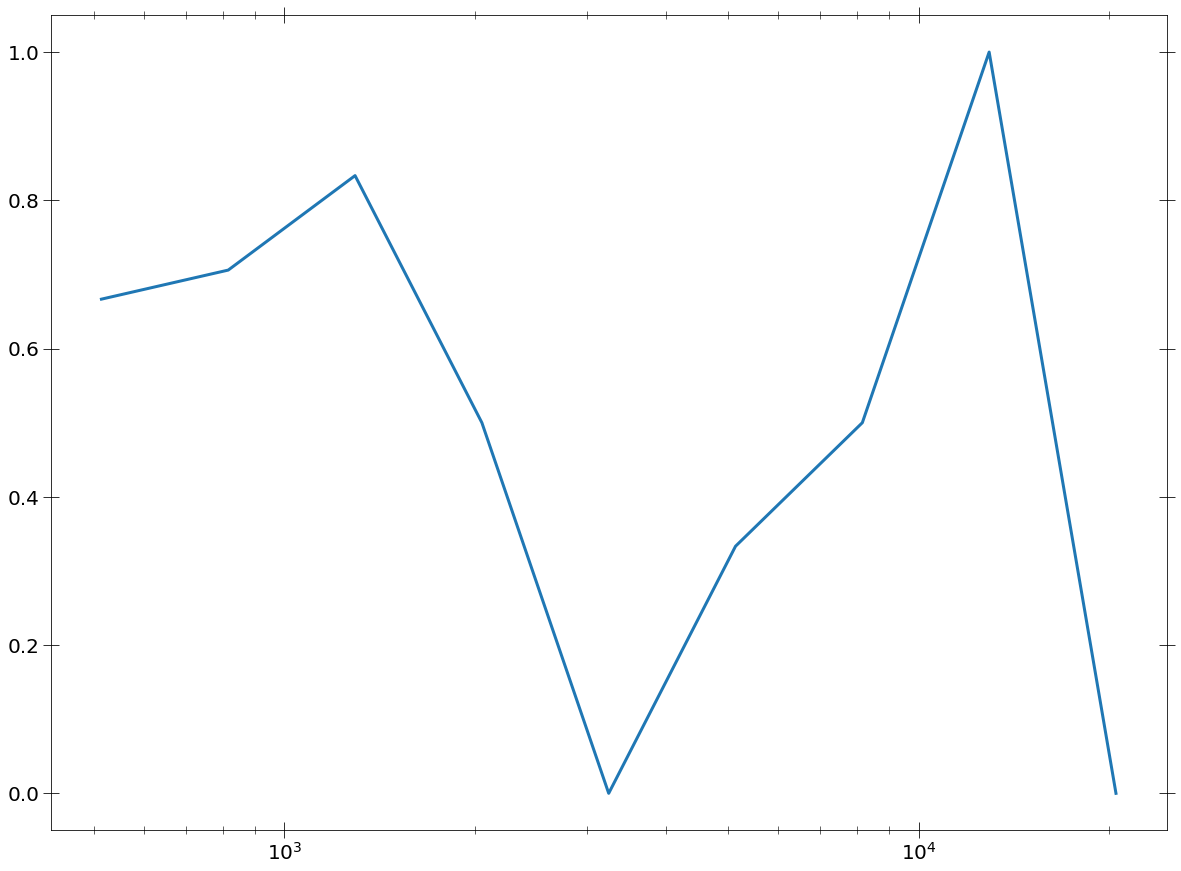

In [451]:
plt.plot(0.5*(bins[1:] + bins[:-1]), candidate_hist/interested_hist)
plt.xscale('log')

In [441]:
len(sim_color_dict_arr[0]['prop_bins'][0])

21

In [452]:
candidate_hist

array([ 0,  0,  0,  0,  0,  0,  0,  0, 12, 12,  5,  1,  0,  1,  1,  3,  0,
        0,  0,  0])

In [453]:
interested_hist

array([ 0,  0,  0,  0,  0,  0,  0,  0, 18, 17,  6,  2,  1,  3,  2,  3,  2,
        0,  0,  0])

In [449]:
bins

array([1.00000000e+01, 1.58489319e+01, 2.51188643e+01, 3.98107171e+01,
       6.30957344e+01, 1.00000000e+02, 1.58489319e+02, 2.51188643e+02,
       3.98107171e+02, 6.30957344e+02, 1.00000000e+03, 1.58489319e+03,
       2.51188643e+03, 3.98107171e+03, 6.30957344e+03, 1.00000000e+04,
       1.58489319e+04, 2.51188643e+04, 3.98107171e+04, 6.30957344e+04,
       1.00000000e+05])

In [454]:
fit_stats_pl_arr = np.array(mos_fit_stats_table_pl)
fit_stats_pl_gauss_arr = np.array(mos_fit_stats_table_pl_g)

aic_pl = fit_stats_pl_arr[:, 1].astype(float) + 6
aic_pl_gauss = fit_stats_pl_gauss_arr[:, 1].astype(float) + 10

candidate_args = interested_args_alldet[1][np.where(aic_pl > aic_pl_gauss)]
candidate_netcounts = spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][4]][candidate_args]
interested_netcounts = spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][4]][interested_args_alldet[1]]

candidate_hist, bins = np.histogram(candidate_netcounts, bins=sim_color_dict_arr[1]['prop_bins'][0])
interested_hist, bins = np.histogram(interested_netcounts, bins=sim_color_dict_arr[1]['prop_bins'][0])

IndexError: index 38 is out of bounds for axis 0 with size 38

8:80: E501 line too long (103 > 79 characters)
9:80: E501 line too long (115 > 79 characters)
11:80: E501 line too long (100 > 79 characters)


In [455]:
len(fit_stats_pl_arr)

57

In [456]:
len(mos_fit_stats_table_pl)

57

In [459]:
np.sort(interested_srcs_alldet[0])

array(['201113501010010', '201113501010035', '201113501010066',
       '201113501010154', '201113501010169', '201113503010004',
       '201129701010011', '201129701010015', '201129701010027',
       '201129701010041', '201129702010002', '201129704010011',
       '201129704010019', '201129704010027', '201129705010011',
       '201129705010015', '201129705010038', '201129705010067',
       '201129705010076', '201129705010079', '201129705015062',
       '201129706010014', '201129707010012', '201129707010063',
       '201129707010079', '201129709010024', '201129715010041',
       '201129719010010', '201129721010003', '201129721010009',
       '201129721010014', '201129721010022', '201129721010034',
       '201129721010035', '201129721010044', '201129721010057',
       '201129721010060', '201129721010063', '201129721010070',
       '201129721010078', '201129721010126', '201129721010133',
       '201129721015131', '202026705010034', '202026705010109',
       '202026708010021', '2030321020100

In [460]:
np.sort(interested_srcs_alldet[1])

array(['200305402010002', '201113501010010', '201113501010069',
       '201113501010114', '201113503010004', '201129701010035',
       '201129702010002', '201129704010048', '201129705010011',
       '201129705010014', '201129705010024', '201129705010067',
       '201129705010079', '201129705010095', '201129705015062',
       '201129706010014', '201129707010063', '201129708010036',
       '201129719010010', '201129721010003', '201129721010005',
       '201129721010014', '201129721010022', '201129721010034',
       '201129721010045', '201129721010053', '201129721010057',
       '201129721010060', '201129721010075', '201129721010138',
       '202026705010053', '204105804015018', '206556701010012',
       '206556701010019', '206946404010008', '207641904010001',
       '208016803010001', '208251401010006'], dtype=object)

In [69]:
def get_candidate_src_nums_det2(obs_src_nums, obs_det_mask, sim_color_dict,
                               obs_color_dict, min_counts):
    """Get src nums of quiescent sources for given detector"""
    obs_netcounts = obs_color_dict['prop_list'][0]
    netcount_bins = sim_color_dict['prop_bins'][0]
    obs_colors = obs_color_dict['colors']
    color_median = sim_color_dict['color_stat'][0][0]
    color_std = sim_color_dict['color_stat'][2][0]
    interested_args = []
    interested_srcs = []
    for i, lower_bin in enumerate(netcount_bins):
        if lower_bin < min_counts:
            continue
        if i == len(netcount_bins) - 1:
            upper_bin = np.max(obs_netcounts) + 10
            median_color = color_median[-1]
            std_color = color_std[-1]
        else:
            upper_bin = netcount_bins[i+1]
            median_color = color_median[i]
            std_color = color_std[i]
        if np.isnan(median_color) or np.isnan(std_color):
                    int_args = np.where(np.logical_and(
                        obs_netcounts >= lower_bin,
                        obs_netcounts < upper_bin))
        else:
        
            int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        print(obs_netcounts[int_args])
        interested_args.append(int_args)
        interested_srcs.append(obs_src_nums[obs_det_mask][int_args])
    return interested_args, interested_srcs


def get_candidate_src_nums_alldet2(spec_summary, sim_color_dict_arr,
                                  obs_color_dict_arr, min_count_arr=None):
    """Get source nums for all detectors."""
    interested_args_alldet = []
    interested_sources_alldet = []
    if min_count_arr is None:
        min_count_arr = [700, 700, 250]
    for i, obs_color_dict in enumerate(obs_color_dict_arr):
        if i > 0:
            interested_args, interested_srcs = get_candidate_src_nums_det2(
                spec_summary['src_nums'][i-1], spec_summary['spec_masks'][1][i],
                sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        else:
            interested_args, interested_srcs = get_candidate_src_nums_det2(
            spec_summary['src_nums'][i], spec_summary['spec_masks'][1][i],
            sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        interested_args_alldet.append(interested_args)
        interested_sources_alldet.append(interested_srcs)
    return interested_args_alldet, interested_sources_alldet


2:32: E128 continuation line under-indented for visual indent
23:21: E117 over-indented
27:1: W293 blank line contains whitespace
45:35: E128 continuation line under-indented for visual indent
54:80: E501 line too long (80 > 79 characters)
58:13: E122 continuation line missing indentation or outdented
59:13: E122 continuation line missing indentation or outdented


In [70]:
test_args, test_srcs = get_candidate_src_nums_alldet2(spec_summary, sim_color_dict_arr, obs_color_dict_arr,
                                                      min_count_arr=[380, 380, 220])

[569.59489915 404.91355624 452.26180445 465.79990524 576.32276827
 493.39928098 487.52737681 463.48454887 513.71340716 539.95700063
 612.30372428 609.93432573 398.9688382  574.42562696 508.04667046
 592.28189506 435.03011623 522.26141993]
[652.69197128 823.33408827 792.69706455 674.18975953 876.79367389
 679.04689138 739.16724045 845.56868658 723.70611642 845.86782834
 764.06300906 648.50489117 711.53733848 864.90478044 817.363117
 923.15858478 648.64365916 797.95791783]
[1536.6024365  1114.66782348 1422.7130562  1291.96679205 1584.24987616
 1222.55308145]
[1989.78879578 2448.29069852]
[3333.91840967]
[5906.66947885 4300.15059039 5076.11064059]
[8272.89976422 7040.72877535]
[10372.3500844  14301.84303534 13285.45941   ]
[23304.51640767 18219.60240603]
[]
[]
[]
[ 736611.79761745  418037.54709113 2024254.48411136]
[608.05064636 440.51106749 493.03633815 438.03845112 598.07676261
 443.31577824 586.65762292 507.54544255 433.71040735 542.88105163
 402.12852783]
[743.55291637 648.44849731 71

1:80: E501 line too long (107 > 79 characters)


In [44]:
test_srcs

[[array(['201113501010066', '201113501010154', '201129701010015',
         '201129704010011', '201129704010019', '201129704010027',
         '201129707010012', '201129707010063', '201129709010024',
         '201129715010041', '201129721010070', '201129721010126',
         '204003401010007', '204105804010005', '206556701010012',
         '208016803010001', '208016813010003', '208251401010006'],
        dtype=object),
  array(['201113501010169', '201129701010011', '201129701010027',
         '201129701010041', '201129704010048', '201129705010015',
         '201129705010038', '201129705010067', '201129705015062',
         '201129721010022', '201129721010035', '201129721010057',
         '201129721010133', '202026705010109', '202026708010021',
         '205547504010092', '206946402010009', '207641904010001'],
        dtype=object),
  array(['201113501010035', '201129707010079', '201129721010063',
         '201129721010078', '201129721015131', '202026705010034'],
        dtype=object),
  ar

In [93]:
def combine_spec_analysis(int_srcs_list, source_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    spec_list = []
    for source_num in int_srcs_list:
        if telescope == 'XMM':
            spec_pnfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                     str(source_num) + '_PN_combined_src_grp1*')
            spec_mosfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                      str(source_num) + '_MOS_combined_src_grp1*')
            if len(spec_pnfile) > 0:
                spec_pn = xspec.Spectrum(spec_pnfile[0])
                spec_pn.ignore('0.0-2.0, 10.0-**')
                spec_pn.notice('2.0-10.0')
                spec_list.append(spec_pn)
                print(spec_pn.rate[0]*spec_pn.exposure)
            if len(spec_mosfile) > 0:
                spec_mos = xspec.Spectrum(spec_mosfile[0])
                spec_mos.ignore('0.0-2.0, 10.0-**')
                spec_pn.notice('2.0-10.0')
                spec_list.append(spec_mos)
                print(spec_mos.rate[0]*spec_mos.exposure)
        elif telescope == 'Chandra':
            os.chdir(src_folder + '/' + source_num)
            spec_file = str(source_num) + '_combined_src_grp1.pi'
            spec = xspec.Spectrum(spec_file)
            spec.ignore('0.0-2.0, 10.0-**')
            spec.notice('2.0-10.0')
            os.chdir(curr_dir)
        else:
            print('Telescope not recognized.')
    
    model = xspec.Model('tbabs*pegpwrlw')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.perform()
    xspec.Fit.error('2.706 2')
    xspec.Fit.perform()
    #goodness = xspec.Fit.goodness(1000)
    goodness = 50.0
    
    xspec.Plot.device = '/xw'
    xspec.Plot.xAxis = 'keV'
    xspec.Plot.yLog = True
    xspec.Plot.setRebin(2, 1000, -1)
    xspec.Plot()
    print('Model params: '
          'NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0])
    print('Fit stats : ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    if telescope == 'Chandra':
        os.chdir(curr_dir)
    return ([int_srcs_list, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [int_srcs_list, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0]])

10:80: E501 line too long (80 > 79 characters)
12:80: E501 line too long (82 > 79 characters)
34:1: W293 blank line contains whitespace
44:5: E265 block comment should start with '# '
46:1: W293 blank line contains whitespace
61:80: E501 line too long (83 > 79 characters)


In [95]:
combine_spec_analysis(test_srcs[0][1])

654.4603630490105
824.1378576545412
716.8100536050601
795.4471140394922
220.3010253394772
673.1919534877306
806.0406733582817
877.330611434544
949.5044931691929
681.247948793877
162.2880763393362
736.751589007554
349.2025802477865
841.2293566233209
680.7494567901176
725.3070590144457
844.6655306385417
845.6103149179244
2153.566380181197
764.2810261818187
642.8417595934877
1078.7955794357108
711.3929357221539
864.5409737688612
113.31528293446061
815.8800274223036
923.4042521844088
74.37753238277094
649.1042695369483
797.4801613279265
586.9997543090454
Model params: NH =  13.231711938962313  Gamma:  0.9200176939172249  norm:  0.1632279364041732
Fit stats :  32184.51283053665 -6.530554835870103 50.0 29932




([array(['201113501010169', '201129701010011', '201129701010027',
         '201129701010041', '201129704010048', '201129705010015',
         '201129705010038', '201129705010067', '201129705015062',
         '201129721010022', '201129721010035', '201129721010057',
         '201129721010133', '202026705010109', '202026708010021',
         '205547504010092', '206946402010009', '207641904010001'],
        dtype=object),
  32184.51283053665,
  -6.530554835870103,
  50.0,
  29932],
 [array(['201113501010169', '201129701010011', '201129701010027',
         '201129701010041', '201129704010048', '201129705010015',
         '201129705010038', '201129705010067', '201129705015062',
         '201129721010022', '201129721010035', '201129721010057',
         '201129721010133', '202026705010109', '202026708010021',
         '205547504010092', '206946402010009', '207641904010001'],
        dtype=object),
  13.231711938962313,
  0.9200176939172249,
  0.1632279364041732])

In [88]:
spec_summary['counts'][0][0][1][spec_summary['spec_masks'][1][0]][test_args[0][0]]

array([569.59489915, 404.91355624, 452.26180445, 465.79990524,
       576.32276827, 493.39928098, 487.52737681, 463.48454887,
       513.71340716, 539.95700063, 612.30372428, 609.93432573,
       398.9688382 , 574.42562696, 508.04667046, 592.28189506,
       435.03011623, 522.26141993])

In [80]:
spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][0]][test_args[0][0]]

array([  77.06422098,  169.29402981,   80.75597502,  287.22584027,
        117.51882974,  131.66078883,   62.82256871,  493.03633815,
        226.05028649,  204.3105431 ,  115.47278273, -167.7485317 ,
        311.87986676, 1110.11849309,  443.31577824,  507.54544255,
        262.10215037,  433.71040735])

In [99]:
len(interested_srcs_alldet[2])

140

In [33]:
def fit_src_pl_gauss2(source_num, src_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    if telescope == 'XMM':
        spec_pnfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                 str(source_num) + '_PN_combined_src_grp1*')
        spec_mosfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                  str(source_num) + '_MOS_combined_src_grp1*')
        if len(spec_pnfile) > 0:
            spec_pn = xspec.Spectrum(spec_pnfile[0])
            spec_pn.ignore('0.0-2.0, 10.0-**')
        if len(spec_mosfile) > 0:
            spec_mos = xspec.Spectrum(spec_mosfile[0])
            spec_mos.ignore('0.0-2.0, 10.0-**')
    elif telescope == 'Chandra':
        os.chdir(src_folder + '/' + source_num)
        spec_file = str(source_num) + '_combined_src_grp1.pi'
        spec = xspec.Spectrum(spec_file)
        spec.ignore('0.0-2.0, 10.0-**')
        spec.notice('2.0-10.0')
    else:
        print('Telescope not recognized.')
    
    model = xspec.Model('tbabs*(pegpwrlw+gauss+gauss+gauss)')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    model.pegpwrlw.eMin.values = '2.0'
    model.pegpwrlw.eMax.values = '10.0'
    model.gaussian.LineE.values = '6.4 0'
    model.gaussian.Sigma.values = '0.0 0'
    model.gaussian.norm.values = '1.0E-5, 0.001,,,,'
    model.gaussian_4.LineE.values = '6.7 0'
    model.gaussian_4.Sigma.values = '0.0 0'
    model.gaussian_4.norm.values = '1.0E-5, 0.001,,,,'
    model.gaussian_5.LineE.values = '7.0 0'
    model.gaussian_5.Sigma.values = '0.0 0'
    model.gaussian_5.norm.values = '1.0E-5, 0.001,,,,'
    
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.query = 'yes'
    xspec.Fit.perform()
    xspec.Fit.error('2.706 8')
    xspec.Fit.perform()
    xspec.Fit.error('2.706 11')
    xspec.Fit.perform()
    xspec.Fit.error('2.706 14')
    # xspec.Fit.error('2.706 8')
    #goodness = xspec.Fit.goodness(1000)
    goodness = 50.0
    line_norm1_low = xspec.AllModels(1).gaussian.norm.error[0]
    line_norm1_high = xspec.AllModels(1).gaussian.norm.error[1]
    line_norm2_low = xspec.AllModels(1).gaussian_4.norm.error[0]
    line_norm2_high = xspec.AllModels(1).gaussian_4.norm.error[1]
    line_norm3_low = xspec.AllModels(1).gaussian_5.norm.error[0]
    line_norm3_high = xspec.AllModels(1).gaussian_5.norm.error[1]
    print('Model params for ' + source_num +
          ': NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0],
          ' Fe_norms:', xspec.AllModels(1).gaussian.norm.values[0],
          line_norm1_low, line_norm1_high,
          xspec.AllModels(1).gaussian_4.norm.values[0], line_norm2_low,
          line_norm2_high, xspec.AllModels(1).gaussian_5.norm.values[0],
          line_norm3_low, line_norm3_high)
    print('Fit stats for ' + source_num + ': ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    os.chdir(curr_dir)
    return ([source_num, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [source_num, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0],
             xspec.AllModels(1).gaussian.norm.values[0],
             xspec.AllModels(1).gaussian_4.norm.values[0],
             xspec.AllModels(1).gaussian_5.norm.values[0], line_norm1_low,
             line_norm1_high, line_norm2_low, line_norm2_high, line_norm3_low,
             line_norm3_high])


25:1: W293 blank line contains whitespace
40:1: W293 blank line contains whitespace
52:5: E265 block comment should start with '# '
73:80: E501 line too long (80 > 79 characters)


In [87]:
fit_src_pl_gauss2(interested_srcs_alldet[2][125], src_folder='./chandra_obs', telescope='Chandra')

Model params for 2CXOJ174540.3-290049: NH =  14.747172266857492  Gamma:  2.284559245444103  norm:  0.014014393023623173  Fe_norms: 3.157876082859608e-08 0.0 8.242343569531286e-08 1.936457506907927e-08 0.0 7.391659902986237e-08 4.298694332175304e-19 0.0 3.2311902308687976e-08
Fit stats for 2CXOJ174540.3-290049:  263.92879916841827 -7.8578460350119865 50.0 296




(['2CXOJ174540.3-290049', 263.92879916841827, -7.8578460350119865, 50.0, 296],
 ['2CXOJ174540.3-290049',
  14.747172266857492,
  2.284559245444103,
  0.014014393023623173,
  3.157876082859608e-08,
  1.936457506907927e-08,
  4.298694332175304e-19,
  0.0,
  8.242343569531286e-08,
  0.0,
  7.391659902986237e-08,
  0.0,
  3.2311902308687976e-08])

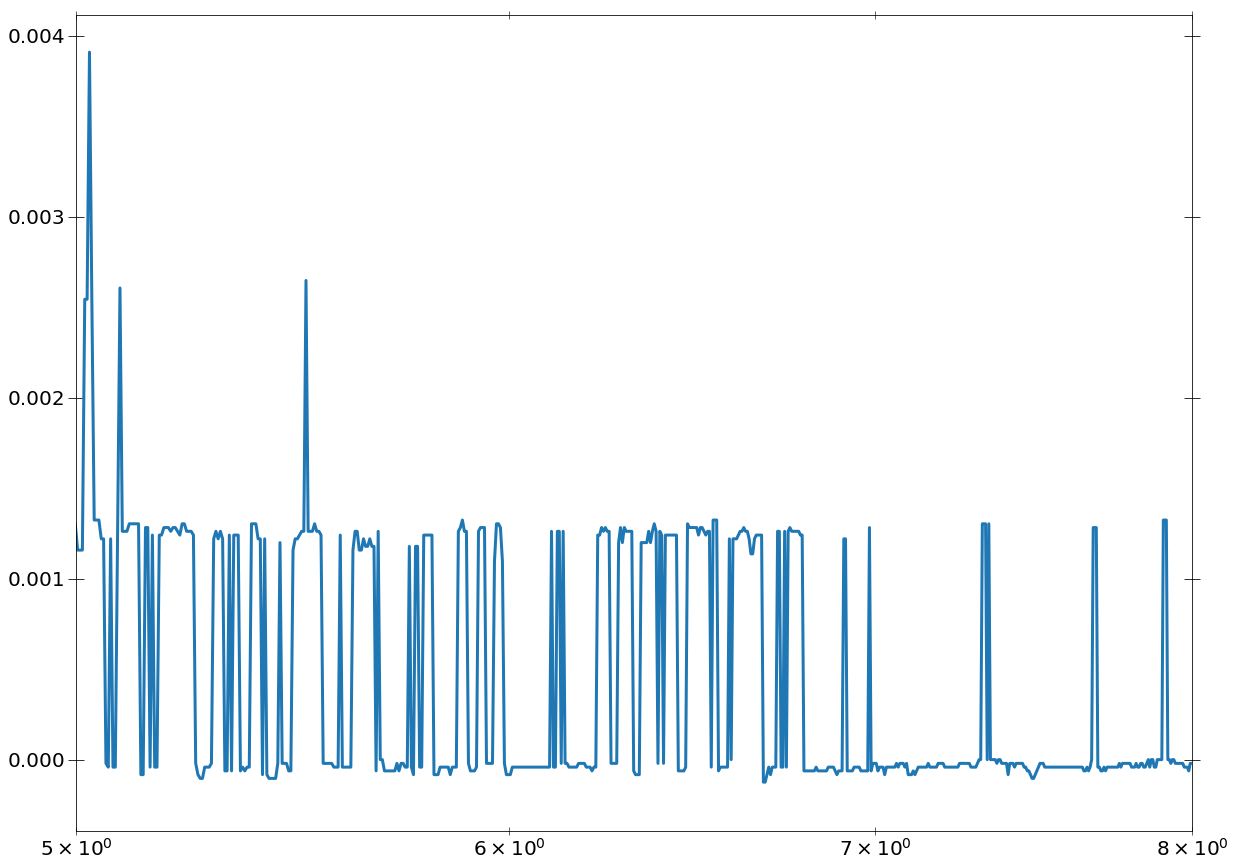

2:80: E501 line too long (130 > 79 characters)


In [62]:
plt.plot(spec_summary['ebins'][1][1][400:2000],
         median_filter(spec_summary['norm_specs'][1][1][spec_summary['spec_masks'][1][1]][interested_args_alldet[1][11]], size=5))
plt.xlim(5.0, 8.0)
plt.xscale('log')

In [67]:
spec_summary['src_nums'][0][spec_summary['spec_masks'][1][1]][interested_args_alldet[1][11]]

'200305402010002'

In [82]:
from astropy.table import Table
from astropy.table.pprint import conf
conf.max_lines = -1
conf.max_width = -1

In [83]:
Table(np.column_stack([np.array(pn_fit_stats_table_pl)[:, 0],
                       np.array(pn_fit_stats_table_pl_g2)[:, 4],
                       np.array(pn_fit_stats_table_pl)[:, 1],
                       np.array(pn_fit_stats_table_pl_g)[:, 1],
                       np.array(pn_fit_stats_table_pl_g2)[:, 1],
                       np.array(pn_model_params_table_pl_g)[:, 4],
                       np.array(pn_model_params_table_pl_g)[:, 7],
                       np.array(pn_model_params_table_pl_g2)[:, 4],
                       np.array(pn_model_params_table_pl_g2)[:, 5],
                       np.array(pn_model_params_table_pl_g2)[:, 6]]))

<Table length=58>
      col0       col1        col2               col3               col4               col5                 col6                   col7                   col8                   col9         
     str32      str32       str32              str32              str32              str32                str32                  str32                  str32                  str32         
--------------- ----- ------------------ ------------------ ------------------ ------------------ ---------------------- ---------------------- ---------------------- ----------------------
201113501010066  1097  888.3133866673959  881.7070650294453  881.1913228858143  6.495842098254313  5.728099295853509e-07  4.331544399555877e-07 1.9773822826801004e-07 1.5584199303060894e-07
201113501010154  1149  903.3608054015875  898.9897342154572  894.8121029186211  6.416690600469637  3.657184129034429e-07 3.5010040157522126e-07  4.580896096106657e-20 3.0838833914018393e-07
201129701010015   880  729.9447013450703  726.1680242153152   728.208293235638  6.878504435779244 2.8030459351071563e-07  6.557294646155204e-09  3.952180009005394e-08   1.84901608991034e-07
201129704010011  1194 1012.6079029890961 1002.1164436811466 1000.9736609156014  6.376259261068899  1.038662399360663e-06  7.930982457150612e-07  1.384644000570789e-07  4.940973238026691e-07
201129704010019  1215 1029.8154873905944 1025.8642811120633 1025.0969960585987  6.445404018100875  4.927351161304949e-07 3.2552759609400053e-07 1.0890863712728476e-07 3.7679459927014663e-07
201129704010027  1010  785.9195607248512  779.6130717470733  772.8673731092612  6.914603394912961  9.147377125465467e-07  7.142996249303996e-07 2.7521655807736366e-07  8.885324041183697e-07
201129707010012   682   567.787069467711  553.9318661357931  560.4612703153173  6.280521164961761  1.108564397466515e-06  6.793189563458339e-07 2.4888436958518062e-11  7.328702613575944e-08
201129707010063  2029  1603.580620175288 1603.4019947460515 1603.5633270184708  6.818844746386391 1.7222155963966992e-07 1.3274084432954834e-13 4.1359511318018613e-08 2.1443448180484209e-13
201129709010024   900  811.3262222227015  794.8089768017549  781.4206009405018 6.5481877496665355  9.642184610454263e-07  6.496074113129098e-07   6.07007290264001e-07 4.4822010250036727e-07
201129715010041  1034  874.5940461384438  863.4061820593956  856.2815123478654  6.789130174138019  5.935354490473833e-07  4.044163041726859e-07 3.4045138379642045e-07  2.829822266799647e-07
201129721010070  1536 1368.7909668927011 1363.6786628556076 1359.2717472122838  6.698765985480515  3.636688327975731e-07  2.536432877641739e-07 2.7199356036791055e-07  6.380835318524561e-08
201129721010126  2247 2056.1101220958135  2053.200585681294  2056.155328694617  6.100000000039239 1.9827337971923438e-07  1.123985724773552e-19 2.2605979657196566e-08 1.0167671193164822e-21
204003401010007  1384 1141.6552412391381 1141.5054008909347 1141.6854008904472  7.299999998226762  7.519391980881133e-08 6.2415342406533365e-15 2.1783277157329295e-15 2.4556035404823284e-16
204105804010005  1831  1497.955651820031 1491.1449179670433 1494.0475189246063  6.335984950645728  9.956675298151302e-07  5.889168575620609e-07  4.101678286897325e-14  1.508131704458345e-07
206556701010012  1498 1186.5589869334085 1158.4382948149878   1156.93355462016  6.664569714183259  9.879737143004975e-07  1.258050961555429e-07  8.132278353689629e-07  3.694738627039989e-12
208016803010001  1130   991.648224955775  986.3285668155654  986.6302556755354   6.47529835813703  1.348419485181247e-06 1.0077564820562453e-06 3.5762682889789996e-07  6.663621104605321e-15
208016813010003   760  609.6442782716246   607.318719084682  608.3194279092002  6.922400232207302  3.887961194557842e-07  3.958987589518239e-08  5.459081399403479e-22 3.2083101899889503e-07
208251401010006  1153  885.2047801624528  868.0245187034831  865.2031044494875  6.796034861844605 1.0310878445694557e-06 2.0726588575814643e-07  6.388394028854008e-07   6.25504734638

In [75]:
np.array(pn_fit_stats_table_pl)

array([['201113501010066', '888.3133866673959', '-8.204968056946765',
        '50.0', '1100'],
       ['201113501010154', '903.3608054015875', '-7.9889327474572935',
        '50.0', '1152'],
       ['201129701010015', '729.9447013450703', '-6.853237332107479',
        '50.0', '883'],
       ['201129704010011', '1012.6079029890961', '-4.516491937423837',
        '50.0', '1197'],
       ['201129704010019', '1029.8154873905944', '-8.696263026204749',
        '50.0', '1218'],
       ['201129704010027', '785.9195607248512', '-7.299622810407817',
        '50.0', '1013'],
       ['201129707010012', '567.787069467711', '-7.714088239148532',
        '50.0', '685'],
       ['201129707010063', '1603.580620175288', '-5.885724150152902',
        '50.0', '2032'],
       ['201129709010024', '811.3262222227015', '-6.198280503456527',
        '50.0', '903'],
       ['201129715010041', '874.5940461384438', '-8.348768445708139',
        '50.0', '1037'],
       ['201129721010070', '1368.7909668927011', '-